In [ ]:
# import gym
import numpy as np
import json
# from gym import spaces
from transformers import AutoTokenizer, AutoModel
import torch
import csv
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
# from gym import Env
# from gym.spaces import Discrete, Box
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import ast

In [ ]:
!pip install shimmy gymnasium

In [ ]:

nltk.download('words')
from nltk.corpus import words


english_dictionary = set(word.lower() for word in words.words() if len(word) >= 4)


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:


def find_max_spangram(csv_path):
    max_len = 0
    max_spangrams = []

    with open(csv_path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            sp = row.get("Spangram", "").strip()
            # skip empty or N/A entries
            if not sp or sp.upper() == "N/A":
                continue

            length = len(sp)
            if length > max_len:
                max_len = length
                max_spangrams = [(row.get("PuzzleNumber", "Unknown"), sp)]
            elif length == max_len:
                max_spangrams.append((row.get("PuzzleNumber", "Unknown"), sp))

    print(f"Maximum spangram length: {max_len}")
    for puzzle_num, sp in max_spangrams:
        print(f" - Puzzle {puzzle_num}: {sp}")

    return max_len, max_spangrams

if __name__ == "__main__":
    find_max_spangram("/content/drive/MyDrive/Colab Notebooks/my_data/nyt_strands_dataset_filtered.csv")


Maximum spangram length: 17
 - Puzzle 482: BATTERIESREQUIRED


In [ ]:

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/my_data/nyt_strands_dataset_filtered.csv", dtype=str)

In [ ]:
print(df)

           Date PuzzleNumber                    Theme       Spangram  \
0    2024-06-27          116          Better together     COMBOMEALS   
1    2024-06-29          118  It's way over your head     OUTERSPACE   
2    2024-06-30          119            Cut and color     JEWELTONES   
3    2024-07-01          120       We've got the beat     PERCUSSION   
4    2024-07-02          121             Heat and eat        COOKING   
..          ...          ...                      ...            ...   
337  2025-07-16          500         Tech accessories         TABLET   
338  2025-07-17          501           Find your seat       THEATERS   
339  2025-07-18          502             Abracadabra!       ITSMAGIC   
340  2025-07-19          503       Hot enough for ya?  SUMMERWEATHER   
341  2025-07-20          504             Shore thing!    BEACHATTIRE   

                                             ClueWords  \
0    AROMA, CAMO, SANE, COME, COMES, GREASE, CUTS, ...   
1    TILE, TEETER, 

In [ ]:



def is_nonempty_letter_grid(grid_str, min_filled_cells=30):
    try:
        if not isinstance(grid_str, str):
            return False
        data = json.loads(grid_str.strip())
        if not isinstance(data, list) or len(data) < 1:
            return False

        grid = data[0]
        if not isinstance(grid, list) or len(grid) != 8:
            return False

        filled = 0
        for row in grid:
            if not isinstance(row, list) or len(row) != 6:
                return False
            for cell in row:
                if isinstance(cell, str) and re.match(r"[A-Z]", cell.strip(), re.I):
                    filled += 1
        return filled >= min_filled_cells
    except Exception:
        return False

df = df[df["Grid"].apply(is_nonempty_letter_grid)]



In [ ]:
new_puzzle = pd.DataFrame([{
    "Date": "2025-07-06",
    "PuzzleNumber": 490,
    "Theme": "My Hero!",
    "Spangram": "SUPERPOWER",
    "ClueWords": "PEST, PETS, PITH, BILE, SUED, POWER, BITE, LIGHT, TOPS, SPOT, GENT, FEED, FEET, RENT, RENTS",
    "Answers": "SPEED, FLIGHT, HEALING, STRENGTH, INVISIBILITY",
    "Grid": json.dumps([
        ["R", "E", "G", "H", "R", "N"],
        ["T", "N", "T", "E", "I", "V"],
        ["S", "P", "O", "W", "S", "I"],
        ["I", "R", "L", "I", "B", "I"],
        ["G", "L", "E", "I", "E", "A"],
        ["H", "F", "P", "T", "H", "L"],
        ["P", "T", "E", "U", "Y", "I"],
        ["S", "E", "D", "S", "G", "N"]
    ])
}])

df = pd.concat([df, new_puzzle], ignore_index=True)
df.to_csv("nyt_strands_dataset.csv", index=False)

In [ ]:
all_extra_words = set()

for row in df.itertuples():
    answers = row.Answers if isinstance(row.Answers, str) else ""
    spangram = row.Spangram if isinstance(row.Spangram, str) else ""
    clues = row.ClueWords if isinstance(row.ClueWords, str) else ""

    all_extra_words.update(w.lower() for w in answers.split(",") if w.strip())

    if spangram.strip() and spangram.lower() not in english_dictionary:
        all_extra_words.add(spangram.lower())

    all_extra_words.update(w.lower() for w in clues.split(",") if w.strip())

english_dictionary.update(all_extra_words)


In [ ]:
df['NumAnswers'] = df['Answers'].fillna('').apply(
    lambda x: len([w for w in str(x).split(',') if len(w.strip()) >= 4])
)

print(df)

           Date PuzzleNumber                    Theme       Spangram  \
0    2024-06-27          116          Better together     COMBOMEALS   
1    2024-06-29          118  It's way over your head     OUTERSPACE   
2    2024-06-30          119            Cut and color     JEWELTONES   
3    2024-07-01          120       We've got the beat     PERCUSSION   
4    2024-07-02          121             Heat and eat        COOKING   
..          ...          ...                      ...            ...   
337  2025-07-16          500         Tech accessories         TABLET   
338  2025-07-17          501           Find your seat       THEATERS   
339  2025-07-18          502             Abracadabra!       ITSMAGIC   
340  2025-07-19          503       Hot enough for ya?  SUMMERWEATHER   
341  2025-07-20          504             Shore thing!    BEACHATTIRE   

                                             ClueWords  \
0    AROMA, CAMO, SANE, COME, COMES, GREASE, CUTS, ...   
1    TILE, TEETER, 

In [ ]:
df.to_csv("nyt_strands_filtered_numbered.csv", index=False)

/tmp/ipython-input-9-1320826172.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(answer_props.keys()), y=list(answer_props.values()), palette="pastel")
/tmp/ipython-input-9-1320826172.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(spangram_props.keys()), y=list(spangram_props.values()), palette="muted")


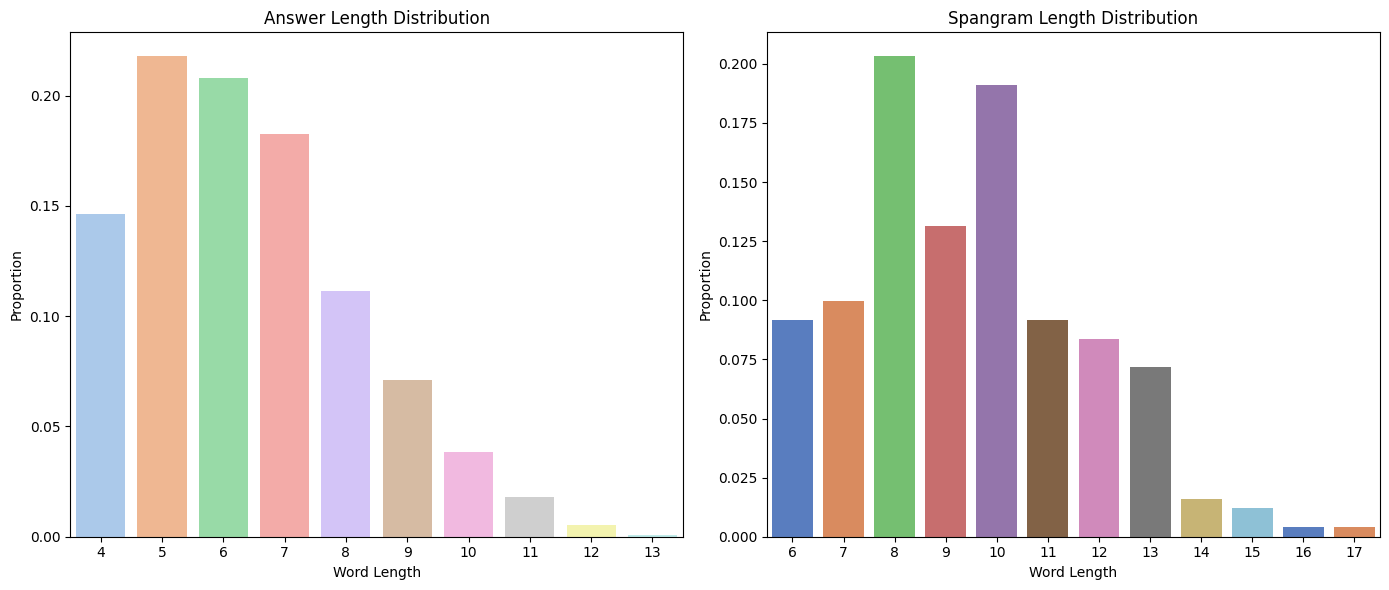

📊 Summary Stats:
Average answer length: 6.39
Average spangram length: 9.45


In [ ]:

def parse_answers(s):
    if pd.isna(s): return []
    return [word.strip() for word in s.split(",") if word.strip()]


df["AnswersParsed"] = df["Answers"].apply(parse_answers)
df["SpangramParsed"] = df["Spangram"].astype(str).str.strip().str.lower()


answer_lengths = [len(word) for answers in df["AnswersParsed"] for word in answers]
spangram_lengths = df["SpangramParsed"].apply(len).tolist()

avg_answer_length = sum(answer_lengths) / len(answer_lengths)
avg_spangram_length = sum(spangram_lengths) / len(spangram_lengths)

answer_dist = Counter(answer_lengths)
spangram_dist = Counter(spangram_lengths)

answer_props = {k: v / sum(answer_dist.values()) for k, v in sorted(answer_dist.items())}
spangram_props = {k: v / sum(spangram_dist.values()) for k, v in sorted(spangram_dist.items())}


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=list(answer_props.keys()), y=list(answer_props.values()), palette="pastel")
plt.title("Answer Length Distribution")
plt.xlabel("Word Length")
plt.ylabel("Proportion")


plt.subplot(1, 2, 2)
sns.barplot(x=list(spangram_props.keys()), y=list(spangram_props.values()), palette="muted")
plt.title("Spangram Length Distribution")
plt.xlabel("Word Length")
plt.ylabel("Proportion")

plt.tight_layout()
plt.show()

print("Summary Stats:")
print(f"Average answer length: {avg_answer_length:.2f}")
print(f"Average spangram length: {avg_spangram_length:.2f}")


/tmp/ipython-input-35-3009992697.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=list(answer_props.keys()), y=list(answer_props.values()),
/tmp/ipython-input-35-3009992697.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=list(spangram_props.keys()), y=list(spangram_props.values()),
/tmp/ipython-input-35-3009992697.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(x=list(clue_props.keys()), y=list(clue_props.values()),


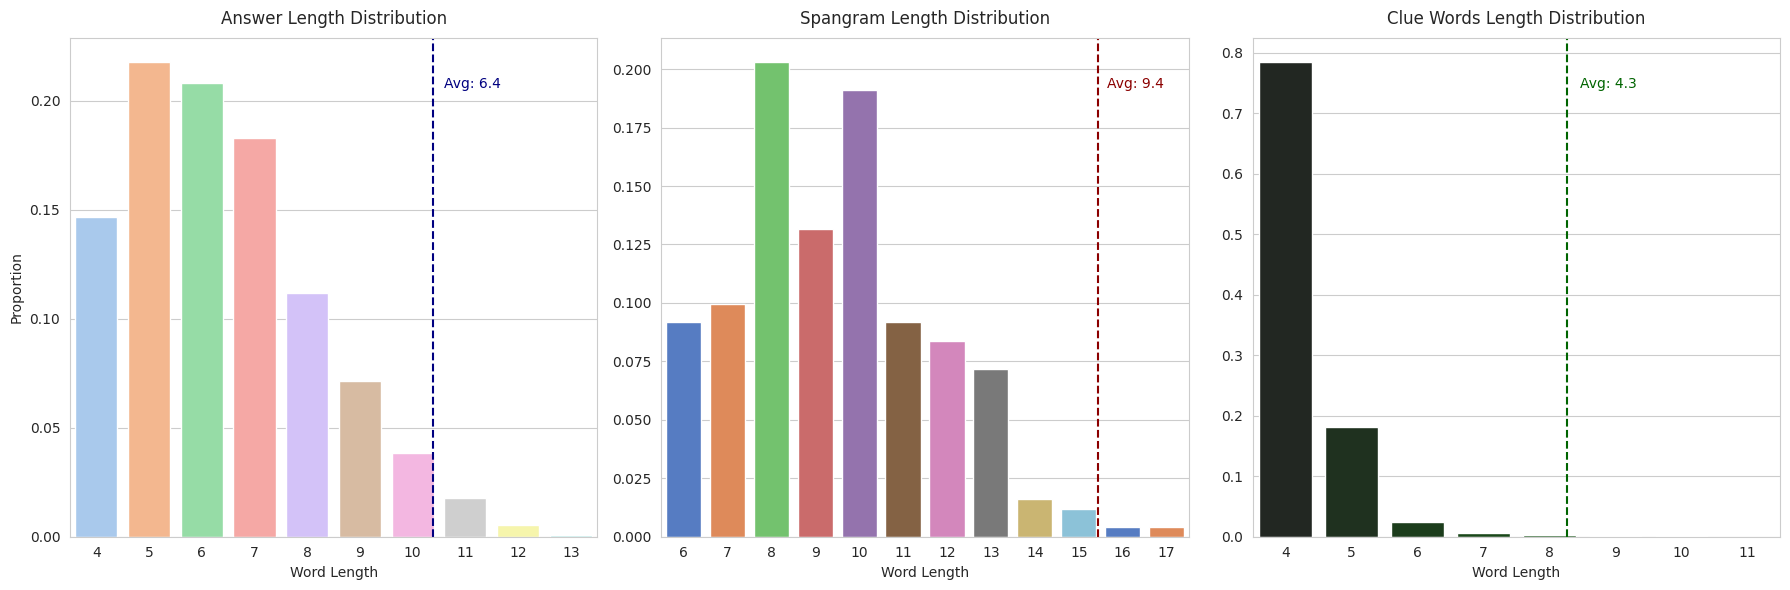

📊 Summary Stats:
Average answer length: 6.39
Average spangram length: 9.45
Average clue words length: 4.26

🔍 Length Comparison:
Spangrams are 47.9% longer than answers
Clue words are -33.3% shorter than answers


In [ ]:
def parse_words(s):
    if pd.isna(s): return []
    return [word.strip() for word in s.split(",") if word.strip()]

df["AnswersParsed"] = df["Answers"].apply(parse_words)
df["SpangramParsed"] = df["Spangram"].astype(str).str.strip().str.lower()
df["ClueWordsParsed"] = df["ClueWords"].apply(parse_words)


answer_lengths = [len(word) for answers in df["AnswersParsed"] for word in answers]
spangram_lengths = df["SpangramParsed"].apply(len).tolist()
clue_lengths = [len(word) for clues in df["ClueWordsParsed"] for word in clues]


avg_answer_length = sum(answer_lengths) / len(answer_lengths)
avg_spangram_length = sum(spangram_lengths) / len(spangram_lengths)
avg_clue_length = sum(clue_lengths) / len(clue_lengths)


answer_dist = Counter(answer_lengths)
spangram_dist = Counter(spangram_lengths)
clue_dist = Counter(clue_lengths)


answer_props = {k: v / sum(answer_dist.values()) for k, v in sorted(answer_dist.items())}
spangram_props = {k: v / sum(spangram_dist.values()) for k, v in sorted(spangram_dist.items())}
clue_props = {k: v / sum(clue_dist.values()) for k, v in sorted(clue_dist.items())}


plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
ax1 = sns.barplot(x=list(answer_props.keys()), y=list(answer_props.values()),
                palette="pastel", saturation=0.8)
plt.title("Answer Length Distribution", pad=10)
plt.xlabel("Word Length")
plt.ylabel("Proportion")
plt.axvline(avg_answer_length, color='navy', linestyle='--')
ax1.text(avg_answer_length+0.2, plt.ylim()[1]*0.9, f'Avg: {avg_answer_length:.1f}',
         color='navy', fontsize=10)


plt.subplot(1, 3, 2)
ax2 = sns.barplot(x=list(spangram_props.keys()), y=list(spangram_props.values()),
                palette="muted", saturation=0.8)
plt.title("Spangram Length Distribution", pad=10)
plt.xlabel("Word Length")
plt.ylabel("")
plt.axvline(avg_spangram_length, color='darkred', linestyle='--')
ax2.text(avg_spangram_length+0.2, plt.ylim()[1]*0.9, f'Avg: {avg_spangram_length:.1f}',
         color='darkred', fontsize=10)


plt.subplot(1, 3, 3)
ax3 = sns.barplot(x=list(clue_props.keys()), y=list(clue_props.values()),
                palette="dark:green", saturation=0.8)
plt.title("Clue Words Length Distribution", pad=10)
plt.xlabel("Word Length")
plt.ylabel("")
plt.axvline(avg_clue_length, color='darkgreen', linestyle='--')
ax3.text(avg_clue_length+0.2, plt.ylim()[1]*0.9, f'Avg: {avg_clue_length:.1f}',
         color='darkgreen', fontsize=10)

plt.tight_layout()
plt.show()

print("Summary Stats:")
print(f"Average answer length: {avg_answer_length:.2f}")
print(f"Average spangram length: {avg_spangram_length:.2f}")
print(f"Average clue words length: {avg_clue_length:.2f}")


print("\nLength Comparison:")
print(f"Spangrams are {(avg_spangram_length/avg_answer_length-1)*100:.1f}% longer than answers")
print(f"Clue words are {(avg_clue_length/avg_answer_length-1)*100:.1f}% shorter than answers")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

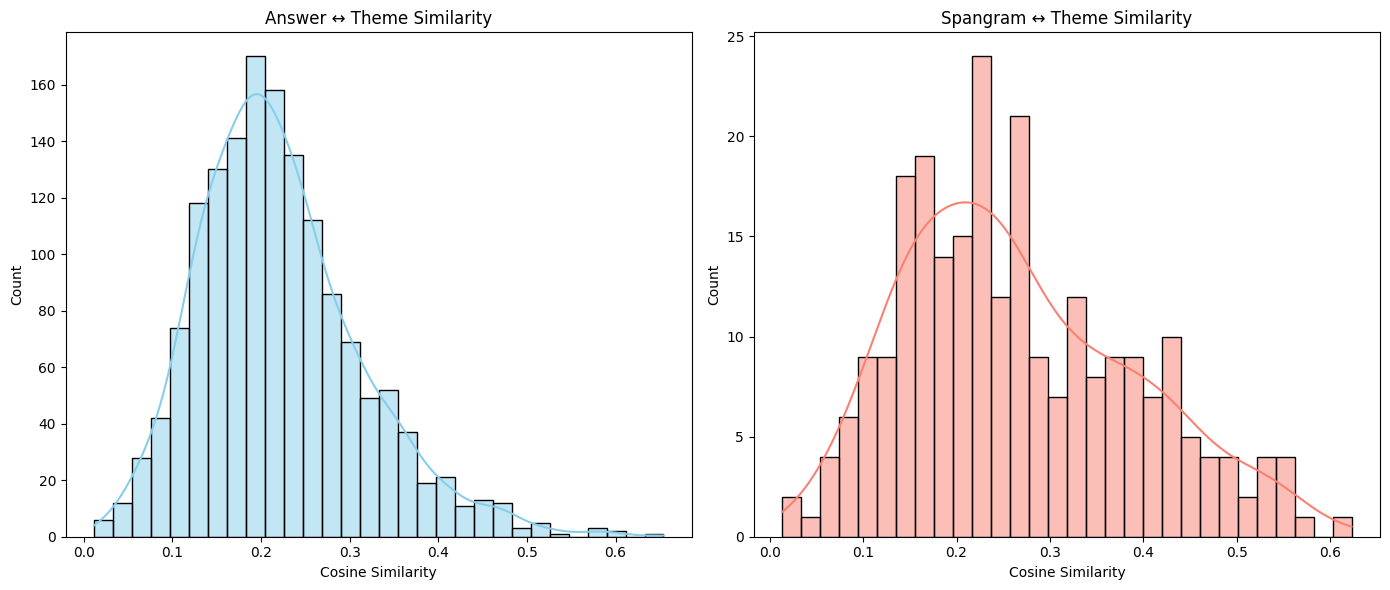

🔍 Similarity Averages:
Average Answer ↔ Theme similarity: 0.221
Average Spangram ↔ Theme similarity: 0.266


In [ ]:

model = SentenceTransformer("all-MiniLM-L6-v2")

def parse_answers(s):
    if pd.isna(s): return []
    return [word.strip() for word in s.split(",") if word.strip()]

df = df[df["Answers"].notna() & df["Theme"].notna()]
df = df[df["Answers"].str.strip() != ""]
df["AnswersParsed"] = df["Answers"].apply(parse_answers)
df = df[df["AnswersParsed"].apply(len) > 0]

answer_similarities = []
spangram_similarities = []

for _, row in df.iterrows():
    theme = row["Theme"]
    theme_emb = model.encode(theme)

    #Spangram similarity
    spangram = str(row["Spangram"]).strip()
    if spangram:
        sp_emb = model.encode(spangram)
        spangram_similarities.append(cosine_similarity([sp_emb], [theme_emb])[0][0])

    #Answer similarities
    for word in row["AnswersParsed"]:
        w_emb = model.encode(word)
        sim = cosine_similarity([w_emb], [theme_emb])[0][0]
        answer_similarities.append(sim)

avg_answer_sim = np.mean(answer_similarities)
avg_spangram_sim = np.mean(spangram_similarities)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(answer_similarities, kde=True, color="skyblue", bins=30)
plt.title("Answer ↔ Theme Similarity")
plt.xlabel("Cosine Similarity")

plt.subplot(1, 2, 2)
sns.histplot(spangram_similarities, kde=True, color="salmon", bins=30)
plt.title("Spangram ↔ Theme Similarity")
plt.xlabel("Cosine Similarity")

plt.tight_layout()
plt.show()


print("🔍 Similarity Averages:")
print(f"Average Answer ↔ Theme similarity: {avg_answer_sim:.3f}")
print(f"Average Spangram ↔ Theme similarity: {avg_spangram_sim:.3f}")


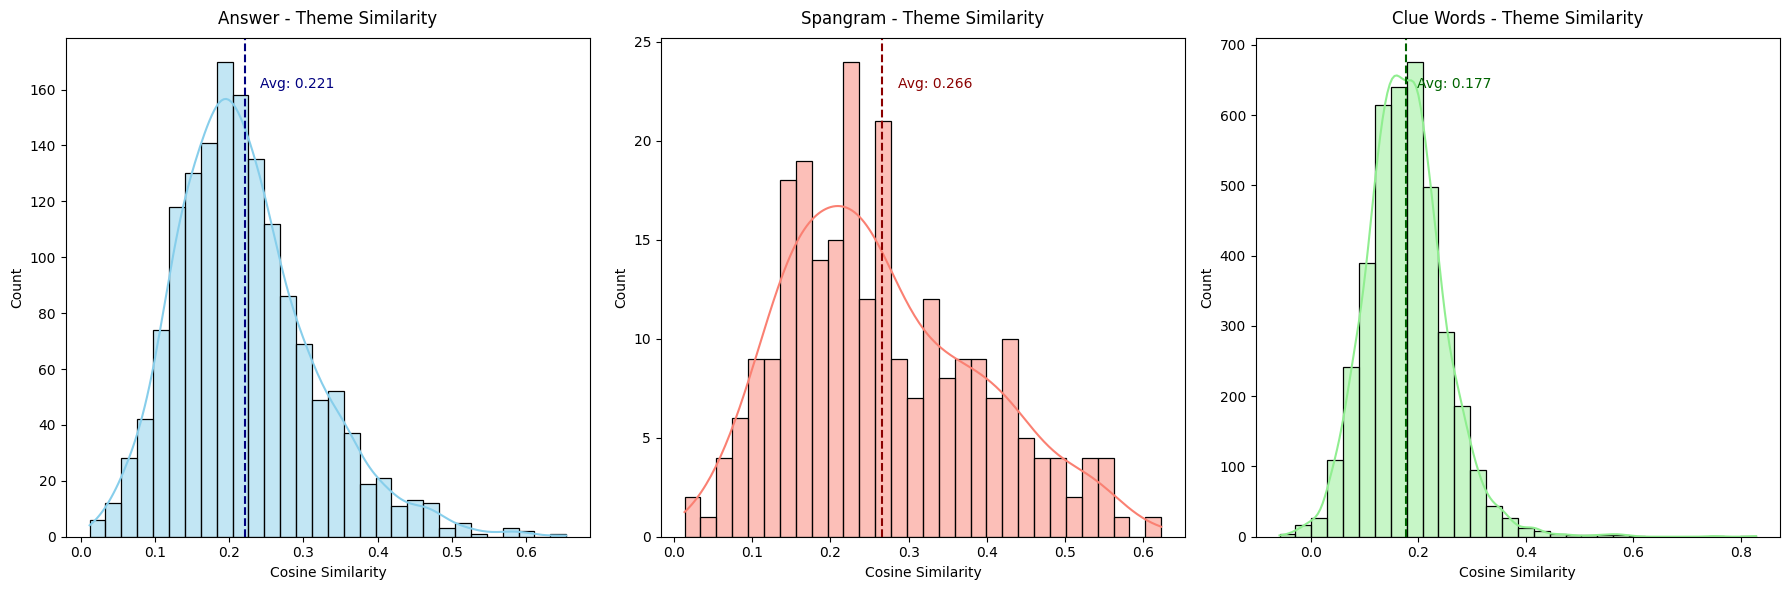

🔍 Similarity Averages:
Average Answer - Theme similarity: 0.221
Average Spangram - Theme similarity: 0.266
Average Clue - Theme similarity: 0.177

🔬 Similarity Comparison:
Answers vs Clues difference: 0.044 (24.6% higher)


In [ ]:

model = SentenceTransformer("all-MiniLM-L6-v2")


def parse_words(s):
    if pd.isna(s): return []
    return [word.strip() for word in s.split(",") if word.strip()]

df = df[df["Answers"].notna() & df["Theme"].notna() & df["ClueWords"].notna()]
df = df[df["Answers"].str.strip() != ""]
df["AnswersParsed"] = df["Answers"].apply(parse_words)
df["ClueWordsParsed"] = df["ClueWords"].apply(parse_words)
df = df[df["AnswersParsed"].apply(len) > 0]

answer_similarities = []
spangram_similarities = []
clue_similarities = []

for _, row in df.iterrows():
    theme = row["Theme"]
    theme_emb = model.encode(theme)

    #Spangram similarity
    spangram = str(row["Spangram"]).strip()
    if spangram:
        sp_emb = model.encode(spangram)
        spangram_similarities.append(cosine_similarity([sp_emb], [theme_emb])[0][0])

    #Answer similarities
    for word in row["AnswersParsed"]:
        w_emb = model.encode(word)
        sim = cosine_similarity([w_emb], [theme_emb])[0][0]
        answer_similarities.append(sim)

    #Clue word similarities
    for word in row["ClueWordsParsed"]:
        w_emb = model.encode(word)
        sim = cosine_similarity([w_emb], [theme_emb])[0][0]
        clue_similarities.append(sim)


avg_answer_sim = np.mean(answer_similarities)
avg_spangram_sim = np.mean(spangram_similarities)
avg_clue_sim = np.mean(clue_similarities)


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(answer_similarities, kde=True, color="skyblue", bins=30)
plt.title("Answer - Theme Similarity", pad=10)
plt.xlabel("Cosine Similarity")
plt.axvline(avg_answer_sim, color='navy', linestyle='--')
plt.text(avg_answer_sim+0.02, plt.ylim()[1]*0.9, f'Avg: {avg_answer_sim:.3f}', color='navy')

plt.subplot(1, 3, 2)
sns.histplot(spangram_similarities, kde=True, color="salmon", bins=30)
plt.title("Spangram - Theme Similarity", pad=10)
plt.xlabel("Cosine Similarity")
plt.axvline(avg_spangram_sim, color='darkred', linestyle='--')
plt.text(avg_spangram_sim+0.02, plt.ylim()[1]*0.9, f'Avg: {avg_spangram_sim:.3f}', color='darkred')

plt.subplot(1, 3, 3)
sns.histplot(clue_similarities, kde=True, color="lightgreen", bins=30)
plt.title("Clue Words - Theme Similarity", pad=10)
plt.xlabel("Cosine Similarity")
plt.axvline(avg_clue_sim, color='darkgreen', linestyle='--')
plt.text(avg_clue_sim+0.02, plt.ylim()[1]*0.9, f'Avg: {avg_clue_sim:.3f}', color='darkgreen')

plt.tight_layout()
plt.show()

# Print summary
print("Similarity Averages:")
print(f"Average Answer - Theme similarity: {avg_answer_sim:.3f}")
print(f"Average Spangram - Theme similarity: {avg_spangram_sim:.3f}")
print(f"Average Clue - Theme similarity: {avg_clue_sim:.3f}")

# Statistical comparison
print("\nSimilarity Comparison:")
print(f"Answers vs Clues difference: {avg_answer_sim - avg_clue_sim:.3f} "
      f"({(avg_answer_sim/avg_clue_sim-1)*100:.1f}% higher)")

In [ ]:
answer_spangram_similarities = []

for _, row in df.iterrows():
    theme = str(row["Theme"]).strip()
    if not theme:
        continue

    theme_emb = model.encode(theme)
    spangram = str(row["Spangram"]).strip()
    if not spangram:
        continue

    sp_emb = model.encode(spangram)
    spangram_similarities.append(cosine_similarity([sp_emb], [theme_emb])[0][0])


    for word in row["AnswersParsed"]:
        w_emb = model.encode(word)
        answer_sim = cosine_similarity([w_emb], [theme_emb])[0][0]
        sp_sim = cosine_similarity([w_emb], [sp_emb])[0][0]
        answer_similarities.append(answer_sim)
        answer_spangram_similarities.append(sp_sim)


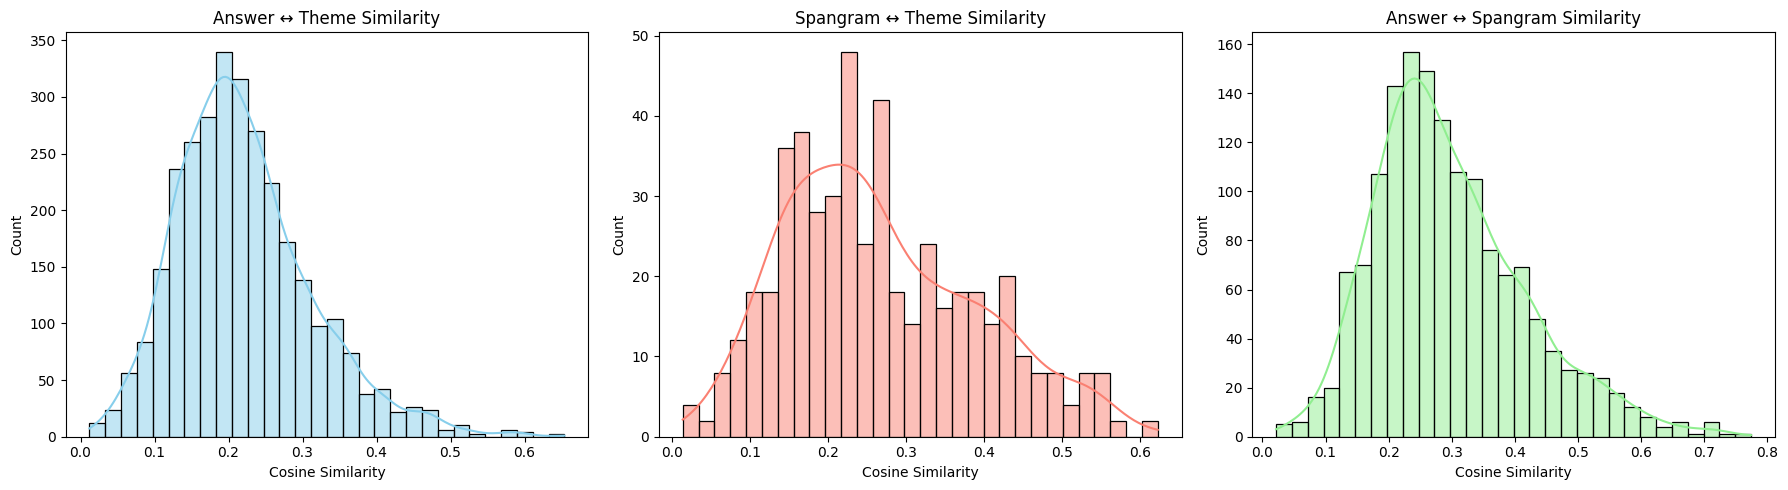

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(answer_similarities, kde=True, bins=30, color="skyblue")
plt.title("Answer ↔ Theme Similarity")
plt.xlabel("Cosine Similarity")

plt.subplot(1, 3, 2)
sns.histplot(spangram_similarities, kde=True, bins=30, color="salmon")
plt.title("Spangram ↔ Theme Similarity")
plt.xlabel("Cosine Similarity")

plt.subplot(1, 3, 3)
sns.histplot(answer_spangram_similarities, kde=True, bins=30, color="lightgreen")
plt.title("Answer ↔ Spangram Similarity")
plt.xlabel("Cosine Similarity")

plt.tight_layout()
plt.show()


In [ ]:
print("Similarity Averages:")
print(f"Avg Answer ↔ Theme:       {np.mean(answer_similarities):.3f}")
print(f"Avg Spangram ↔ Theme:     {np.mean(spangram_similarities):.3f}")
print(f"Avg Answer ↔ Spangram:    {np.mean(answer_spangram_similarities):.3f}")


🔍 Similarity Averages:
Avg Answer ↔ Theme:       0.221
Avg Spangram ↔ Theme:     0.266
Avg Answer ↔ Spangram:    0.297


In [ ]:


df = df[df["Answers"].notna() & df["Theme"].notna()]
df = df[df["Answers"].str.strip() != ""]

model = SentenceTransformer('all-MiniLM-L6-v2')

min_sim = 1.0

for _, row in df.iterrows():
    theme = row["Theme"]
    theme_emb = model.encode([theme])

    answers = [w.strip() for w in row["Answers"].split(",") if w.strip()]
    if isinstance(row.get("Spangram"), str) and row["Spangram"].strip():
        answers.append(row["Spangram"].strip())

    if not answers:
        continue

    answer_embs = model.encode(answers)
    sims = cosine_similarity(answer_embs, theme_emb).flatten()
    row_min = sims.min()
    if row_min < min_sim:
        min_sim = row_min

print(f"Minimum similarity found: {min_sim:.4f}")


Minimum similarity found: 0.0120


In [ ]:


def build_custom_vocab(df):
    all_words = set()

    for _, row in df.iterrows():

        all_words.update([w.strip().lower() for w in str(row["ClueWords"]).split(",") if w.strip()])
        all_words.update([w.strip().lower() for w in str(row["Answers"]).split(",") if w.strip()])
        spangram = str(row["Spangram"]).strip().lower()
        if spangram:
            all_words.add(spangram)

    filtered_vocab = {word for word in all_words if word and word != "n/a"}

    return filtered_vocab

custom_vocab = build_custom_vocab(df)
print(f"Custom vocab size (filtered): {len(custom_vocab)}")

Custom vocab size (filtered): 3390


In [ ]:
def build_trie(words):
    class TrieNode:
        def __init__(self):
            self.children = {}
            self.is_word = False
    root = TrieNode()
    for w in words:
        node = root
        for ch in w.lower():
            node = node.children.setdefault(ch, TrieNode())
        node.is_word = True
    return root

def find_words_with_paths(grid, dictionary=custom_vocab, min_length=4):
    rows, cols = len(grid), len(grid[0])
    dirs = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
    found = set()
    trie = build_trie(dictionary)

    def dfs(x, y, visited, node, word, path):
        if node.is_word and len(word) >= min_length:
            found.add((word, tuple(path)))

        for dx, dy in dirs:
            nx, ny = x+dx, y+dy
            if 0<=nx<rows and 0<=ny<cols and (nx,ny) not in visited:
                ch = grid[nx][ny].lower()
                if ch in node.children:
                    dfs(nx, ny, visited | {(nx,ny)}, node.children[ch], word + ch, path + [(nx,ny)])

    for i in range(rows):
        for j in range(cols):
            ch = grid[i][j].lower()
            if ch in trie.children:
                dfs(i, j, {(i,j)}, trie.children[ch], ch, [(i,j)])
    return found

def is_spangram_path(path, rows=6, cols=8):
    x_coords = [x for x, _ in path]
    y_coords = [y for _, y in path]
    return (0 in y_coords and cols-1 in y_coords) or (0 in x_coords and rows-1 in x_coords)

In [ ]:
def extract_ml_rows_from_puzzle(row, model, english_dict=custom_vocab):
    rows = []
    try:
        grid_and_paths = json.loads(row["Grid"])
        grid = grid_and_paths[0]  # 8x6 letter grid
        grid_np = np.array(grid)

        answers = set(w.strip().lower() for w in row["Answers"].split(","))
        spangram = row["Spangram"].strip().lower()
        clues = set(w.strip().lower() for w in row["ClueWords"].split(","))

        theme = row["Theme"]
        theme_emb = model.encode([theme])

        candidates = find_words_with_paths(grid_np, custom_vocab, min_length=4)

        for word, path in candidates:
            word_lc = word.lower()
            label = int(word_lc in answers or word_lc == spangram)
            in_clues = int(word_lc in clues)
            in_dict = int(word_lc in custom_vocab)
            is_span_path = int(is_spangram_path(path, rows=8, cols=6))
            cos_sim = cosine_similarity(model.encode([word_lc]), theme_emb)[0][0]
            center_x = 6/2
            center_y = 8/2
            avg_x = np.mean([x for x,_ in path])
            avg_y = np.mean([y for _,y in path])
            distance_from_center = np.sqrt((avg_x-center_x)**2 + (avg_y-center_y)**2)


            unique_directions = len(set((x2-x1,y2-y1) for (x1,y1),(x2,y2) in zip(path[:-1],path[1:])))
            turns = sum(1 for i in range(1,len(path)-1) if (path[i][0]-path[i-1][0],path[i][1]-path[i-1][1]) != (path[i+1][0]-path[i][0],path[i+1][1]-path[i][1]))


            rows.append({
                "PuzzleNumber": row["PuzzleNumber"],
                "Theme": theme,
                "Word": word_lc,
                "cos_sim": cos_sim,
                "length": len(word),
                "in_clues": in_clues,
                "is_spangram_candidate": is_span_path,
                "distance_from_center": distance_from_center,
                "unique_directions": unique_directions,
                "turns": turns,
                "label": label
            })

    except Exception as e:
        print(f"Puzzle {row['PuzzleNumber']} skipped: {e}")
    return rows


In [ ]:
all_rows = []
for r in df.itertuples():
    all_rows.extend(extract_ml_rows_from_puzzle(r._asdict(), model, custom_vocab))

ml_df = pd.DataFrame(all_rows)
print(f"ML dataset shape: {ml_df.shape}")
ml_df.to_csv("nyt_strands_ml_dataset.csv", index=False)


❌ Puzzle 482 skipped: 'float' object is not subscriptable
✅ ML dataset shape: (70586, 11)


In [ ]:


ml_df = ml_df.drop_duplicates(subset=['PuzzleNumber', 'Word'])
print(f"ML dataset shape after dropping duplicates: {ml_df.shape}")
ml_df.to_csv("nyt_strands_ml_dataset_unique.csv", index=False)


✅ ML dataset shape after dropping duplicates: (37423, 11)


In [ ]:
print(custom_vocab)
print(english_dictionary)

{'wean', 'nicecomeback', 'glistening', 'sparkle', 'pore', 'verse', 'dory', 'burn', 'stack', 'tare', 'real', 'crocodile', 'nachos', 'nole', 'mustard', 'olympics', 'princess', 'meek', 'buckwheat', 'taker', 'cheer', 'pierogi', 'sheriff', 'bred', 'talcum', 'suit', 'helmet', 'diamond', 'rest', 'canasta', 'granola', 'engineer', 'busy', 'mare', 'gear', 'coffee', 'espresso', 'carls', 'yucky', 'frags', 'wound', 'child', 'glasses', 'bumblebee', 'parasite', 'club', 'fits', 'rifts', 'night', 'push', 'viscount', 'teeter', 'marm', 'bound', 'scooter', 'jewelry', 'foul', 'rose', 'scam', 'value', 'skew', 'dryer', 'boxes', 'slog', 'angle', 'appointment', 'snookums', 'apples', 'melt', 'rugs', 'shad', 'ming', 'gloomy', 'peach', 'jeer', 'mine', 'grandchild', 'relate', 'firs', 'characters', 'underpants', 'ends', 'toys', 'poppy', 'poor', 'alien', 'superbowl', 'later', 'carbody', 'discovery', 'among', 'sled', 'folk', 'glove', 'grate', 'mandolin', 'stride', 'darn', 'rode', 'gremlin', 'bale', 'tool', 'ween', 'c

In [ ]:

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/my_data/nyt_strands_ml_dataset_unique.csv")
print(f"Total candidates: {len(df)}")
#drop score column
df = df.drop(columns=['score'])
print(df.head())


Total candidates: 37423


KeyError: "['score'] not found in axis"

In [ ]:
ml_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/my_data/nyt_strands_ml_dataset_unique.csv")
print(f"Total candidates: {len(ml_df)}")

Total candidates: 37423


In [ ]:
print(ml_df['label'].value_counts(normalize=True))  # should be ~10-15% positives


label
0    0.95297
1    0.04703
Name: proportion, dtype: float64


In [ ]:
unique_puzzles = ml_df['PuzzleNumber'].unique()
train_ids, test_ids = train_test_split(unique_puzzles, test_size=0.2, random_state=13)

train_df = ml_df[ml_df['PuzzleNumber'].isin(train_ids)]
test_df  = ml_df[ml_df['PuzzleNumber'].isin(test_ids)]

print(f"Train puzzles: {len(train_ids)}, Test puzzles: {len(test_ids)}")


Train puzzles: 200, Test puzzles: 50


In [ ]:


features = ["cos_sim", "length", "is_spangram_candidate", "distance_from_center", "unique_directions", "turns"]
X_train = train_df[features]
y_train = train_df["label"]

# from imblearn.ensemble import BalancedRandomForestClassifier
# clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=3,
    random_state=13
)

clf.fit(X_train, y_train)
# # normalize length & cos_sim to [0,1]
# w_len = X_train["length"] / X_train["length"].max()
# w_cos = X_train["cos_sim"] / X_train["cos_sim"].max()

# # combine into a single sample_weight (you can tune the exponents or mix)
# sample_weight = w_len * w_cos

# # train with these sample‑weights
# clf = LogisticRegression(max_iter=1000)
# clf.fit(X_train, y_train, sample_weight=sample_weight)


clf.feature_names_in_ = np.array(features)

X_test = test_df[features]
y_test = test_df["label"]



In [ ]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7207
           1       0.86      0.60      0.71       342

    accuracy                           0.98      7549
   macro avg       0.92      0.80      0.85      7549
weighted avg       0.98      0.98      0.98      7549

ROC AUC: 0.9520


In [ ]:
ml_df["score"] = clf.predict_proba(ml_df[features])[:, 1]
ml_df = ml_df.drop(columns=['in_clues'])
ml_df.to_csv("nyt_strands_ml_dataset_with_scores.csv", index=False)



In [ ]:
def score_words(df_group):
    df = df_group.copy()


    min_score = df['score'].min()
    max_score = df['score'].max()
    if max_score > min_score:
        df['normalized_score'] = (df['score'] - min_score) / (max_score - min_score)
    else:
        df['normalized_score'] = 0.5
    return df

test_df = test_df.reset_index(drop=True)


test_df = test_df.groupby('PuzzleNumber', group_keys=False).apply(score_words)


def final_scoring(row):
    base_score = row['normalized_score']
    if row['is_spangram_candidate']:
        base_score *= 1.3
    if not row['in_clues']:
        base_score *= 0.8
    return base_score

test_df['final_score'] = test_df.apply(final_scoring, axis=1)

top7 = (test_df.groupby('PuzzleNumber', group_keys=False)
               .apply(lambda g: g.nlargest(7, 'final_score')))


precision_at_7 = top7['label'].mean()
print(f"Precision@7: {precision_at_7:.3f}")

🎯 Precision@7: 0.697


/tmp/ipython-input-27-554940577.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby('PuzzleNumber', group_keys=False).apply(score_words)
/tmp/ipython-input-27-554940577.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(7, 'final_score')))


In [ ]:
test_df["score"] = y_proba
top7 = test_df.groupby("PuzzleNumber").apply(lambda g: g.sort_values("score", ascending=False).head(7))
precision_at_7 = top7["label"].mean()
print(f"🎯 Precision@7: {precision_at_7:.3f}")


🎯 Precision@7: 0.697


/tmp/ipython-input-28-2597757934.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top7 = test_df.groupby("PuzzleNumber").apply(lambda g: g.sort_values("score", ascending=False).head(7))


/tmp/ipython-input-29-2427762524.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_importance, y=sorted_features, palette="viridis")


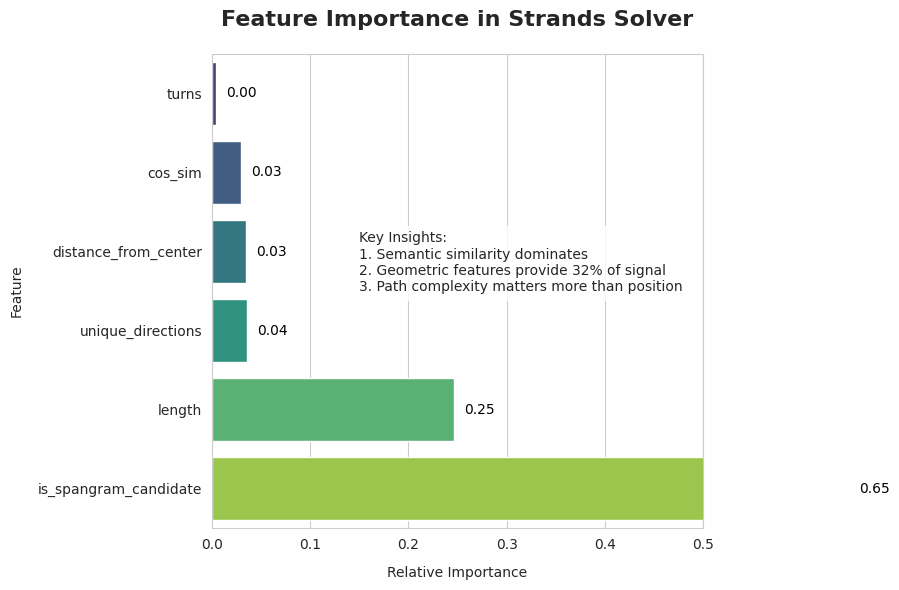

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


importance = clf.feature_importances_
features = clf.feature_names_in_

sorted_idx = np.argsort(importance)
sorted_features = [features[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=sorted_importance, y=sorted_features, palette="viridis")


plt.title("Feature Importance in Strands Solver", pad=20, fontsize=16, fontweight='bold')
plt.xlabel("Relative Importance", labelpad=10)
plt.ylabel("Feature", labelpad=10)
plt.xlim(0, 0.5)


for i, v in enumerate(sorted_importance):
    ax.text(v + 0.01, i, f"{v:.2f}", color='black', va='center', fontsize=10)


plt.text(0.3, 0.5,
         "Key Insights:\n"
         "1. Semantic similarity dominates\n"
         "2. Geometric features provide 32% of signal\n"
         "3. Path complexity matters more than position",
         transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df = pd.read_csv("nyt_strands_filtered_numbered.csv")


In [ ]:
def touches_opposite_edges(path, rows=8, cols=6):
    rows_touched = {x for x, _ in path}
    cols_touched = {y for _, y in path}
    return (0 in rows_touched and rows - 1 in rows_touched) or \
           (0 in cols_touched and cols - 1 in cols_touched)


In [ ]:
def predict_and_eval_with_grid(row, grid):
    import json
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity


    theme = row["Theme"]
    cluewords = {w.strip().lower() for w in row["ClueWords"].split(",") if w.strip()}
    true_sp = row["Spangram"].strip().lower()
    true_answers = {w.strip().lower() for w in row["Answers"].split(",") if w.strip()}
    N = int(row["NumAnswers"])
    rows, cols = len(grid), len(grid[0])


    center_x, center_y = cols/2, rows/2

    candidates = find_words_with_paths(grid, custom_vocab, min_length=4)
    if not candidates:
        return None


    theme_emb = model.encode([theme])
    recs = []

    for word, path in candidates:
        w = word.lower()
        path_coords = np.array(path)
        sim = cosine_similarity(model.encode([w]), theme_emb)[0][0]
        is_sp = int(touches_opposite_edges(path, rows, cols))

        avg_x = np.mean(path_coords[:, 0])
        avg_y = np.mean(path_coords[:, 1])
        distance_from_center = np.sqrt((avg_x-center_x)**2 + (avg_y-center_y)**2)

        directions = []
        for (x1,y1),(x2,y2) in zip(path[:-1], path[1:]):
            dx, dy = x2-x1, y2-y1
            directions.append((dx, dy))
        unique_directions = len(set(directions))

        turns = 0
        for i in range(1, len(directions)):
            if directions[i] != directions[i-1]:
                turns += 1

        recs.append({
            "word": w,
            "path": path,
            "cos_sim": sim,
            "length": len(w),
            # "in_clues": int(w in cluewords),
            "is_spangram_candidate": is_sp,
            "distance_from_center": distance_from_center,
            "unique_directions": unique_directions,
            "turns": turns
        })

    df_feat = pd.DataFrame(recs)
    feature_cols = ["cos_sim", "length",
                   "is_spangram_candidate", "distance_from_center",
                   "unique_directions", "turns"]


    df_feat = df_feat[df_feat["cos_sim"] >= min_sim]
    if df_feat.empty:
        return None

    X = df_feat[feature_cols].to_numpy()
    df_feat["raw_score"] = clf.predict_proba(X)[:,1]

    min_score = df_feat["raw_score"].min()
    max_score = df_feat["raw_score"].max()
    if max_score > min_score:
        df_feat["normalized_score"] = (df_feat["raw_score"] - min_score) / (max_score - min_score)
    else:
        df_feat["normalized_score"] = 0.5

    # Apply scoring rules
    def final_score(row):
        base = row["normalized_score"]
        if row["is_spangram_candidate"]:
            base *= 1.3
        # if not row["in_clues"]:
        #     base *= 0.8  # Penalize words not in clues
        return base

    df_feat["final_score"] = df_feat.apply(final_score, axis=1)


    sp_cands = df_feat[df_feat["is_spangram_candidate"]==1]
    if not sp_cands.empty:
        best_sp = sp_cands.nlargest(1, "final_score").iloc[0]
        pred_sp, sp_path = best_sp["word"], best_sp["path"]
    else:
        pred_sp, sp_path = None, None


    non_sp = df_feat[df_feat["word"] != pred_sp] if pred_sp else df_feat
    unique_answers = []
    answer_paths = []

    for _, candidate in non_sp.sort_values("final_score", ascending=False).iterrows():
        if candidate["word"] not in unique_answers:
            unique_answers.append(candidate["word"])
            answer_paths.append(candidate["path"])
            if len(unique_answers) >= N:
                break

    ans_correct = len(set(unique_answers) & true_answers)
    precision_at_N = ans_correct / N if N > 0 else 0.0
    sp_accuracy = int(pred_sp == true_sp) if pred_sp else 0

    return {
        "PuzzleNumber": row["PuzzleNumber"],
        "true_spangram": true_sp,
        "pred_spangram": pred_sp,
        "sp_accuracy": sp_accuracy,
        "true_answers": true_answers,
        "pred_answers": unique_answers,
        "precision_at_N": precision_at_N,
        "spangram_path": sp_path,
        "answer_paths": answer_paths,
        "features_used": feature_cols
    }

In [ ]:
import json, ast

test_row = df.iloc[0]
raw = test_row["Grid"]
try:
    grid_data = json.loads(raw)
except:
    grid_data = ast.literal_eval(raw)
if (
    isinstance(grid_data, list)
    and grid_data
    and isinstance(grid_data[0], list)
    and isinstance(grid_data[0][0], list)
):
    grid = grid_data[0]
else:
    grid = grid_data


result = predict_and_eval_with_grid(test_row, grid)

print(f"Puzzle #{result['PuzzleNumber']}")
print(f" True spangram:      {result['true_spangram']}")
print(f" Predicted spangram: {result['pred_spangram']}  (Accuracy={result['sp_accuracy']})")
print(f" True answers:       {sorted(result['true_answers'])}")
print(f" Pred answers:       {result['pred_answers']}  (Precision@N={result['precision_at_N']:.2f})")


print("\nGrid with predicted paths:")
marked = [[' ' + ch for ch in row] for row in grid]

if result["spangram_path"]:
    for r, c in result["spangram_path"]:
        marked[r][c] = '[' + marked[r][c].strip() + ']'


for path in result["answer_paths"]:
    for r, c in path:
        cell = marked[r][c]
        if cell.startswith('[') and cell.endswith(']'):
            marked[r][c] = '<' + cell[1:-1] + '>'
        else:
            marked[r][c] = '<' + cell.strip() + '>'

for row in marked:
    print("".join(row))


Puzzle #116
 True spangram:      combomeals
 Predicted spangram: combomeals  (Accuracy=1)
 True answers:       ['biscuits', 'burger', 'cheese', 'fries', 'gravy', 'macaroni']
 Pred answers:       ['macaroni', 'biscuits', 'cheese', 'earrings', 'strong', 'burger']  (Precision@N=0.67)

Grid with predicted paths:
[C][O][M][B][O][M]
 F[S][L][A][E]<B>
 R I E S<U><R>
<B><I><R><E><G><<<S>>>
<S><C><U><I><<T>><<G>>
<M> Y V A<<R>><<<N>>>
<A><C><<A>><<R>><<O>><<I>>
<C><H><<E>><E><S><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import json
import ast
import pandas as pd
from tqdm import tqdm

def safe_parse_grid(grid_str):
    """Helper function to safely parse grid data"""
    try:
        grid_data = json.loads(grid_str)
    except:
        grid_data = ast.literal_eval(grid_str)

    if (isinstance(grid_data, list) and grid_data and isinstance(grid_data[0], list)):
        if isinstance(grid_data[0][0], list):
            return grid_data[0]
    return grid_data

def visualize_grid(grid, spangram_path=None, answer_paths=None):
    """Visualize grid with marked paths"""
    marked = [[' ' + ch for ch in row] for row in grid]

    if spangram_path:
        for r, c in spangram_path:
            marked[r][c] = '[' + marked[r][c].strip() + ']'


    if answer_paths:
        for path in answer_paths:
            for r, c in path:
                cell = marked[r][c]
                if cell.startswith('[') and cell.endswith(']'):
                    marked[r][c] = '<' + cell[1:-1] + '>'
                else:
                    marked[r][c] = '<' + cell.strip() + '>'

    return '\n'.join(''.join(row) for row in marked)


all_results = []
metrics = {
    'total_puzzles': 0,
    'correct_spangrams': 0,
    'total_answers': 0,
    'correct_answers': 0,
    'perfect_puzzles': 0
}

for _, test_row in tqdm(df.iterrows(), total=len(df), desc="Evaluating puzzles"):
    try:

        grid = safe_parse_grid(test_row["Grid"])
        if not grid or not isinstance(grid, list):
            continue

        result = predict_and_eval_with_grid(test_row, grid)
        if not result:
            continue


        all_results.append(result)
        metrics['total_puzzles'] += 1
        metrics['correct_spangrams'] += result['sp_accuracy']
        metrics['total_answers'] += len(result['true_answers'])
        metrics['correct_answers'] += len(set(result['pred_answers']) & set(result['true_answers']))

        if result['sp_accuracy'] and (len(set(result['pred_answers']) & set(result['true_answers'])) == len(result['true_answers'])):
            metrics['perfect_puzzles'] += 1


        print(f"\nPuzzle #{result['PuzzleNumber']} - {test_row['Theme']}")
        print(f" True spangram:      {result['true_spangram']}")
        print(f" Predicted spangram: {result['pred_spangram']}  (Correct: {bool(result['sp_accuracy'])})")
        print(f" True answers:       {sorted(result['true_answers'])}")
        print(f" Pred answers:       {result['pred_answers']}  (Precision: {result['precision_at_N']:.2f})")
        print("\nGrid visualization:")
        print(visualize_grid(grid, result['spangram_path'], result['answer_paths']))

    except Exception as e:
        print(f"\nError processing puzzle {test_row.get('PuzzleNumber', '?')}: {str(e)}")
        continue


if metrics['total_puzzles'] > 0:
    spangram_accuracy = metrics['correct_spangrams'] / metrics['total_puzzles']
    answer_precision = metrics['correct_answers'] / metrics['total_answers'] if metrics['total_answers'] > 0 else 0
    perfect_rate = metrics['perfect_puzzles'] / metrics['total_puzzles']

    print("\n\n=== Aggregate Metrics ===")
    print(f"Total puzzles evaluated: {metrics['total_puzzles']}")
    print(f"Spangram accuracy:      {spangram_accuracy:.2%}")
    print(f"Answer precision:       {answer_precision:.2%}")
    print(f"Perfect puzzle rate:    {perfect_rate:.2%} (got both spangram and all answers correct)")


    results_df = pd.DataFrame(all_results)
    results_df.to_csv("puzzle_evaluation_results.csv", index=False)
else:
    print("No puzzles were successfully evaluated.")

Evaluating puzzles:   0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   0%|          | 1/251 [00:05<22:01,  5.29s/it]


Puzzle #116 - Better together
 True spangram:      combomeals
 Predicted spangram: combomeals  (Correct: True)
 True answers:       ['biscuits', 'burger', 'cheese', 'fries', 'gravy', 'macaroni']
 Pred answers:       ['macaroni', 'biscuits', 'cheese', 'earrings', 'strong', 'burger']  (Precision: 0.67)

Grid visualization:
[C][O][M][B][O][M]
 F[S][L][A][E]<B>
 R I E S<U><R>
<B><I><R><E><G><<<S>>>
<S><C><U><I><<T>><<G>>
<M> Y V A<<R>><<<N>>>
<A><C><<A>><<R>><<O>><<I>>
<C><H><E><<E>><S><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   1%|          | 2/251 [00:14<30:48,  7.42s/it]


Puzzle #118 - It's way over your head
 True spangram:      outerspace
 Predicted spangram: outerspace  (Correct: True)
 True answers:       ['asteroid', 'comet', 'galaxy', 'moon', 'planet', 'satellite']
 Pred answers:       ['asteroid', 'planet', 'satellite', 'galaxy', 'galette', 'relate']  (Precision: 0.67)

Grid visualization:
[O][U][T][E][R][S]
 M[E][C][A][P] C
 O O N M O<P>
<<T>><T><E><A><L><<G>>
<Y><<E>><N><<L>><<A>><A>
<O><X><A><T><<S>> S
<I><<R>><<E>><<L>><<A>><<T>>
<D><E><T><I><L><<E>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   1%|          | 3/251 [00:18<25:14,  6.11s/it]


Puzzle #119 - Cut and color
 True spangram:      jeweltones
 Predicted spangram: jeweltones  (Correct: True)
 True answers:       ['amethyst', 'emerald', 'garnet', 'ruby', 'sapphire', 'topaz']
 Pred answers:       ['amethyst', 'emerald', 'garnet', 'sapphire', 'topaz', 'jersey']  (Precision: 0.83)

Grid visualization:
<J><E>[W][E][L][T]
<R><S><E>[N]<O><T>
 U B<Y><P> O<E>
<L><Z><A><E><M><G>
<D><A><R><R><A><A>
<T><E><N><E><M><S>
<Y><H><T><P><A><R>
<S><T><P><H><I><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   2%|▏         | 4/251 [00:21<19:38,  4.77s/it]


Puzzle #120 - We've got the beat
 True spangram:      percussion
 Predicted spangram: tambourine  (Correct: False)
 True answers:       ['cymbal', 'drum', 'gong', 'rattle', 'tambourine', 'triangle']
 Pred answers:       ['percussion', 'triangle', 'cymbal', 'rattle', 'drum', 'orange']  (Precision: 0.67)

Grid visualization:
<P><E><R><C><U><S>
 G<N><O><I><S><D>
 O N G<U><R><C>
<L><A><M><M><Y><R>
<E><L><B><T><A> T
<<G>><<N>><T><I><R><T>
<L><E><<A>>[U][A][M]
<E>[N][I]<R><O>[B]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   2%|▏         | 5/251 [00:26<19:40,  4.80s/it]


Puzzle #121 - Heat and eat
 True spangram:      cooking
 Predicted spangram: cooking  (Correct: True)
 True answers:       ['blanch', 'braise', 'deglaze', 'flambe', 'poach', 'simmer', 'steam']
 Pred answers:       ['deglaze', 'braise', 'steam', 'health', 'flambe', 'stars', 'blares']  (Precision: 0.57)

Grid visualization:
[C][O][O][K][I][N]
 P O A C[G]<<S>>
 S M<H><<E>><<<T>>><B>
 I<M><A><<<A>>><<L>><H>
 M<E><<R>> N C<B>
<E><<<S>>><I><A><R><D>
<Z><A><L><G><E><F>
 E<<E>><B><M><A><L>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   2%|▏         | 6/251 [00:32<20:57,  5.13s/it]


Puzzle #122 - Spin your wheels
 True spangram:      bicycle
 Predicted spangram: kickstand  (Correct: False)
 True answers:       ['brake', 'chain', 'fender', 'frame', 'kickstand', 'pedal', 'saddle']
 Pred answers:       ['bicycle', 'reeled', 'pedal', 'fender', 'trick', 'lader', 'tired']  (Precision: 0.29)

Grid visualization:
<B><I><C><Y><C><L>
 F<R> A M<E> C
 B N<E> A H<P>
<R> A I<<D>><<E>> S
 K<E><A><<L>><A><D>
<F><E><E><L> D<K>
<N><<D>><<E>><<<R>>><<I>><C>
[D][N][A]<<T>>[S][K]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   3%|▎         | 7/251 [00:38<22:40,  5.58s/it]


Puzzle #124 - Say something
 True spangram:      articulation
 Predicted spangram: articulation  (Correct: True)
 True answers:       ['declare', 'express', 'sign', 'speak', 'talk', 'tell', 'utter']
 Pred answers:       ['declare', 'spell', 'speak', 'talk', 'tell', 'apples', 'steel']  (Precision: 0.57)

Grid visualization:
[A][R][T][I][C][U]
[O][I][T][A][L] S
[N]<T> N G I<<T>>
<A><<L>> K<<<L>>><<<E>>><<<S>>>
 U<<K>><<L>><<<E>>><<<P>>> E
 T T<<A>><P> X<S>
<E><R> R E S<D>
 E R<A><L><C><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   3%|▎         | 8/251 [00:45<23:52,  5.89s/it]


Puzzle #126 - Not just black and white
 True spangram:      grayscale
 Predicted spangram: grayscale  (Correct: True)
 True answers:       ['charcoal', 'flint', 'graphite', 'platinum', 'slate', 'steel']
 Pred answers:       ['charcoal', 'graphite', 'platinum', 'greatest', 'captain', 'nills']  (Precision: 0.50)

Grid visualization:
<G><R>[A][Y]<S>[C]
<S><T><E><L>[A] S
 E<E> L<A><L> F
<C> E<T><I> L<L>
<H> T<N><O><A><G>
<A><R><<C>><<A>><R><P>
<I><H><<P>><<A>><L><U>
<T><E><<T>><<I>><<N>><M>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   4%|▎         | 9/251 [00:51<24:27,  6.07s/it]


Puzzle #129 - In Neverland
 True spangram:      peterpan
 Predicted spangram: crocodile  (Correct: False)
 True answers:       ['crocodile', 'darling', 'hook', 'lagoon', 'mermaid', 'pirates']
 Pred answers:       ['peterpan', 'lagoon', 'pirates', 'pirate', 'planted', 'pierogi']  (Precision: 0.33)

Grid visualization:
<P><<E>><<T>><E><R><P>
<D> A R<<N>><<A>> H
<I> L K O O<<L>>
 N<G><<O>><G><A><<<<P>>>>
<N><O><<A>><<<R>>><<<I>>> M
<<E>><<T>> M R<E>[C]
<S> A I D[R][O]
[E][L][I][D][O][C]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   4%|▍         | 10/251 [00:55<21:54,  5.45s/it]


Puzzle #134 - Give it the ol' college try
 True spangram:      universities
 Predicted spangram: northwestern  (Correct: False)
 True answers:       ['brown', 'duke', 'northwestern', 'rice', 'temple', 'tufts']
 Pred answers:       ['universities', 'western', 'tufts', 'towelette', 'temple', 'teeter']  (Precision: 0.33)

Grid visualization:
<U><N><I><V><E><R>
<E><I><<T>><I><S> D
<S> R<E> K<U><T>
 I C<E><F> U B
<T><S><<<T>>><O><R>[N]
<E> N<W><<E>>[O][R]
<M><P><<L>><S><T>[H]
<N><R><<<E>>><<T>><<E>><W>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   4%|▍         | 11/251 [00:58<18:17,  4.57s/it]


Puzzle #136 - Park place
 True spangram:      playground
 Predicted spangram: playground  (Correct: True)
 True answers:       ['benches', 'climber', 'sandbox', 'seesaw', 'slide', 'swings']
 Pred answers:       ['benches', 'sandbox', 'climber', 'swing', 'seesaw', 'swings']  (Precision: 0.83)

Grid visualization:
[P][L][A][Y][G][R]
 S[D][N][U][O]<S>
 L I D E<E><E>
<<S>><<W>><W><A><S><C>
<<I>><<N>><<G>><S><L><I>
<B><R><E><B><M> S
<E><N><C><H><E><<S>>
<X><O><B><D><N><A>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   5%|▍         | 12/251 [01:04<19:51,  4.99s/it]


Puzzle #137 - At your fingertips
 True spangram:      keyboard
 Predicted spangram: keyboard  (Correct: True)
 True answers:       ['control', 'delete', 'enter', 'escape', 'return', 'shift', 'space']
 Pred answers:       ['control', 'delete', 'hinter', 'shift', 'space', 'escape', 'deep']  (Precision: 0.71)

Grid visualization:
[K][E][Y][B][O][A]
<S><P><A>[D][R]<S>
 E<C><F><<I>><<H>> E
<<E>><T> E<T><N> R
<S> R<<P>><<<E>>><E> T
<C><A> N<R> U<<D>>
<E><T><E><L><E><C>
<L><O><R><T><N><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   5%|▌         | 13/251 [01:09<19:54,  5.02s/it]


Puzzle #140 - S-words? (a cutting-edge theme!)
 True spangram:      blades
 Predicted spangram: claymore  (Correct: False)
 True answers:       ['claymore', 'cutlass', 'katana', 'machete', 'rapier', 'scimitar']
 Pred answers:       ['machete', 'blades', 'rapier', 'katana', 'scimitar', 'cutlass']  (Precision: 0.83)

Grid visualization:
<B><L><A><D><E><S>
<K><A><T><A><N><A>
<R><A><P><I><<E>><R>
<M><A><C><H><E><T>
<C><U><T><L> E[C]
<S><S><A>[A][L]<S>
[O][M][Y]<I><C><A>
[R][E]<M><I><T><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   6%|▌         | 14/251 [01:13<18:30,  4.69s/it]


Puzzle #141 - Make waves
 True spangram:      watercraft
 Predicted spangram: paddleboard  (Correct: False)
 True answers:       ['canoe', 'dinghy', 'dory', 'gondola', 'kayak', 'paddleboard']
 Pred answers:       ['watercraft', 'gondola', 'canoe', 'kayak', 'analog', 'dinghy']  (Precision: 0.67)

Grid visualization:
<W><A><T><E><R><C>
 D<T><F><<A>><R><C>
 O R Y<<N>><<A>><K>
<G><E><O><Y><<A>><D>
<O><K><A><<L>> A<I>
<N><D><<O>><<G>><N>[P]
[R]<Y><H>[E][A][D]
 D[A][O][B][L][D]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   6%|▌         | 15/251 [01:17<18:17,  4.65s/it]


Puzzle #142 - You're the best!
 True spangram:      champion
 Predicted spangram: superlative  (Correct: False)
 True answers:       ['excellent', 'iconic', 'perfect', 'superlative', 'supreme']
 Pred answers:       ['excellent', 'champion', 'perfect', 'supreme', 'creel']  (Precision: 0.60)

Grid visualization:
<C><H><A><M><P><I>
 I<C> O<N><O><S>
 I N<<R>><P><U> E
 C<E><M><<E>><X><C>
<N><<E>><L><<L>><<<E>>><P>
<T><E><F><R> E[S]
<C><T>[A][L][U][P]
[E][V][I][T][R][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   6%|▋         | 16/251 [01:20<16:11,  4.13s/it]


Puzzle #144 - All that jazz
 True spangram:      subgenre
 Predicted spangram: subgenre  (Correct: True)
 True answers:       ['acid', 'bebop', 'cool', 'funk', 'fusion', 'modal', 'ragtime', 'swing']
 Pred answers:       ['ragtime', 'downtime', 'fusion', 'modal', 'bebop', 'funk', 'someone', 'legroom']  (Precision: 0.62)

Grid visualization:
[S][U][B]<G>[E][N]
<F><U><<N>><<E>><R> C
 A<K><L><<O>><O><B>
 C I D<B><<E>><<<M>>>
<F><P><O><<D>><<<O>>><S>
<U><L><A><N><W> I
<S><I><O> G<N><R>
<<E>><<M>><<I>><<T>><G><A>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   7%|▋         | 17/251 [01:25<16:31,  4.24s/it]


Puzzle #145 - Go for the gold
 True spangram:      olympics
 Predicted spangram: swimming  (Correct: False)
 True answers:       ['archery', 'equestrian', 'golf', 'karate', 'swimming', 'track']
 Pred answers:       ['olympics', 'equestrian', 'archery', 'karate', 'takecare', 'chairs']  (Precision: 0.50)

Grid visualization:
<O><L><Y><M><P><I>
 G O L<S><C><E>
<T> F<E><U><Q> T
<<R>><<S>><N> A R<K>
<<I>><<A>><C><K><<A>><R>
<<A>><<R>><<E>><<T>><A>[S]
<<C>><<H>><<E>><R><Y>[W]
[G][N][I][M][M][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   7%|▋         | 18/251 [01:30<17:07,  4.41s/it]


Puzzle #147 - Daily delivery
 True spangram:      newspaper
 Predicted spangram: newspaper  (Correct: True)
 True answers:       ['chronicle', 'globe', 'herald', 'journal', 'times', 'tribune']
 Pred answers:       ['herald', 'journal', 'tribune', 'chronicle', 'emerald', 'times']  (Precision: 0.83)

Grid visualization:
[N][E][W][S][P][A]
 G L[R][E][P]<H>
 O B E<<R>><<E>><T>
<<D>><<L>><<A>><<M>><I><T>
<N><S><<E>><I><R><J>
<E><U><B><U><O><C>
<A><N><R><I><H><R>
<L><E><L><C><N><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   8%|▊         | 19/251 [01:37<20:07,  5.20s/it]


Puzzle #151 - Not stirred
 True spangram:      shaken
 Predicted spangram: martini  (Correct: False)
 True answers:       ['booty', 'hairspray', 'hands', 'maraca', 'martini', 'rattle', 'salt']
 Pred answers:       ['shaken', 'maraca', 'rattle', 'hairspray', 'shake', 'mortal', 'rotten']  (Precision: 0.43)

Grid visualization:
 S<<H>><<A>><<K>><<<E>>><<N>>
<<S>> A L<T> B O
 H A Y<T><<O>><<M>>
 N D S<<<R>>><<A>><R>
<A><C><<A>><<T>> A[M]
<E><<L>><T>[R][A]<H>
[N][I][T]<P><A><I>
[I]<Y><A><R><S><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   8%|▊         | 20/251 [01:41<19:25,  5.04s/it]


Puzzle #152 - Here, there and everywhere
 True spangram:      location
 Predicted spangram: underneath  (Correct: False)
 True answers:       ['above', 'among', 'beside', 'between', 'through', 'underneath']
 Pred answers:       ['location', 'beside', 'between', 'above', 'through', 'among']  (Precision: 0.83)

Grid visualization:
<L><O><C><A><T><I>
<T><H><R><N><O> A
<U><O><V><O><B><<A>>
<G><H><E><O><M><B>
 E<G><N><S><E><B>
<<E>><D><I><T><E>[U]
<N><E><W>[N][N][D]
[H][T][A][E][R][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   8%|▊         | 21/251 [01:44<16:27,  4.29s/it]


Puzzle #183 - Order in the court!
 True spangram:      titles
 Predicted spangram: esquire  (Correct: False)
 True answers:       ['baron', 'duchess', 'earl', 'esquire', 'knight', 'queen', 'viscount']
 Pred answers:       ['duchess', 'titles', 'viscount', 'knight', 'cousin', 'through', 'baleen']  (Precision: 0.43)

Grid visualization:
<T><I><T><L><E><S>
 Q U<E><E><N> E
<B><A><L> R A[E]
 R<O> N[Q][S]<K>
<R>[I]<U><I><N><D>
[E]<<H>><<G>><C><U><V>
<<T>><E><<H>><<S>><<I>><<N>>
<S><S><<C>><<O>><<U>><T>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   9%|▉         | 22/251 [01:48<15:52,  4.16s/it]


Puzzle #188 - Know your material
 True spangram:      fabric
 Predicted spangram: spandex  (Correct: False)
 True answers:       ['chiffon', 'denim', 'jersey', 'muslin', 'satin', 'spandex', 'velvet']
 Pred answers:       ['fabric', 'chiffon', 'satin', 'velvet', 'muslin', 'stained', 'bites']  (Precision: 0.57)

Grid visualization:
<F><A><<B>><R><I><C>
<D><E><N><<I>> M<S>
 J<N><I><<<T>>><<A>><M>
 E R<S><E> Y<U>
<V><N><I><L><<S>><C>
<E><L><V><E><T><H>
<N><O><F><F><I>[S]
[X][E][D][N][A][P]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:   9%|▉         | 23/251 [01:52<15:44,  4.14s/it]


Puzzle #189 - A royal shade
 True spangram:      purples
 Predicted spangram: lavender  (Correct: False)
 True answers:       ['lavender', 'lilac', 'magenta', 'mauve', 'orchid', 'plum', 'violet']
 Pred answers:       ['purples', 'magenta', 'violet', 'lilac', 'orchid', 'silver', 'maiden']  (Precision: 0.57)

Grid visualization:
<P><U><R><P><L><E>
 P L U M<<S>><L>
<M><C><A><<L>><<I>><O>
<A> U<V><E><<R>><C>
<V><<I>><<D>><I><H><M>
<O><L><<E>><T><A><G>
[L]<A><T><<N>><E> E
[A][V][E] N[D][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  10%|▉         | 24/251 [01:55<14:53,  3.94s/it]


Puzzle #193 - This should be right up your alley
 True spangram:      thoroughfare
 Predicted spangram: thoroughfare  (Correct: True)
 True answers:       ['avenue', 'boulevard', 'highway', 'lane', 'road', 'street']
 Pred answers:       ['avenue', 'highway', 'street', 'boulevard', 'dear', 'lavender']  (Precision: 0.67)

Grid visualization:
[T][H][O][R][O][U]
[R][A][F][H][G]<L>
[E]<<R>><<E>> N<A><A>
 O<A><<D>><<E>><<V>><S>
<E><U><<N>><R><T><H>
<T><E><E><G><I><B>
<A><W><H><V><O><U>
<Y><D><R><A><E><L>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  10%|▉         | 25/251 [01:59<15:12,  4.04s/it]


Puzzle #194 - Boots and saddles
 True spangram:      westerns
 Predicted spangram: westerns  (Correct: True)
 True answers:       ['bounty', 'cowboy', 'duel', 'horse', 'outlaw', 'saloon', 'sheriff']
 Pred answers:       ['sheriff', 'western', 'saloon', 'outlaw', 'horse', 'booty', 'cowboy']  (Precision: 0.71)

Grid visualization:
<W><E><S><T><E><R>
 D U E[S]<N><H>
 B L<S><R><<O>><C>
 O<E> T Y<O><W>
 U N<<Y>><<O>><<B>><O>
<W><A><L><<T>><U><S>
<N><O><O><L><A><S>
<F><F><I><R><E><H>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  10%|█         | 26/251 [02:03<15:04,  4.02s/it]


Puzzle #195 - Elements of style
 True spangram:      accessorizing
 Predicted spangram: accessorizing  (Correct: True)
 True answers:       ['belt', 'glasses', 'handbag', 'jewelry', 'scarf', 'watch']
 Pred answers:       ['jewelry', 'handbag', 'handbags', 'glasses', 'harness', 'scared']  (Precision: 0.50)

Grid visualization:
[A][C][C][E][S][S]
[I][Z][I][R][O] B
[N][G] T L E W
<S> H C T A<G>
<C><A><R> F<L><A>
<<<H>>><S><<<E>>><<S>><<<S>>><<G>>
<<<A>>><<<N>>><<<D>>><<B>><<A>><J>
<Y><<R>><L><E><W><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  11%|█         | 27/251 [02:07<14:07,  3.78s/it]


Puzzle #197 - What a stud!
 True spangram:      piercing
 Predicted spangram: piercing  (Correct: True)
 True answers:       ['cheek', 'earlobe', 'eyebrow', 'navel', 'nose', 'septum', 'tongue']
 Pred answers:       ['earlobe', 'eyebrow', 'tongue', 'cheek', 'septum', 'temple', 'cheese']  (Precision: 0.71)

Grid visualization:
[P][I][E][R][C][I]
 N O<S>[G][N]<<C>>
 N<E><<E>><<E>><<H>><S>
 A<K><L><<P>><<<E>>> E
 V E<T><U><<M>><Y>
<W><O><R><B><<E>><<T>>
<E><U><G><N><O><E>
<E><B><O><L><R><A>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  11%|█         | 28/251 [02:11<14:11,  3.82s/it]


Puzzle #201 - A way with words
 True spangram:      poetry
 Predicted spangram: scansion  (Correct: False)
 True answers:       ['diction', 'meter', 'rhyme', 'scansion', 'stanza', 'syntax', 'verse']
 Pred answers:       ['poetry', 'diction', 'rhyme', 'syntax', 'stanza', 'thyme', 'stains']  (Precision: 0.57)

Grid visualization:
<P><O><E><T><R><Y>
 M E T E R<R>
 V<<E>><<M>><<Y>><<H>><S>
 E R S E<<T>><A>
<<S>><Y> A<Z><N><D>
<N><<T>><<<A>>><X><I><C>
[S]<N><O><<I>><T>[O]
[C][A]<N><S>[I][N]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  12%|█▏        | 29/251 [02:15<14:20,  3.88s/it]


Puzzle #204 - Gnaw-it-alls
 True spangram:      rodents
 Predicted spangram: chinchilla  (Correct: False)
 True answers:       ['chinchilla', 'hamster', 'muskrat', 'porcupine', 'squirrel']
 Pred answers:       ['squirrel', 'rodents', 'porcupine', 'muskrat', 'hamster']  (Precision: 0.80)

Grid visualization:
<R><O><D><E><N><T>
<H><A><M> S<S><M>
<R><E><T><<S>><U><S>
<A><R><K><U><Q><P>
<T><R><I><R><O><P>
<R><E><L><C><U><I>
[C][H][C]<E><N>[L]
[I][N][H][I][L][A]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  12%|█▏        | 30/251 [02:20<15:44,  4.27s/it]


Puzzle #208 - Medieval marvel
 True spangram:      castle
 Predicted spangram: drawbridge  (Correct: False)
 True answers:       ['courtyard', 'drawbridge', 'keep', 'moat', 'tower', 'turret', 'wall']
 Pred answers:       ['castle', 'courtyard', 'moat', 'turret', 'barrette', 'tower', 'cower']  (Precision: 0.57)

Grid visualization:
<C><A><S><T><L> E
 W A L L K<E>
<M><O><A> P E<T>
<T><<T>><<E>><<W>><<O>><<C>>
<U><R><<<E>>><<T>><O><U>
<R><<<R>>><Y><T><R> D
<<R>><<A>>[W] A R[G]
<D><B>[R][I][D][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  12%|█▏        | 31/251 [02:27<18:31,  5.05s/it]


Puzzle #209 - Feeling good
 True spangram:      emotions
 Predicted spangram: excitement  (Correct: False)
 True answers:       ['excitement', 'gratitude', 'happiness', 'love', 'pleasure']
 Pred answers:       ['happiness', 'emotions', 'pleasure', 'grater', 'grease']  (Precision: 0.40)

Grid visualization:
<E><M><O><T><I><O>
 L O V<S><N><P>
<U><E><<A>><<E>><L><<G>>
<<R>><<S>><T><A><<R>> E
<<E>> I T U D<H>
<N><I><P><P><A>[E]
<E><S><S>[E][X][C]
[T][N][E][M][T][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  13%|█▎        | 32/251 [02:31<17:36,  4.83s/it]


Puzzle #211 - Words with weight
 True spangram:      boxing
 Predicted spangram: feather  (Correct: False)
 True answers:       ['bantam', 'cruiser', 'feather', 'heavy', 'light', 'middle', 'welter']
 Pred answers:       ['cruiser', 'boxing', 'heavy', 'light', 'bantam', 'shelter', 'turret']  (Precision: 0.57)

Grid visualization:
<B><O><X><I><N><G>
<H><E><A><V><Y><L>
<B><T><H><G><I> M
<A><N><T><A><M> I
 W E L D D<C>
 E<L><<T>><<E>><<<R>>><R>
[R]<E><<S>><I><<U>>[F]
<R><E><H><T>[A][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  13%|█▎        | 33/251 [02:35<16:25,  4.52s/it]


Puzzle #212 - Channel surfing
 True spangram:      network
 Predicted spangram: paramount  (Correct: False)
 True answers:       ['discovery', 'hallmark', 'history', 'lifetime', 'paramount']
 Pred answers:       ['discovery', 'network', 'hallmark', 'discover', 'rotten']  (Precision: 0.40)

Grid visualization:
<<N>><<E>><<T>><W><<O>><<R>>
 H I S<T><K><H>
 Y R O<L><A> L
<A><M><L> F I M
<R><K> E T I E
<<D>><<I>><<S>><<C>><<O>><<V>>
[P][A]<Y><<R>><<E>>[N]
[R][A][M][O][U][T]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  14%|█▎        | 34/251 [02:41<18:45,  5.19s/it]


Puzzle #213 - Fresh out of the oven
 True spangram:      pastries
 Predicted spangram: croissant  (Correct: False)
 True answers:       ['croissant', 'danish', 'galette', 'muffin', 'scone', 'strudel']
 Pred answers:       ['pastries', 'muffin', 'danish', 'galette', 'salute', 'astonish']  (Precision: 0.50)

Grid visualization:
<P><<A>><<S>><<T>><R><I>
 S C<O><S><E><D>
 E<N><<I>><N><A><M>
<<H>><<S>><F><F><U><G>
<N><I><E><<L>><<A>><S>
<T><<T>><U> R T[C]
<<E>> D E L[R][O]
[T][N][A][S][S][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  14%|█▍        | 35/251 [02:43<15:06,  4.20s/it]


Puzzle #214 - Hairy styles
 True spangram:      shortcuts
 Predicted spangram: shortcuts  (Correct: True)
 True answers:       ['buzz', 'fade', 'fauxhawk', 'flattop', 'pageboy', 'pixie', 'shag']
 Pred answers:       ['pageboy', 'flattop', 'fauxhawk', 'pixie', 'short', 'deglaze', 'trots']  (Precision: 0.57)

Grid visualization:
[S]<H><<O>><<R>><<T>>[C]
 S H<<S>><T>[U] B
 A G Z<Z> U F
<P><I><E><D><A><F>
<X><I><<E>><A><<L>><P>
<O><T><T><<G>><A><F>
<P><B><E><U><A><W>
<O><Y><X><H><A><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  14%|█▍        | 36/251 [02:46<13:51,  3.87s/it]


Puzzle #219 - Protective measures
 True spangram:      security
 Predicted spangram: encryption  (Correct: False)
 True answers:       ['backup', 'encryption', 'firewall', 'lock', 'password', 'safe']
 Pred answers:       ['security', 'firewall', 'password', 'cryptids', 'balloon', 'swallow']  (Precision: 0.33)

Grid visualization:
<S><E><C><U><R><I>
 L O C<Y><T> S
<B> K E F A<F>
<A> C K U P<I>
<<<L>>><<A>><<W>><E><R><P>
<<<L>>><<W>><<<S>>><S><A>[E]
<<<O>>><R><<D>><P>[N]<C>
<N><O><I><T><Y><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  15%|█▍        | 37/251 [02:50<13:19,  3.74s/it]


Puzzle #220 - Full house
 True spangram:      homeroom
 Predicted spangram: kitchen  (Correct: False)
 True answers:       ['foyer', 'hall', 'kitchen', 'library', 'office', 'pantry', 'study']
 Pred answers:       ['homeroom', 'library', 'foyer', 'office', 'streamer', 'roomer', 'pantry']  (Precision: 0.57)

Grid visualization:
<H><O><<M>><<E>><<<R>>><<O>>
 H<A> L<<M>><<O>><F>
<S> L<<<E>>><Y><O><O>
<T><<<R>>> Y<F><F><P>
 U D<I><C><E><A>
[K]<Y><R><T><N>[N]
[I][T][C][H][E]<L>
<Y><R><A><R><B><I>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  15%|█▌        | 38/251 [02:52<11:59,  3.38s/it]


Puzzle #221 - Think about it
 True spangram:      puzzles
 Predicted spangram: cryptogram  (Correct: False)
 True answers:       ['crossword', 'cryptogram', 'jigsaw', 'jumble', 'maze', 'sudoku']
 Pred answers:       ['crossword', 'jumble', 'puzzles', 'sudoku', 'jigsaw', 'grooms']  (Precision: 0.67)

Grid visualization:
<P><U><Z><Z><L><E>
 M A Z E<S><J>
<W><A><<S>><G><I><J>
<E><L><B><<M>><U><S>
<U><K><<O>><D><U> C
<W><S><S><<O>><R><C>
<O><R><D>[O]<R>[Y]
[M][A][R]<G>[T][P]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  16%|█▌        | 39/251 [02:54<09:50,  2.79s/it]


Puzzle #223 - Toon time
 True spangram:      characters
 Predicted spangram: characters  (Correct: True)
 True answers:       ['bugs', 'daffy', 'foghorn', 'foxy', 'granny', 'petunia', 'porky']
 Pred answers:       ['foghorn', 'petunia', 'daffy', 'granny', 'chars', 'darn', 'toff']  (Precision: 0.57)

Grid visualization:
<C><H><A>[R][A][C]
 B[S]<R>[E]<T> F
 U G<S> X<O><<D>>
 P Y Y<<F>><<A>><G>
 O R<<F>><A><<R>><F>
 K<Y><N><<N>><Y><O>
<N><R><O><H><G><P>
<A><I><N><U><T><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  16%|█▌        | 40/251 [02:57<10:29,  2.98s/it]


Puzzle #229 - All wrapped up
 True spangram:      dumplings
 Predicted spangram: dumplings  (Correct: True)
 True answers:       ['empanada', 'gyoza', 'pierogi', 'ravioli', 'samosa', 'wonton']
 Pred answers:       ['ravioli', 'wonton', 'pierogi', 'samosa', 'empanada', 'pants']  (Precision: 0.83)

Grid visualization:
[D][U][M][P][L][I]
 G Y[S][G][N]<S>
 O Z A<M><<A>><W>
<A><<S>><O><<N>><O><<P>>
<N><O><<T>><E><I><R>
<G><O><R><V><A><E>
<I><O><I><P><M><D>
<L><I><A><N><A><A>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  16%|█▋        | 41/251 [03:01<11:09,  3.19s/it]


Puzzle #239 - Fall fun
 True spangram:      orchard
 Predicted spangram: orchard  (Correct: True)
 True answers:       ['apples', 'bees', 'cider', 'donuts', 'hayride', 'maze', 'scarecrow']
 Pred answers:       ['apples', 'hayride', 'donuts', 'scarecrow', 'stride', 'rides', 'cruiser']  (Precision: 0.57)

Grid visualization:
[O][R][C][H][A][R]
 B E E S[D] M
 C<I> E Z A<A>
<D><E><<R>><P><P><D>
<<<S>>><<E>><L><N><O><H>
<<S>><<T>><<U>><Y><A><S>
<<D>><<<I>>><<<<R>>>><<C>><C><A>
<<E>><W><O> R<E><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  17%|█▋        | 42/251 [03:07<14:30,  4.16s/it]


Puzzle #240 - You and me
 True spangram:      together
 Predicted spangram: together  (Correct: True)
 True answers:       ['buddy', 'comrade', 'consort', 'friend', 'partner', 'sidekick']
 Pred answers:       ['sidekick', 'friend', 'partners', 'comrade', 'partner', 'consort']  (Precision: 0.83)

Grid visualization:
[T][O][G][E][T][H]
 B U D[R][E]<F>
 Y D<E><I><R><C>
 D<N><R><M><<O>><C>
<<D>><A><S><N> O<<P>>
<E><O><R><T><<A>><<R>>
<<S>><<R>><<E>><<N>><<T>><C>
<I><D><E><K><I><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  17%|█▋        | 43/251 [03:11<13:30,  3.90s/it]


Puzzle #242 - Trick or treat!
 True spangram:      costume
 Predicted spangram: princess  (Correct: False)
 True answers:       ['clown', 'ghost', 'mummy', 'pirate', 'princess', 'pumpkin', 'witch']
 Pred answers:       ['costume', 'pumpkin', 'pirate', 'witch', 'chirp', 'clown', 'ghost']  (Precision: 0.71)

Grid visualization:
<C><O><S><T><U><M>
<C><L><O><W><E><G>
 M<T><N><O><H><W>
 U M<S><T><I><P>
 M Y<<C>><<H>><<I>><<R>>
<P><U><E><T><A><P>
<M><P><K><I><N>[R]
[S][S][E][C][N][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  18%|█▊        | 44/251 [03:15<14:01,  4.06s/it]


Puzzle #245 - In my kingdom
 True spangram:      taxonomy
 Predicted spangram: taxonomy  (Correct: True)
 True answers:       ['class', 'domain', 'family', 'genus', 'order', 'phylum', 'species']
 Pred answers:       ['species', 'phylum', 'claymore', 'mines', 'family', 'domain', 'maiden']  (Precision: 0.57)

Grid visualization:
[T][A][X][O][N][O]
<C><L><A><Y><M> G
 S<S> U<N><E><O>
<D> S<<E>><D><R><F>
<O> R<<I>><<N>><A><<M>>
<M><<A>><Y><L><<I>><P>
<<M>><U><L><Y><H><S>
<S><E><I><C><E><P>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  18%|█▊        | 45/251 [03:18<12:49,  3.73s/it]


Puzzle #248 - Strumming right along
 True spangram:      stringy
 Predicted spangram: mandolin  (Correct: False)
 True answers:       ['banjo', 'guitar', 'harp', 'mandolin', 'sitar', 'ukulele', 'violin']
 Pred answers:       ['stringy', 'string', 'guitar', 'ukulele', 'violin', 'banjo', 'virile']  (Precision: 0.57)

Grid visualization:
<<S>><<T>><<R>><<I>><<N>><<G>>
 H A R P<Y><B>
 S<O><J><N><A><G>
 I T A R<U><I>
<<V>><<I>><<R>><A><T><U>
<O><L><<I>><N><K><U>
[M]<E><<L>><<E>><L>[I]
[A][N][D][O][L][N]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  18%|█▊        | 46/251 [03:22<12:41,  3.72s/it]


Puzzle #255 - We're walking
 True spangram:      bipedal
 Predicted spangram: kangaroo  (Correct: False)
 True answers:       ['gibbon', 'human', 'kangaroo', 'meerkat', 'ostrich', 'pangolin']
 Pred answers:       ['bipedal', 'ostrich', 'gibbon', 'meerkat', 'pangolin', 'pedal']  (Precision: 0.67)

Grid visualization:
<B><I><<P>><<E>><<D>><<A>>
 H U M A<<L>><G>
<N><O> N<B><I><M>
<A><K><B><E><E><O>
<T><I><<R>><T><S>[K]
<C><H> R[N][A]<P>
[R][A][G]<N><A><I>
[O][O]<G><O><L><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  19%|█▊        | 47/251 [03:24<11:35,  3.41s/it]


Puzzle #258 - "Oh, you!"
 True spangram:      thatsfunny
 Predicted spangram: laughable  (Correct: False)
 True answers:       ['amusing', 'comic', 'droll', 'laughable', 'riotous', 'witty']
 Pred answers:       ['thatsfunny', 'amusing', 'riotous', 'muslin', 'sting', 'comic']  (Precision: 0.50)

Grid visualization:
<T><H><A><T><S><F>
<C><Y><N><<N>><U> D
<O><M><<I>><C> R O
 W I T<L> L<A>
 Y<T><<<S>>><<U>><<M>><R>
<<N>><<I>><T><O><I>[L]
<<G>><O><U><S>[A][U]
[E][L][B][A][H][G]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  19%|█▉        | 48/251 [03:30<13:53,  4.11s/it]


Puzzle #259 - Would you look at that?
 True spangram:      landmarks
 Predicted spangram: landmarks  (Correct: True)
 True answers:       ['arch', 'bridge', 'castle', 'fort', 'monument', 'palace', 'tower']
 Pred answers:       ['monument', 'palace', 'bridge', 'cower', 'bridle', 'tower', 'castle']  (Precision: 0.71)

Grid visualization:
[L][A][N][D][M][A]
 A R[S][K][R] F
 C H T R<O><T>
<<B>><<R>><<E>><<W>><O><<C>>
<<R>><<I>><<D>><G><E><A>
<P><<E>><<L>><T><S><M>
<A><L><A><C><E><O>
<T><N><E><M><U><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  20%|█▉        | 49/251 [03:35<14:37,  4.34s/it]


Puzzle #261 - Pick-ups
 True spangram:      utensils
 Predicted spangram: utensils  (Correct: True)
 True answers:       ['chopsticks', 'fork', 'knife', 'skewer', 'spoon', 'spork', 'tongs']
 Pred answers:       ['chopsticks', 'spork', 'skewer', 'sport', 'chops', 'snoop', 'spore']  (Precision: 0.43)

Grid visualization:
[U]<T>[E][N][S][I]
 F O<R>[S][L]<S>
 K K<<R>><<<O>>><<P>><<S>>
 N<K><E><O><<P>> T
 I F O<N><O> N
<S><K><E><S> G<<C>>
<E><W><<P>><<O>><<H>><K>
<R><<S>><T><I><C><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  20%|█▉        | 50/251 [03:40<15:01,  4.48s/it]


Puzzle #263 - You're getting warm
 True spangram:      fireplace
 Predicted spangram: fireplace  (Correct: True)
 True answers:       ['broom', 'chimney', 'flue', 'hearth', 'mantel', 'poker', 'screen']
 Pred answers:       ['chimney', 'screen', 'steam', 'broom', 'cooler', 'roast', 'mantel']  (Precision: 0.57)

Grid visualization:
[F][I]<R>[E][P][L]
 F<L><E><C>[A]<B>
 U E<<O>><<O>><<R>> P
 H<M> E K<O><<M>>
 E R T H<<<A>>><N>
 A R<L><<E>><<<T>>><<<S>>>
<N><E><E><R><C><C>
<Y><E><N><M><I><H>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  20%|██        | 51/251 [03:44<14:37,  4.39s/it]


Puzzle #266 - Start small
 True spangram:      little
 Predicted spangram: little  (Correct: True)
 True answers:       ['devil', 'dipper', 'foot', 'league', 'rascals', 'rock', 'spoon', 'women']
 Pred answers:       ['league', 'feature', 'rascals', 'spoon', 'dipper', 'score', 'caramel', 'someone']  (Precision: 0.50)

Grid visualization:
<L>[I][T][T][L] E
 L<<E>><<A>><G><<U>><<<E>>>
<F> O O<T><<R>><O>
 D E V K<C><<S>>
 L I<<O>><O><P> W
<D><<N>><E><<M>><O> R
<I> N<<<E>>><<<R>>><<A>><<S>>
<P><P><S><<L>><<A>><<C>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  21%|██        | 52/251 [03:49<14:49,  4.47s/it]


Puzzle #267 - Plan on it
 True spangram:      calendar
 Predicted spangram: appointment  (Correct: False)
 True answers:       ['appointment', 'date', 'event', 'holiday', 'month', 'week', 'year']
 Pred answers:       ['calendar', 'holiday', 'month', 'relate', 'week', 'event', 'teeter']  (Precision: 0.57)

Grid visualization:
<C><<A>><<L>><<<E>>><N><D>
 D A<<T>><<<R>>><A><W>
 Y<E><K><<E>><E><E>
<E> A R<E><V><M>
<H><<T>><N><N><O> A
<O><H><T><A><Y>[P]
<L><I><D>[T][P][O]
[T][N][E][M][N][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  21%|██        | 53/251 [03:54<15:59,  4.85s/it]


Puzzle #268 - Open-and-shut case
 True spangram:      handbags
 Predicted spangram: crossbody  (Correct: False)
 True answers:       ['barrel', 'bucket', 'crossbody', 'duffel', 'messenger', 'tote']
 Pred answers:       ['handbags', 'bucket', 'handbag', 'duffel', 'barrel', 'messenger']  (Precision: 0.67)

Grid visualization:
<<H>><<A>><<N>><<D>><<B>><<A>>
 T O T<S><<G>> B
 L E<R><R><A><<B>>
<T><<E>><K><C><<U>><D>
<<L>><E><F><F> U[C]
[B] E[S][O][R]<M>
[O][S]<S><S><E><E>
[D][Y]<E><N><G><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  22%|██▏       | 54/251 [03:59<15:38,  4.77s/it]


Puzzle #269 - Come fly with me
 True spangram:      airlines
 Predicted spangram: airlines  (Correct: True)
 True answers:       ['delta', 'frontier', 'southwest', 'spirit', 'united', 'virgin']
 Pred answers:       ['united', 'frontier', 'spirit', 'virgin', 'southwest', 'trips']  (Precision: 0.83)

Grid visualization:
[A][I][R][L][I][N]
 D E L[S][E]<<S>>
 A<T><<R>><<I>><<P>><U>
<T><I><T><I><N><V>
<D><E><G><R><I><F>
<N><I><N><O><R><S>
<I><T><T><U><O><S>
<E><R><H><W><E><T>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  22%|██▏       | 55/251 [04:03<15:08,  4.63s/it]


Puzzle #271 - Give me a break
 True spangram:      downtime
 Predicted spangram: luxuriate  (Correct: False)
 True answers:       ['chill', 'loaf', 'lounge', 'luxuriate', 'pause', 'relax', 'unwind']
 Pred answers:       ['downtime', 'unwind', 'chill', 'lounge', 'alien', 'pause', 'seitan']  (Precision: 0.57)

Grid visualization:
<D><O><W><<N>><T><I>
 L O A<<E>><M><C>
<P> F<L><<I>><H> R
<A><L><E><L> E<L>
<U><<S>><A> X<O><U>
<U><N><<E>><G><N>[L]
<W><<I>><<N>><D>[U][X]
[E]<T><A>[I][R][U]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  22%|██▏       | 56/251 [04:07<14:25,  4.44s/it]


Puzzle #275 - Lead the way
 True spangram:      illumination
 Predicted spangram: headlamp  (Correct: False)
 True answers:       ['candle', 'flashlight', 'headlamp', 'lantern', 'torch']
 Pred answers:       ['illumination', 'flashlight', 'candle', 'lighted', 'lantern']  (Precision: 0.60)

Grid visualization:
<I><L><L><U><M><I>
<O><I><T><A><N> T
<N> H C R O<C>
<E><L><D><N><A><L>
<R><E><T><N><A><F>
<N><H><S><A><L>[H]
<<L>><<I>><<G>><<H>><<T>><E>
[P][M][A][L]<D>[A]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  23%|██▎       | 57/251 [04:11<13:45,  4.26s/it]


Puzzle #276 - I now pronounce you
 True spangram:      diacritics
 Predicted spangram: diacritics  (Correct: True)
 True answers:       ['acute', 'cedilla', 'circumflex', 'grave', 'tilde', 'umlaut']
 Pred answers:       ['circumflex', 'cedilla', 'umlaut', 'reeled', 'delete', 'alter']  (Precision: 0.50)

Grid visualization:
[D][I][A][C][R][I]
 A[S][C][I][T] G
 C U<<T>><<<E>>><<R>> A
 T I<L><<E>> V<U>
 E D<<A>><<<L>>><M><C>
<T><U><I><<<D>>><<<E>>><C>
<L><L><C><R><I><E>
<A><U><M><F><L><X>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  23%|██▎       | 58/251 [04:13<11:39,  3.62s/it]


Puzzle #278 - Find your people
 True spangram:      fellowship
 Predicted spangram: fellowship  (Correct: True)
 True answers:       ['bunch', 'circle', 'clique', 'club', 'crowd', 'group', 'society']
 Pred answers:       ['society', 'clique', 'crowd', 'bunch', 'liqueur', 'group', 'pillow']  (Precision: 0.71)

Grid visualization:
[F][E]<L><L><O><W>
 C<P><I>[H][S]<B>
 L U B<N><U><C>
<G><H><C><O><R> C
<<R>><D><W> R I E
<O><<U>><P> C L<C>
<<E>><<U>><<Q>><<I>><<L>><S>
<Y><T><E><I><C><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  24%|██▎       | 59/251 [04:16<11:01,  3.45s/it]


Puzzle #280 - A timely theme
 True spangram:      watchwords
 Predicted spangram: watchwords  (Correct: True)
 True answers:       ['analog', 'bezel', 'crown', 'digital', 'face', 'hands', 'luxury']
 Pred answers:       ['canasta', 'digital', 'luxury', 'bezel', 'channel', 'crowd', 'crown']  (Precision: 0.57)

Grid visualization:
[W][A][T][C][H][W]
 F[S][D][R][O]<B>
 A<C><E><Z><E><<<C>>>
<H><<L>><E><<O>><<R>><A>
<A><<N>><<W>><A><N> G
<N><D><S> L O<D>
<<A>><<T>><I><G><I><L>
<L><Y><R><U><X><U>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  24%|██▍       | 60/251 [04:21<12:21,  3.88s/it]


Puzzle #281 - Quiet at first
 True spangram:      silentletter
 Predicted spangram: mnemonic  (Correct: False)
 True answers:       ['gnome', 'honesty', 'knuckle', 'mnemonic', 'psalm', 'wrap']
 Pred answers:       ['silentletter', 'honesty', 'strong', 'letter', 'lames', 'rattle']  (Precision: 0.17)

Grid visualization:
<<S>><I><<L>><<E>><N><T>
<<E>><<<<T>>>><<<T>>><<E>><<<L>>> W
<<<R>>><G> P<<A>><R> P
<N><O><M><E><S> A
<H><O><N> M L K
<S><E> C U[N][M]
<T><Y> K L[E] N
[C][I][N][O][M] E


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  24%|██▍       | 61/251 [04:25<11:57,  3.78s/it]


Puzzle #282 - Something to see
 True spangram:      cinematic
 Predicted spangram: picture  (Correct: False)
 True answers:       ['feature', 'film', 'flick', 'movie', 'picture', 'short', 'talkie']
 Pred answers:       ['cinematic', 'feature', 'movie', 'flick', 'violet', 'falter', 'violin']  (Precision: 0.43)

Grid visualization:
<C><I><<N>><E><M><A>
 F I<C><<I>><T><F>
 L M<C><<<I>>><<L>><M>
 S<K><I><<<V>>><<<O>>> T
 H<<E>><T><<L>><A><<F>>
 O<R> K I<E><E>
[E] R[U]<<T>><A>[P]
<E><R><U>[T][C][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  25%|██▍       | 62/251 [04:29<12:08,  3.86s/it]


Puzzle #284 - Shape and bake
 True spangram:      cookiecutter
 Predicted spangram: cookiecutter  (Correct: True)
 True answers:       ['angel', 'bell', 'bunny', 'diamond', 'flower', 'heart', 'star']
 Pred answers:       ['diamond', 'bunny', 'lounge', 'bells', 'talent', 'angel', 'dryer']  (Precision: 0.43)

Grid visualization:
[C][O][O][K][I][E]
[E][T][T][U][C] B
[R]<S><L><L><<E>><A>
<T><A><R><<G>><<N>><<B>>
 H<<L>><<<E>>><N><<U>> F
 E<<Y>><<N>><O><L> R
 A<R><T> W E<D>
<<D>><N><O><M><A><I>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  25%|██▌       | 63/251 [04:33<12:42,  4.06s/it]


Puzzle #285 - One for the Swifties
 True spangram:      albumtitle
 Predicted spangram: albumtitle  (Correct: True)
 True answers:       ['evermore', 'fearless', 'folklore', 'lover', 'midnights']
 Pred answers:       ['folklore', 'fearless', 'evermore', 'midnights', 'knight']  (Precision: 0.80)

Grid visualization:
[A][L][B][U][M][T]
 L[E][L][T][I]<E>
 O V E R<V><E>
<E><R><O><M><R> F
<E><L><R><A><E><<F>>
<S><S><<K>><L><O><M>
<O><L><<N>><D><I><<T>>
<R><E><<I>><<G>><<H>><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  25%|██▌       | 64/251 [04:37<12:33,  4.03s/it]


Puzzle #286 - Nothing can stop me!
 True spangram:      gogetter
 Predicted spangram: intensity  (Correct: False)
 True answers:       ['devotion', 'drive', 'fire', 'intensity', 'passion', 'purpose']
 Pred answers:       ['gogetter', 'purpose', 'devotion', 'passion', 'grease', 'drive']  (Precision: 0.67)

Grid visualization:
<G><O><<G>><E><T><T>
 F I<R><R><E><D>
<P><E><V><I><R><P>
<<A>><E><I><O><N><U>
<<S>><S><O><P><R>[I]
<<E>><S>[E][T][N]<D>
[S][N][Y]<V><E><O>
[I][T]<O><T><I><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  26%|██▌       | 65/251 [04:41<12:23,  4.00s/it]


Puzzle #287 - Moonlighting
 True spangram:      lunarphase
 Predicted spangram: lunarphase  (Correct: True)
 True answers:       ['crescent', 'full', 'gibbous', 'quarter', 'waning', 'waxing']
 Pred answers:       ['waxing', 'waning', 'quarter', 'gibbous', 'street', 'crescent']  (Precision: 0.83)

Grid visualization:
[L][U][N][A][R][P]
 F[E][S][A][H] W
 U L L<N><A><<W>>
<G> N<<I>><X><A><G>
<G><<N>> I<B><I><Q>
<U><O><B><A><U><C>
<<S>><<T>><<R>><<E>><R><N>
<E><R><S><C><<E>><<T>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  26%|██▋       | 66/251 [04:44<11:23,  3.70s/it]


Puzzle #288 - Crossed words
 True spangram:      portmanteaux
 Predicted spangram: athleisure  (Correct: False)
 True answers:       ['anklet', 'athleisure', 'brunch', 'smog', 'spork', 'zorse']
 Pred answers:       ['portmanteaux', 'chits', 'brunch', 'token', 'anklet', 'brooms']  (Precision: 0.33)

Grid visualization:
<P><O><R><T><M><A>
<U><A><E><<T>><N><S>
<X> S G<<O>><M> Z
 P O R<K><O><R>
<A><N><K><E> S<<B>>
<E><L><<N>><U><R>[A]
<T><<C>><<H>><I><T>[H]
[E][R][U]<S>[E][L]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  27%|██▋       | 67/251 [04:50<13:06,  4.27s/it]


Puzzle #289 - It's lit!
 True spangram:      fictiongenre
 Predicted spangram: fictiongenre  (Correct: True)
 True answers:       ['crime', 'fantasy', 'historical', 'romance', 'western']
 Pred answers:       ['western', 'fantasy', 'romance', 'historical', 'listen']  (Precision: 0.80)

Grid visualization:
[F][I][C][T][I][O]
[R][N][E][G][N] C
[E] E M I R<F>
<S><A><T><N><A><R>
<Y><N><A><M><O><W>
<C><E> T S<E><H>
<R><<E>><<<T>>><<<S>>><<I>><A>
<<N>><O><R><I><C><<L>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  27%|██▋       | 68/251 [04:54<13:21,  4.38s/it]


Puzzle #290 - You say you want a revolution
 True spangram:      spinners
 Predicted spangram: spinners  (Correct: True)
 True answers:       ['ballerina', 'dryer', 'earth', 'football', 'pinwheel', 'tires']
 Pred answers:       ['pinwheel', 'football', 'ballerina', 'plain', 'earth', 'pirate']  (Precision: 0.67)

Grid visualization:
[S][P][I][N][N][E]
 D R Y[S][R]<<E>>
 R E<T><<R>><<A>><T>
<F><H> E R<I><L>
<O> S<B><<A>><<L>><<<P>>>
<O><T><W><<N>><<I>><B>
<E><H><L><L><A><N>
<E><L><E><R><I><A>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  27%|██▋       | 69/251 [04:59<13:06,  4.32s/it]


Puzzle #291 - Roll with it
 True spangram:      rocking
 Predicted spangram: progressive  (Correct: False)
 True answers:       ['alternative', 'glam', 'grunge', 'metal', 'progressive', 'punk']
 Pred answers:       ['alternative', 'rocking', 'grunge', 'grater', 'pungent', 'alter']  (Precision: 0.33)

Grid visualization:
<<R>><O><C><K><I><N>
 M<E><T> A G<G>
<P><U> L<A> L<<G>>
<N> K M<U><<R>><<A>>
<<E>><<G>><N><<T>><<L>>[P]
<<N>><<R>><<E>> V E[R]
<A><<T>>[I][S][O][G]
<E><V><I>[S][E][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  28%|██▊       | 70/251 [05:04<13:44,  4.56s/it]


Puzzle #293 - Keeping the faith
 True spangram:      sacredspaces
 Predicted spangram: tabernacle  (Correct: False)
 True answers:       ['abbey', 'monastery', 'mosque', 'tabernacle', 'temple']
 Pred answers:       ['sacredspaces', 'monastery', 'mosque', 'temple', 'scared']  (Precision: 0.60)

Grid visualization:
<S><A><C><<R>><<E>><<D>>
<E><<C>><<A>><P><S> A
<<S>> Y E B B<M>
<E><U><Q><S><O><T>
<E><L><P><M><E><M>
<T><S><A> N<O>[T]
<E><R><Y><N>[A][B]
 E[L][C][A][R][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  28%|██▊       | 71/251 [05:08<13:02,  4.35s/it]


Puzzle #294 - Are you listening?
 True spangram:      winterwonderland
 Predicted spangram: winterwonderland  (Correct: True)
 True answers:       ['bells', 'glistening', 'sleigh', 'snow', 'walking']
 Pred answers:       ['walking', 'sleigh', 'glistening', 'wonderland', 'listen']  (Precision: 0.60)

Grid visualization:
[W][I][N][T][E][R]
<E><D><N><O><W> B
<R><L><A><N><D> E
 S N S L L<S>
 O W<I><E><L><W>
<H><G><K><L><A><G>
<N><I><<S>><<I>><<L>><N>
<G><<T>><<E>><<N>><I><G>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  29%|██▊       | 72/251 [05:11<12:32,  4.21s/it]


Puzzle #295 - Pass the eggnog
 True spangram:      holidayflavor
 Predicted spangram: peppermint  (Correct: False)
 True answers:       ['cocoa', 'cranberry', 'gingerbread', 'peppermint']
 Pred answers:       ['holidayflavor', 'cranberry', 'gingerbread', 'granola']  (Precision: 0.50)

Grid visualization:
<H><O><L><I><D><A>
<V><<A>><<L>><F><Y> C
<O><R><O> C O<C>
<E> A<<N>><<A>><<R>><<G>>
<R><B><G><N><I><R>
<R><Y><E><R><B><E>
[P][E][E]<D><A>[N]
[P][P][R][M][I][T]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  29%|██▉       | 73/251 [05:16<12:45,  4.30s/it]


Puzzle #296 - What on earth
 True spangram:      naturenames
 Predicted spangram: naturenames  (Correct: True)
 True answers:       ['brook', 'clementine', 'holly', 'laurel', 'river', 'willow']
 Pred answers:       ['clementine', 'earlobe', 'holly', 'laurel', 'talkie', 'willow']  (Precision: 0.67)

Grid visualization:
[N][A]<T>[U][R][E]
[S]<E>[M]<A>[N]<H>
<B><Y><L><<L>><O> R
 R<O> O<K><I> V
<<L>><<A>><U><R><<E>><W>
<E><R><L><<L>><I><C>
 L<O><W><N><L><E>
<E><N><I><T><E><M>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  29%|██▉       | 74/251 [05:20<12:10,  4.13s/it]


Puzzle #297 - A visit from Santa
 True spangram:      stocking
 Predicted spangram: stocking  (Correct: True)
 True answers:       ['candy', 'coal', 'orange', 'pens', 'plushie', 'scarf', 'socks', 'toys']
 Pred answers:       ['plushie', 'pens', 'fragrance', 'candy', 'scarf', 'scare', 'pecan', 'canal']  (Precision: 0.50)

Grid visualization:
[S][T][O][C][K][I]
 C O<A>[G][N]<P>
 T<L><S><<<N>>><E><<C>>
 O Y S<<N>><<<A>>><<S>>
 S<Y><D><<A>><<<<C>>>> O
 O<<F>><<R>><<A>><<R>><<<E>>>
 C K S N<G><<P>>
<E><I><H><S><U><L>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  30%|██▉       | 75/251 [05:23<11:08,  3.80s/it]


Puzzle #298 - Relative conjunction
 True spangram:      reunion
 Predicted spangram: reunion  (Correct: True)
 True answers:       ['aunt', 'cousin', 'grandchild', 'inlaw', 'nephew', 'niece', 'uncle']
 Pred answers:       ['grandchild', 'cousin', 'grille', 'nephew', 'delete', 'dried', 'niece']  (Precision: 0.57)

Grid visualization:
[R][E][U][N][I][O]
<C><O><U><S>[N] A
 I N<<I>><<N>> U N
 N L<T><<E>> I U
 A W<C><E> N C
<<G>><<<R>>><A><<E>><<L>><N>
<<D>><N><<<I>>><<L>><<<D>>><<<E>>>
<C><H><W><E><H><P>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  30%|███       | 76/251 [05:29<13:04,  4.48s/it]


Puzzle #299 - Back in style
 True spangram:      eighties
 Predicted spangram: windbreaker  (Correct: False)
 True answers:       ['jumpsuit', 'mullet', 'neon', 'perm', 'spandex', 'windbreaker']
 Pred answers:       ['eighties', 'spandex', 'jumpsuit', 'speaker', 'mullet', 'mantel']  (Precision: 0.50)

Grid visualization:
<E><I><G><H><T><I>
 N E O<S><E> P
<M> N M R E<S>
<U><L><<L>><<E>><<T>><P>
<X><E><D><<N>><<A>><J>
<U><<S>><<P>><<M>><U>[W]
<I><T><E>[R][I][N]
<R><E><K><A>[B][D]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  31%|███       | 77/251 [05:33<12:36,  4.35s/it]


Puzzle #300 - Just the essentials
 True spangram:      aromatherapy
 Predicted spangram: eucalyptus  (Correct: False)
 True answers:       ['cedarwood', 'eucalyptus', 'lavender', 'patchouli']
 Pred answers:       ['aromatherapy', 'lavender', 'cedarwood', 'patchouli']  (Precision: 0.75)

Grid visualization:
<A><R><O><M><A><T>
<P><A><R><E><H><L>
<Y><N><E><V><A><C>
<D><E><R><D><E><P>
<W><R><A><T><A><O>
<O><O><D><C><H><U>
[E][U][L]<I><L>[U]
[C][A][Y][P][T][S]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  31%|███       | 78/251 [05:38<13:23,  4.65s/it]


Puzzle #301 - Festival of lights delights
 True spangram:      hannukahfoods
 Predicted spangram: hannukahfoods  (Correct: True)
 True answers:       ['applesauce', 'brisket', 'challah', 'kugel', 'latkes']
 Pred answers:       ['latkes', 'challah', 'brisket', 'bagels', 'applesauce']  (Precision: 0.80)

Grid visualization:
[H][A][N][N][U][K]
[O][O][F][H][A]<C>
[D][S]<L><A><H> K
<A><L><E><G> U<L>
<H><L><K><T><<A>><<B>>
<<S>><E><S><I><R><A>
<E><K><L><P><P><C>
<T><E><S><A><U><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  31%|███▏      | 79/251 [05:43<13:51,  4.83s/it]


Puzzle #302 - Noted works
 True spangram:      composition
 Predicted spangram: composition  (Correct: True)
 True answers:       ['concerto', 'overture', 'prelude', 'sonata', 'symphony']
 Pred answers:       ['symphony', 'sonata', 'prelude', 'concerto', 'concealer']  (Precision: 0.80)

Grid visualization:
[C][O][M][P][O][S]
[N][O][I][T][I]<<C>>
<R><<E>><<C>><N><<O>><S>
<T><O><<A>><<N>><O><P>
<A><T><<L>><<E>><R> O
<D><U><R> E V<S>
<E> T U R E<Y>
<Y><N><O><H><P><M>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  32%|███▏      | 80/251 [05:47<12:55,  4.54s/it]


Puzzle #303 - Resolutions
 True spangram:      itsover
 Predicted spangram: conclusion  (Correct: False)
 True answers:       ['closure', 'coda', 'conclusion', 'ending', 'epilogue', 'finale']
 Pred answers:       ['finale', 'epilogue', 'itsover', 'ending', 'closure', 'sandals']  (Precision: 0.67)

Grid visualization:
<I><T><<S>><O><V><E>
 C O D<A><R><E>
<G><N><I><<D>><<N>><F>
<<E>><<L>><<A>><N><I> C
<R><U><<S>><O><L><E>
 E<O><L><I><P><C>
<G><U><E>[U][O][N]
[N][O][I][S][L][C]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  32%|███▏      | 81/251 [05:51<12:19,  4.35s/it]


Puzzle #304 - What a workout
 True spangram:      exercise
 Predicted spangram: deadlift  (Correct: False)
 True answers:       ['burpee', 'crunch', 'deadlift', 'lunge', 'plank', 'situp', 'squat']
 Pred answers:       ['exercise', 'situp', 'crunch', 'lunge', 'squat', 'plank', 'plane']  (Precision: 0.71)

Grid visualization:
<E><X><E><R><C><I>
<C><R><U><E><S><L>
<C><N><G><N><U><<P>>
<H><<E>><<N>><<A>><<L>><S>
<S><K><U><T><I> B
<Q><P> T R U[D]
<U><A> P E E[E]
<T>[F][I][L][D][A]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  33%|███▎      | 82/251 [05:58<14:14,  5.06s/it]


Puzzle #305 - For the soul
 True spangram:      chickensoup
 Predicted spangram: chickensoup  (Correct: True)
 True answers:       ['butter', 'carrots', 'noodles', 'potatoes', 'salt', 'thyme']
 Pred answers:       ['potatoes', 'carrots', 'salmon', 'noodles', 'almonds', 'potato']  (Precision: 0.50)

Grid visualization:
[C][H][I][C][K][E]
[P][U][O][S][N]<C>
<T><O><R><R><<A>><S>
<S> T T<<L>><A> B
 H Y<<M>> E U T
<<<N>>><<<O>>> R E T<<P>>
<O><<D>><L><E><S><<O>>
<<S>><E><<O>><<T>><<A>><<T>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  33%|███▎      | 83/251 [06:01<12:28,  4.46s/it]


Puzzle #306 - On auto
 True spangram:      carbody
 Predicted spangram: windshield  (Correct: False)
 True answers:       ['bumper', 'door', 'grille', 'hood', 'mirror', 'trunk', 'windshield']
 Pred answers:       ['bumper', 'carbody', 'mirror', 'grille', 'trunk', 'shield', 'grill']  (Precision: 0.57)

Grid visualization:
<C><A><R><B><O><D>
 D O O R<Y> H
<T><R> D O O<B>
<U><N><K><M><U><<G>>
<R><E><P><<I>><<R>><M>
<E><<L>><<L>><R><I>[W]
<R><O><R><H> I[N]
<D><L><E><I><S>[D]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  33%|███▎      | 84/251 [06:05<11:39,  4.19s/it]


Puzzle #307 - Literary couples
 True spangram:      booktitles
 Predicted spangram: prejudice  (Correct: False)
 True answers:       ['crime', 'fury', 'prejudice', 'pride', 'punishment', 'sound']
 Pred answers:       ['booktitles', 'punishment', 'titles', 'fumes', 'screen', 'cremini']  (Precision: 0.17)

Grid visualization:
<B><O><O><K><<T>><<I>>
 S<<S>><<E>><<L>><<T>><F>
 O U N D<U> R
<<C>><<R>><I><<M>> Y P
<H><<<S>>><<<E>>><<N>><U>[P]
<M><<E>><I><I>[R]<P>
<<N>><T> D E R[E]
[E][C][I][D][U][J]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  34%|███▍      | 85/251 [06:09<11:43,  4.24s/it]


Puzzle #308 - Cold snap
 True spangram:      winterweather
 Predicted spangram: blizzard  (Correct: False)
 True answers:       ['blizzard', 'drizzle', 'flurry', 'frost', 'sleet', 'snow']
 Pred answers:       ['winterweather', 'drizzle', 'hinter', 'frost', 'snow', 'sleet']  (Precision: 0.67)

Grid visualization:
<W><<I>><<N>><<T>><<E>><<R>>
<<H>><T><A><E><W><S>
<E><R><W><O><N> F
<S> T<S><O><R><F>
<L><E><E><<T>> L U
[B][L] Y R[R]<D>
[I][Z][Z][A]<R> D
<E><L><Z><Z><I> R


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  34%|███▍      | 86/251 [06:14<12:03,  4.39s/it]


Puzzle #309 - In neutral
 True spangram:      offwhites
 Predicted spangram: offwhites  (Correct: True)
 True answers:       ['champagne', 'cream', 'eggshell', 'ivory', 'linen', 'vanilla']
 Pred answers:       ['eggshell', 'champagne', 'vanilla', 'nills', 'gales', 'ivory']  (Precision: 0.67)

Grid visualization:
[O][F][F][W][H][I]
 C R[S][E][T]<I>
 E A M<O><V> L
<V><Y><R><N><I><E>
<A><N><E><<<L>>><<A>><<G>>
 N<I><<L>><<<S>>><G><C>
<L><<E>><H><A><H><A>
<L> E<N><G><P><M>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  35%|███▍      | 87/251 [06:18<12:00,  4.39s/it]


Puzzle #310 - Front women
 True spangram:      ladies
 Predicted spangram: marmalade  (Correct: False)
 True answers:       ['bird', 'bunny', 'finger', 'gaga', 'liberty', 'marmalade', 'slipper']
 Pred answers:       ['ladies', 'finger', 'liberty', 'bipedal', 'slipper', 'ginger', 'darling']  (Precision: 0.43)

Grid visualization:
<L><A><D><I><E><S>
 B I R D G A
 B U N A<<G>><F>
 Y N<<G>><<<N>>><<<I>>><L>
<R><E><<E>><<B>><I><S>
<T><<R>><<P>><<I>><<L>>[M]
<Y><P><<E>><<R>>[A][R]
[E]<<D>><<A>><L>[A][M]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  35%|███▌      | 88/251 [06:20<09:47,  3.61s/it]


Puzzle #312 - Off the hook!
 True spangram:      tunafamily
 Predicted spangram: tunafamily  (Correct: True)
 True answers:       ['albacore', 'bigeye', 'bluefin', 'skipjack', 'yellowfin']
 Pred answers:       ['skipjack', 'bluefin', 'albacore', 'yellowfin', 'bigeye']  (Precision: 1.00)

Grid visualization:
[T][U][N][A][F][A]
<B>[Y][L][I][M]<B>
<I><G><E><Y> E<L>
<N><I><F><<E>><U><A>
<O><C><A><B><L><S>
<R><E><P><I><K><Y>
<A><J><L><L><E><I>
<C><K><O><W><F><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  35%|███▌      | 89/251 [06:23<09:15,  3.43s/it]


Puzzle #314 - Say when
 True spangram:      timing
 Predicted spangram: daybreak  (Correct: False)
 True answers:       ['dawn', 'daybreak', 'dusk', 'evening', 'morning', 'noon', 'twilight']
 Pred answers:       ['timing', 'morning', 'evening', 'twilight', 'lightning', 'lighting', 'airlines']  (Precision: 0.43)

Grid visualization:
<T><I><M><I><N><G>
 D A W N N O
 D U<S> N O<E>
<<N>> K<<N>><<E>><V><T>
<<G>><<I>><<<<L>>>><<I>><W><M>
<<<G>>><<<I>>><<N>><<R>><O>[D]
<<<H>>><<<T>>><<<I>>><<N>><<G>>[A]
[K]<A>[E][R][B][Y]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  36%|███▌      | 90/251 [06:27<09:44,  3.63s/it]


Puzzle #315 - Wait what?
 True spangram:      mindblown
 Predicted spangram: flabbergast  (Correct: False)
 True answers:       ['astonish', 'flabbergast', 'gobsmack', 'stun', 'surprise']
 Pred answers:       ['surprise', 'mindblown', 'astonish', 'gobsmack', 'persist']  (Precision: 0.60)

Grid visualization:
<M><I><N><D><B><L>
 S T<N><W><O><A>
 U<N><O><T><S><G>
<I> N<S><B><O><K>
<<S>><H><M><A><C><S>
<<I>><<R>><<P>><R><U>[F]
<<S>><<E>>[R][E][L][A]
<T>[S][A][G][B][B]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  36%|███▋      | 91/251 [06:31<10:23,  3.89s/it]


Puzzle #316 - Hole foods
 True spangram:      bagels
 Predicted spangram: everything  (Correct: False)
 True answers:       ['blueberry', 'everything', 'garlic', 'plain', 'raisin', 'sesame']
 Pred answers:       ['blueberry', 'sesame', 'raisin', 'garlic', 'bagels', 'blares']  (Precision: 0.67)

Grid visualization:
<<B>><A><G><E><L><S>
 P<L><A> I N<G>
<C><I><L><<R>><A><<S>>
<E><M><A><S><<E>><R>
<N><I><S><I><A><B>
<E><B><E><U><L>[E]
<R><R><Y>[T][V][E]
[G][N][I][H][Y][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  37%|███▋      | 92/251 [06:36<10:38,  4.02s/it]


Puzzle #318 - Thar she blows!
 True spangram:      whales
 Predicted spangram: humpback  (Correct: False)
 True answers:       ['baleen', 'beluga', 'blue', 'gray', 'humpback', 'orca', 'right', 'sperm']
 Pred answers:       ['whales', 'beagle', 'baleen', 'bright', 'right', 'hearth', 'beluga', 'eagle']  (Precision: 0.38)

Grid visualization:
<W><H><A><L><E><S>
 B L U E G R
 O R C Y A<<R>>
 S A<<<H>>><<<<G>>>><<I>><<B>>
 P<<<T>>> M<<<L>>><<<A>>><<B>>
<E><R><E><<<E>>><N><<<E>>>
<H><<A>><G><U><L>[C]
[U][M][P][B][A][K]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  37%|███▋      | 93/251 [06:41<11:42,  4.44s/it]


Puzzle #319 - Bar association
 True spangram:      cocktails
 Predicted spangram: cocktails  (Correct: True)
 True answers:       ['cosmopolitan', 'martini', 'sidecar', 'stinger', 'zombie']
 Pred answers:       ['cosmopolitan', 'stinger', 'sidecar', 'ranger', 'stained']  (Precision: 0.60)

Grid visualization:
[C][O]<C>[K][T][A]
 C<O>[S][L][I]<L>
<S><M><O><P><O><I>
 M A<N><A><T> Z
 R T I N I O
<S> E I B M<<R>>
<I><<D>><<E>><C><<<A>>><<S>>
<<R>><<E>><<G>><<<N>>><<I>><<T>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  37%|███▋      | 94/251 [06:48<13:16,  5.07s/it]


Puzzle #320 - The time of our lives
 True spangram:      generationgap
 Predicted spangram: greatest  (Correct: False)
 True answers:       ['alpha', 'boomer', 'greatest', 'millennial', 'zoomer']
 Pred answers:       ['generationgap', 'millennial', 'boomer', 'boomerang', 'zoomer']  (Precision: 0.60)

Grid visualization:
<<G>><E><N><E><R> A
<G><<N>><O><I><T><A>
<<A>><P> H P L<<B>>
<<<R>>> A<<<M>>><<<O>>><<<O>>><M>
<N><<<<E>>>><L><L><I><Z>
<N> E<L> O O[G]
<I><A> M E R[R]
[T][S][E][T][A][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  38%|███▊      | 95/251 [06:50<11:09,  4.29s/it]


Puzzle #321 - O ___! My ____!
 True spangram:      captain
 Predicted spangram: underpants  (Correct: False)
 True answers:       ['crunch', 'hook', 'kangaroo', 'obvious', 'planet', 'underpants']
 Pred answers:       ['captain', 'planet', 'kangaroo', 'crunch', 'obvious', 'pounce']  (Precision: 0.67)

Grid visualization:
<C><A><<P>><T><A><I>
 H O<O> K<N><C>
<H><<C>><<N>><<U>><R><P>
<T><<E>><N><A><L><O>
<U><O><I><V><B><K>
<S><A><G><N><A>[U]
<R><O><O>[P][N][D]
[S][T][N][A][R][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  38%|███▊      | 96/251 [06:55<11:32,  4.47s/it]


Puzzle #323 - Curiouser and curiouser
 True spangram:      wonderland
 Predicted spangram: caterpillar  (Correct: False)
 True answers:       ['caterpillar', 'croquet', 'dormouse', 'hatter', 'rabbit']
 Pred answers:       ['wonderland', 'dormouse', 'croquet', 'rabbit', 'roomer']  (Precision: 0.60)

Grid visualization:
<W><O><N><D><E><R>
<R><D><N><A><L> H
<A><B><B><I><T> A
<C><R> E T T<T>
<R><<O>><Q><U><E><D>
<U><<O>><<M>><R><O>[C]
<S><<E>>[I][P][A][T]
<R>[A][L][L][R][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  39%|███▊      | 97/251 [06:59<11:03,  4.31s/it]


Puzzle #325 - Pixar this
 True spangram:      animation
 Predicted spangram: ratatouille  (Correct: False)
 True answers:       ['brave', 'cars', 'elemental', 'onward', 'ratatouille', 'soul']
 Pred answers:       ['animation', 'elemental', 'boulevard', 'elder', 'onward', 'seamer']  (Precision: 0.33)

Grid visualization:
<A><N><I><M><A><T>
 C A<N><O><I> S
 R<S><L><U><O><B>
<O><<E>><V><A><R><<E>>
<N><W><<A>><<R>><<<D>>><<L>>
<T><N><E><<M>><<<E>>><R>
<A>[L][U][O][A][T]
[E]<L>[L][I][T][A]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  39%|███▉      | 98/251 [07:04<11:47,  4.62s/it]


Puzzle #327 - Get smart
 True spangram:      thatsgenius
 Predicted spangram: intelligent  (Correct: False)
 True answers:       ['bright', 'brilliant', 'clever', 'intelligent', 'quick']
 Pred answers:       ['thatsgenius', 'brilliant', 'chenille', 'bright', 'clever']  (Precision: 0.60)

Grid visualization:
<T><H><A><T><S><G>
<S><U><I><N><E> Q
 B K<C> I U<C>
<R><I><G><<H>><T><L>
<<B>><<R>><<E>><V><<E>><A>
 R<I><<L>><<L>><<I>><<N>>
 I[N][L][L]<T>[N]
[T][E][I][G][E] T


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  39%|███▉      | 99/251 [07:08<10:37,  4.19s/it]


Puzzle #328 - Seeing double
 True spangram:      letters
 Predicted spangram: whippoorwill  (Correct: False)
 True answers:       ['balloon', 'coffee', 'committee', 'succeed', 'whippoorwill']
 Pred answers:       ['letters', 'succeed', 'baleen', 'committee', 'letter']  (Precision: 0.40)

Grid visualization:
<<L>><<E>><<T>><<T>><<E>><<R>>
 C O F F<S><B>
 O<E><E><L><A><S>
<N> O L<C><U><C>
<E><E><C><M><O>[W]
<D><I><M><E>[H][I]
<T><T><E>[R][P][P]
[L][L][I][W][O][O]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  40%|███▉      | 100/251 [07:11<09:57,  3.96s/it]


Puzzle #329 - Ore so they say
 True spangram:      puremetal
 Predicted spangram: puremetal  (Correct: True)
 True answers:       ['aluminum', 'cadmium', 'cobalt', 'iron', 'nickel', 'titanium']
 Pred answers:       ['titanium', 'aluminum', 'nickel', 'cobalt', 'cadmium', 'metal']  (Precision: 0.83)

Grid visualization:
[P][U][R]<E><M>[E]
 I R<L><A><T><C>
 O N<A><B><O><N>
<T><L><K><C><I><C>
<L><E> M<D><A><A>
 U I<<M>><U><L><T>
 M<<I>><N> U M<I>
<<<M>>><<<U>>><I><N><A><T>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  40%|████      | 101/251 [07:16<10:50,  4.34s/it]


Puzzle #330 - Viva Las Vegas
 True spangram:      gambling
 Predicted spangram: gambling  (Correct: True)
 True answers:       ['baccarat', 'blackjack', 'craps', 'poker', 'roulette', 'slots']
 Pred answers:       ['roulette', 'baccarat', 'blackjack', 'poker', 'slots', 'plots']  (Precision: 0.83)

Grid visualization:
[G][A][M][B][L][I]
 C R A[G][N]<S>
 S P<<T>><<O>><<L>><<P>>
<B><<S>><E><K><O><T>
<A><R><A><R><A><R>
<C><C><L><U><O><B>
<T><E><C><A><L><C>
<T><E><K><J><A><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  41%|████      | 102/251 [07:20<10:15,  4.13s/it]


Puzzle #331 - Stable supply
 True spangram:      horsebackriding
 Predicted spangram: horsebackriding  (Correct: True)
 True answers:       ['bridle', 'crop', 'harness', 'reins', 'saddle', 'spurs']
 Pred answers:       ['harness', 'sadness', 'spurs', 'bridle', 'puddles', 'crops']  (Precision: 0.50)

Grid visualization:
[H][O][R][S][E][B]
[I][R][K][C][A]<C>
[D][I][N][G]<R><O>
 R E I N<<<P>>><S>
<B><S> S<<U>> P<<<S>>>
<R><I><R><D><A><E>
<D><L><E><<D>><L><H>
<<S>><<S>><<E>><<N>><R><A>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  41%|████      | 103/251 [07:24<09:52,  4.00s/it]


Puzzle #332 - Show of hands
 True spangram:      puppetmaster
 Predicted spangram: marionette  (Correct: False)
 True answers:       ['finger', 'glove', 'marionette', 'shadow', 'sock', 'stick']
 Pred answers:       ['puppetmaster', 'asteroid', 'sterling', 'finger', 'shaken', 'steroid']  (Precision: 0.17)

Grid visualization:
<P><U><P><P><E><T>
<<<<E>>>><<<<T>>>><<<<S>>>><<A>><M> S
<<<<R>>>> G K C O S
<L><<O>> V<E> T I
<F><<<<I>>>><<<N>>><K> C<S>
<E><<G>><<D>><A><H>[M]
<R> O W[N][A][R]
[E][T][T][E][O][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  41%|████▏     | 104/251 [07:27<09:20,  3.82s/it]


Puzzle #334 - Baby talk
 True spangram:      firstwords
 Predicted spangram: firstwords  (Correct: True)
 True answers:       ['bottle', 'byebye', 'dada', 'kitty', 'mama', 'mine', 'more', 'yucky']
 Pred answers:       ['butter', 'bitter', 'bottle', 'kitty', 'mama', 'words', 'byebye', 'dada']  (Precision: 0.62)

Grid visualization:
[F][I][R][S][T]<W>
<D><S><D><R><O><M>
<A><D><<A>><M><A> M
 M O A N<I><K>
<<R>><<E>> E<<<T>>><I> Y
<B><Y><<<T>>> C<U><<<B>>>
<O> Y K E<Y><E>
<T><T><L><<E>><Y><B>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  42%|████▏     | 105/251 [07:31<09:36,  3.95s/it]


Puzzle #335 - Hunt and peck
 True spangram:      raptors
 Predicted spangram: raptors  (Correct: True)
 True answers:       ['condor', 'eagle', 'falcon', 'hawk', 'kestrel', 'osprey', 'vulture']
 Pred answers:       ['vulture', 'kestrel', 'eagle', 'condor', 'falcon', 'osprey', 'turret']  (Precision: 0.86)

Grid visualization:
[R][A][P][T][O][R]
 H A W K[S]<E>
<C><E><L><G><A><F>
<O><N><D> O R<A>
<O><N><<O>><C><L><K>
<S><P><<R>><<E>><Y><E>
<L><E><<R>><<T>><S><V>
<E><<R>><<U>><<T>><L><U>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  42%|████▏     | 106/251 [07:35<09:22,  3.88s/it]


Puzzle #336 - Album of the year
 True spangram:      grammywinners
 Predicted spangram: grammywinners  (Correct: True)
 True answers:       ['cross', 'hill', 'jones', 'king', 'styles', 'swift', 'wonder']
 Pred answers:       ['sings', 'jones', 'rangers', 'doings', 'winner', 'styles', 'selfie']  (Precision: 0.29)

Grid visualization:
<G><<R>><A>[M][M][Y]
<<E>><<N>><N><I><W> H
<R><<<S>>> L L I K
 C R<<G>> N<I><J>
 O S S<<<N>>><O><S>
<S><S><<E>><<I>> W W
<T> T<F><<S>><O> N
<Y><<L>><<E>> R E<D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  43%|████▎     | 107/251 [07:38<08:36,  3.58s/it]


Puzzle #338 - Elf-centered
 True spangram:      impish
 Predicted spangram: leprechaun  (Correct: False)
 True answers:       ['fairy', 'gremlin', 'hobgoblin', 'leprechaun', 'pixie', 'sprite']
 Pred answers:       ['hobgoblin', 'gremlin', 'impish', 'primer', 'hail', 'sprite']  (Precision: 0.50)

Grid visualization:
<I><M><P><I><S><H>
 F A I R Y P
<S> E I X I<G>
<<P>><<R>><<I>><T><<E>><<R>>
<N><I><L><<M>><E><H>
<B><O><G><B><O>[L]
<<L>><<I>> N[C][E][P]
<N>[U]<A><H>[E][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  43%|████▎     | 108/251 [07:44<10:27,  4.39s/it]


Puzzle #339 - What's your reaction?
 True spangram:      allergens
 Predicted spangram: fragrance  (Correct: False)
 True answers:       ['dander', 'dust', 'fragrance', 'latex', 'mold', 'pollen', 'smoke']
 Pred answers:       ['allergens', 'slate', 'pollen', 'latex', 'dander', 'reals', 'almonds']  (Precision: 0.43)

Grid visualization:
<A><L><L><E><R><G>
 D U<<<<S>>>><<N>><E><M>
 S T<D><<<L>>><O><L>
 S<X><<E>><<T>><<<<A>>>><D>
 M O K<E><A><N>
<P><O><<R>><E><D>[F]
<L><L><E><N>[R][A]
[E][C][N][A][R][G]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  43%|████▎     | 109/251 [07:48<10:21,  4.38s/it]


Puzzle #340 - I'm a person of my word
 True spangram:      firstnames
 Predicted spangram: firstnames  (Correct: True)
 True answers:       ['chase', 'chuck', 'drew', 'frank', 'jimmy', 'miles', 'robin', 'will']
 Pred answers:       ['chuckle', 'knuckle', 'firewall', 'frank', 'cheese', 'chair', 'creel', 'creeds']  (Precision: 0.12)

Grid visualization:
<F><I><R>[S][T][N]
<D><<S>><<E>>[M][A] W
<<R>><<<E>>><W><L> I<C>
<<<C>>><<<E>>><<L>><A><H><F>
<<H>><<U>> S<<A>><R> J
<<<C>>><<<K>>><<N>><K><I> M
 M I<<L>> Y M<R>
 S<<E>> N I B O


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  44%|████▍     | 110/251 [07:52<09:41,  4.13s/it]


Puzzle #343 - We are the champions!
 True spangram:      superbowl
 Predicted spangram: superbowl  (Correct: True)
 True answers:       ['commercials', 'party', 'tackles', 'touchdowns', 'trophy']
 Pred answers:       ['commercials', 'trophy', 'tackles', 'touchdowns', 'cackle']  (Precision: 0.80)

Grid visualization:
[S][U][P][E][R][B]
 P A[L][W][O] T
 R T Y<O><R><T>
<Y><H><P><<C>><<A>><<T>>
<<E>><<L>><<K>><U><O><<C>>
<S><H><C><N><S><O>
<D><O><W><C><M><M>
<S><L><A><I><R><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  44%|████▍     | 111/251 [07:58<11:01,  4.73s/it]


Puzzle #344 - The munchies
 True spangram:      snacktime
 Predicted spangram: snacktime  (Correct: True)
 True answers:       ['candy', 'cheese', 'chips', 'fruit', 'granola', 'nuts', 'popcorn']
 Pred answers:       ['popcorn', 'granola', 'cheese', 'candy', 'snapper', 'peeps', 'hands']  (Precision: 0.57)

Grid visualization:
[S][N][A][C][K][T]
 N U[E][M][I]<C>
 T<<S>><<D>><<N>><<A>><C>
 F<Y><P> I<<H>> C
 R S T<<E>> H<G>
 U I<E><<S>><<<E>>><<R>>
<A><L><O><<N>><<A>><<<P>>>
<N><R><O><C><<P>><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  45%|████▍     | 112/251 [08:02<10:23,  4.48s/it]


Puzzle #345 - "Attention all shoppers
 True spangram:      bigbox
 Predicted spangram: electronics  (Correct: False)
 True answers:       ['bath', 'beauty', 'electronics', 'garden', 'home', 'kitchen', 'toys']
 Pred answers:       ['kitchen', 'bigbox', 'beauty', 'garden', 'gibbous', 'ricochet', 'crochet']  (Precision: 0.43)

Grid visualization:
<B><<I>><<G>><B><O><X>
<<B>> A T H H O
 T<O> Y E M<B>
<Y><S><<U>><A><E><G>
 N<<<T>>><D><R><A><K>
 E<<<<E>>>><<<C>>><T><I>[E]
<<N>><<<H>>><<O>><<R>>[L][E]
[S]<<C>><I>[N][T][C]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  45%|████▌     | 113/251 [08:06<09:42,  4.22s/it]


Puzzle #347 - It's in the cards
 True spangram:      greetings
 Predicted spangram: greetings  (Correct: True)
 True answers:       ['baby', 'birthday', 'congrats', 'love', 'sympathy', 'wedding']
 Pred answers:       ['congrats', 'birthday', 'wedding', 'baby', 'sympathy', 'everything']  (Precision: 0.83)

Grid visualization:
[G][R][E][E][T][I]
<B><A>[S][G][N] L
<B><Y><E><V> O<W>
<<N>><<I>><D><D><<E>><B>
<<G>><<H>><<T>><<R>><I><C>
<D><A><<Y>><N><O><S>
<A><R><G><M><Y><H>
<T><S><P><A><T><Y>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  45%|████▌     | 114/251 [08:08<08:32,  3.74s/it]


Puzzle #348 - Will you be my valentine?
 True spangram:      endearment
 Predicted spangram: endearment  (Correct: True)
 True answers:       ['angel', 'darling', 'honey', 'lovebug', 'pookie', 'snookums']
 Pred answers:       ['snookums', 'delete', 'darling', 'lovebug', 'honed', 'pookie']  (Precision: 0.67)

Grid visualization:
<E>[N][D][E][A][R]
 A<T>[N][E][M]<H>
 N G<E><L><O><N>
<P><O><O> Y<<E>><<<D>>>
<I><K><L><R><A><L>
<E><I><N><G><O><V>
<S><G><U><B><E><M>
<N><O><O><K><U><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  46%|████▌     | 115/251 [08:12<08:33,  3.77s/it]


Puzzle #349 - Ice packs
 True spangram:      hockeyteam
 Predicted spangram: hockeyteam  (Correct: True)
 True answers:       ['avalanche', 'devils', 'jets', 'lightning', 'sharks', 'wild']
 Pred answers:       ['avalanche', 'sharks', 'devils', 'jets', 'lightning', 'lighting']  (Precision: 0.83)

Grid visualization:
[H][O][C][K][E][Y]
<J>[M][A][E][T] W
<E><T><S> L I<D>
<S><L> D<V><E><S>
<S><K><I><A><H><A>
<N><A><R><A><V><<L>>
<C><H><L><N><<I>><<G>>
<E><<G>><<N>><<I>><<T>><<H>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  46%|████▌     | 116/251 [08:16<08:29,  3.77s/it]


Puzzle #350 - FLOUR POWER
 True spangram:      glutenfree
 Predicted spangram: glutenfree  (Correct: True)
 True answers:       ['almond', 'buckwheat', 'chickpea', 'corn', 'rice', 'tapioca']
 Pred answers:       ['chickpea', 'almond', 'buckwheat', 'tapioca', 'champion', 'condor']  (Precision: 0.67)

Grid visualization:
[G][L][U][T][E][N]
 C[E][E][R][F] R
<O><R> N C I<A>
<<D>><<<N>>> E<<M>><L><T>
<<C>><<O>><<O>><<P>><<A>> C
<A><K><I><<I>><<H>><B>
<P><E><C><H><U><<<C>>>
<A><T><A><E><W><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  47%|████▋     | 117/251 [08:20<08:36,  3.85s/it]


Puzzle #351 - Sun shade
 True spangram:      yellow
 Predicted spangram: mustard  (Correct: False)
 True answers:       ['canary', 'daffofil', 'goldenrod', 'lemon', 'mustard', 'saffron']
 Pred answers:       ['daffofil', 'yellow', 'saffron', 'canary', 'goldenrod', 'canasta']  (Precision: 0.67)

Grid visualization:
<Y><E><L><L><O><W>
 L E M O N<<C>>
<Y><R><<A>><<N>><<A>>[M]
 R<A><T><S>[U]<S>
[D]<R><F><<F>><A><D>
<O><N><F> F<A><G>
<F><O><D><L><O><O>
<I><L><E><N><R><D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  47%|████▋     | 118/251 [08:23<08:20,  3.76s/it]


Puzzle #352 - Ouch!
 True spangram:      stingers
 Predicted spangram: bumblebee  (Correct: False)
 True answers:       ['bumblebee', 'hornet', 'jellyfish', 'platypus', 'scorpion']
 Pred answers:       ['stingers', 'stinger', 'scorpion', 'platypus', 'jellyfish']  (Precision: 0.60)

Grid visualization:
<<S>><<T>><<I>><<N>><<G>><<E>>
 H O R<S><<R>><J>
 E N<L><L><E><H>
 T<Y><F><I><S><S>
<I><P><R><O><C>[B]
<O><N>[B][M][U]<P>
[E][L][E]<A><L><U>
[B][E]<T><Y><P><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  47%|████▋     | 119/251 [08:27<07:48,  3.55s/it]


Puzzle #354 - Together for the present
 True spangram:      anniversary
 Predicted spangram: anniversary  (Correct: True)
 True answers:       ['diamond', 'fiftieth', 'first', 'gold', 'paper', 'sixtieth']
 Pred answers:       ['sixtieth', 'fiftieth', 'diamond', 'analog', 'paper', 'steroid']  (Precision: 0.67)

Grid visualization:
<A><N>[N][I][V][E]
[Y][R]<A>[S][R]<G>
 F I D<L><O><P>
 R<S><T><P><A><D>
<N><<R>><<E>><A><I><F>
<<D>><<O>><M><F><<I>><S>
<<E>><<<I>>><T><X> I T
<<T>><<H>><T> I E H


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  48%|████▊     | 120/251 [08:28<06:38,  3.04s/it]


Puzzle #355 - "To infinity and beyond!"
 True spangram:      toystory
 Predicted spangram: bullseye  (Correct: False)
 True answers:       ['alien', 'bullseye', 'buzz', 'slinky', 'twitch', 'wheezy', 'woody']
 Pred answers:       ['toystory', 'alien', 'wheezy', 'slinky', 'cheese', 'twitch', 'nills']  (Precision: 0.57)

Grid visualization:
<T><O><Y><S><T><O>
 B U Z<Y><R><A>
 W Z<E><I><<L>><<S>>
 O<N> Y<<I>><<L>><T>
 O D<<N>><K><Y><W>
<W><<H>><<C>><T><I>[B]
<H><<E>><<E>><Z><Y>[U]
[E][Y]<E><S>[L][L]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  48%|████▊     | 121/251 [08:31<06:20,  2.93s/it]


Puzzle #356 - Here we (don't) go again
 True spangram:      trafficjam
 Predicted spangram: trafficjam  (Correct: True)
 True answers:       ['blockage', 'congestion', 'gridlock', 'overcrowding']
 Pred answers:       ['overcrowding', 'gridlock', 'blockage', 'crinkle']  (Precision: 0.75)

Grid visualization:
[T][R][A][F][F][I]
<B>[M][A][J][C]<G>
<L><O><C><K><A><<E>>
<G><<R>><<I>><D><<L>><O>
<C> O<N><<K>><C><O>
 E G I O N<V>
 S T<W><O><E><R>
<G><N><I><D><R><C>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  49%|████▊     | 122/251 [08:33<05:38,  2.63s/it]


Puzzle #357 - Oh, this old thing?
 True spangram:      collectibles
 Predicted spangram: collectibles  (Correct: True)
 True answers:       ['bobblehead', 'coin', 'comic', 'plushie', 'stamp', 'vinyl']
 Pred answers:       ['plushie', 'bobblehead', 'albumtitle', 'stamp', 'picnic', 'comic']  (Precision: 0.67)

Grid visualization:
[C][O][L]<L><E>[C]
[E][L][B] I<T> C
[S]<<C>><N><<I>> O<S>
<O><M><<I>><<C>><<T>><A>
 V I N<P><<M>><<P>>
 L Y<S><<U>><<L>><B>
<I><H><B><<B>><O><<A>>
<E><L><E><H><E><D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  49%|████▉     | 123/251 [08:37<06:27,  3.03s/it]


Puzzle #359 - Life is like a box of chocolates
 True spangram:      fillings
 Predicted spangram: fillings  (Correct: True)
 True answers:       ['almonds', 'caramel', 'liqueur', 'nougat', 'toffee', 'truffle']
 Pred answers:       ['truffle', 'almond', 'almonds', 'caramel', 'ruffle', 'coffee']  (Precision: 0.50)

Grid visualization:
[F][I][L][L][I][N]
 N O U[S][G] T
 A G<F><F><O><<A>>
 T<E><E><<M>><<L>><<C>>
<<D>><<N>><<O>><R><A> L
<S><M><A> Q I<<R>>
<E><<L>> U E<<U>><T>
<<E>><L><<F>><<F>> U R


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  49%|████▉     | 124/251 [08:40<06:17,  2.97s/it]


Puzzle #360 - "Fire represents your life
 True spangram:      survivor
 Predicted spangram: survivor  (Correct: True)
 True answers:       ['alliance', 'challenge', 'immunity', 'jury', 'merge', 'reward']
 Pred answers:       ['immunity', 'alliance', 'reward', 'challenge', 'drawer', 'merge']  (Precision: 0.83)

Grid visualization:
[S][U][R][V][I][V]
 J U R[R][O]<M>
<A> Y<G><R><E><E>
<L><E><A><N><C><<R>>
<L><I><<A>><<W>><<E>><I>
<<D>><<R>><U><M><M><C>
<I><N><L><A><H><G>
<T><Y><L><E><N><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  50%|████▉     | 125/251 [08:44<07:01,  3.35s/it]


Puzzle #361 - Living large
 True spangram:      bigstuff
 Predicted spangram: bigstuff  (Correct: True)
 True answers:       ['bird', 'break', 'cheese', 'foot', 'leagues', 'picture', 'spender']
 Pred answers:       ['spender', 'picture', 'leagues', 'bigfoot', 'endure', 'species', 'cheese']  (Precision: 0.57)

Grid visualization:
<B><I><G>[S][T][U]
 B I R<F>[F] F
 B D<T><O><O><C>
 R E A K<H><E>
<L><E><E><S><<E>><P>
<A><G><U><E><<S>><<I>>
<<E>><<R>><<U>><T><<C>><<S>>
<R><E><<D>><<N>><<<E>>><<P>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  50%|█████     | 126/251 [08:48<07:08,  3.43s/it]


Puzzle #362 - Nautical ink
 True spangram:      sailortattoo
 Predicted spangram: sailortattoo  (Correct: True)
 True answers:       ['anchor', 'compass', 'eagle', 'mermaid', 'ship', 'swallow']
 Pred answers:       ['mermaid', 'swallow', 'compass', 'canoe', 'ship', 'anchor']  (Precision: 0.83)

Grid visualization:
[S][A][I][L][O][R]
[O][T][T][A][T]<S>
[O] E<P><I><H><<A>>
 A G L<E><<N>><<C>>
<C><O><R><<O>><H><M>
<M><P><A><S><S><E>
<D><I><A><M><R><S>
<W><O><L><L><A><W>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  51%|█████     | 127/251 [08:50<06:45,  3.27s/it]


Puzzle #363 - Let us prey
 True spangram:      apexpredators
 Predicted spangram: apexpredators  (Correct: True)
 True answers:       ['crocodile', 'human', 'lion', 'orca', 'tyrannosaurus']
 Pred answers:       ['tyrannosaurus', 'crocodile', 'canasta', 'lions', 'dancer']  (Precision: 0.40)

Grid visualization:
<A>[P][E][X][P][R]
[O]<T>[A][D][E]<L>
[R]<<S>><N><O><I> O
 H U<A> C R<C>
 M<<A>><<N>><O><R><T>
<<D>><O><<<C>>><R><Y><N>
<I><L><<E>><A><N><O>
<S><U><<R>><U><A><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  51%|█████     | 128/251 [08:57<08:24,  4.10s/it]


Puzzle #365 - A fungus among-us
 True spangram:      mushrooms
 Predicted spangram: mushrooms  (Correct: True)
 True answers:       ['button', 'cremini', 'enoki', 'oyster', 'shiitake', 'truffle']
 Pred answers:       ['shiitake', 'butter', 'oyster', 'cremini', 'button', 'rotten']  (Precision: 0.67)

Grid visualization:
[M][U][S][H]<R>[O]
 E N[S][M]<O><<B>>
 O K I<<<T>>><<U>><O>
<N><O><<<<T>>>><S><Y><C>
<<R>><<<E>>> T<E><R><S>
<<N>><I><M><I><H> T
<I><T><I> U R L
<A><K><E> F F E


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  51%|█████▏    | 129/251 [09:01<08:39,  4.26s/it]


Puzzle #366 - It's our game-iversary
 True spangram:      strands
 Predicted spangram: filament  (Correct: False)
 True answers:       ['curl', 'filament', 'ribbon', 'string', 'tendril', 'thread', 'wisp']
 Pred answers:       ['strands', 'curl', 'tendril', 'strings', 'thread', 'string', 'ribbon']  (Precision: 0.71)

Grid visualization:
<S><T><R><A><N><D>
<C><U><R><L><S> W
<<S>><<T>> P<S><I><R>
<<R>><<I>><<N>><<G>> I<B>
<T><H><N><O><B> T
<R><E><A><D> E N
[F] L<I><R><D><N>
[I]<L>[A][M]<E><T>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  52%|█████▏    | 130/251 [09:04<07:56,  3.94s/it]


Puzzle #367 - Ahoy!
 True spangram:      historicships
 Predicted spangram: mayflower  (Correct: False)
 True answers:       ['beagle', 'bounty', 'mayflower', 'titanic', 'victory']
 Pred answers:       ['historicships', 'bounty', 'titanic', 'beagle', 'victor']  (Precision: 0.60)

Grid visualization:
<H><I><S><T><O><R>
<I><H><S><C><I> B
<P><S><G><A><E><<B>>
<E><L><N><U><O><T>
<Y><T><A><T><<I>><V>
<I><N><T><C> I[M]
<C><O> R Y[A][Y]
<R>[E][W][O][L][F]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  52%|█████▏    | 131/251 [09:09<08:18,  4.15s/it]


Puzzle #368 - Love is in the apps
 True spangram:      onlinedating
 Predicted spangram: onlinedating  (Correct: True)
 True answers:       ['chat', 'ghost', 'like', 'match', 'meetup', 'profile', 'swipe']
 Pred answers:       ['profile', 'meetup', 'swipe', 'ghost', 'chase', 'match', 'tides']  (Precision: 0.71)

Grid visualization:
[O][N][L][I][N]<E>
[N][I][T][A]<D><<S>>
[G]<E><P><<I>><W><C>
 L I<T><A><H><G>
 K<E><<S>><O><H><M>
<M><T><C><T><A> P
<E><H><U><<P>><R><O>
<E><T><E><L><I><F>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  53%|█████▎    | 132/251 [09:12<07:40,  3.87s/it]


Puzzle #369 - All decked out
 True spangram:      cardgames
 Predicted spangram: cardgames  (Correct: True)
 True answers:       ['canasta', 'cribbage', 'euchre', 'pinochle', 'poker', 'rummy']
 Pred answers:       ['cribbage', 'euchre', 'pinochle', 'canasta', 'poker', 'rummy']  (Precision: 1.00)

Grid visualization:
[C][A][R][D][G][A]
<P><O>[S][E][M]<R>
<K><E><R><M><U><E>
<E><Y><M><C><U> C
<T><R><H><N><A><<C>>
<A><S><A><I><R><P>
<A><B><B><N><I><L>
<G><E><O><C><H><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  53%|█████▎    | 133/251 [09:17<08:14,  4.19s/it]


Puzzle #370 - Two thumbs up
 True spangram:      bestpicture
 Predicted spangram: spotlight  (Correct: False)
 True answers:       ['coda', 'moonlight', 'parasite', 'platoon', 'spotlight']
 Pred answers:       ['bestpicture', 'moonlight', 'picture', 'parasite', 'platoon']  (Precision: 0.60)

Grid visualization:
<B><E><S><T><<P>><<I>>
<<E>><<R>><<U>><<T>><<C>> C
<P><L><A> D O<P>
 A<T><O><O><N><A>
<T><I><S><A><R><M>
<E><L><N><O><O>[S]
<I><G> H[T][P] O
<T><H>[G][I][L] T


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  53%|█████▎    | 134/251 [09:20<07:25,  3.81s/it]


Puzzle #371 - Kitty corner
 True spangram:      catbehavior
 Predicted spangram: catbehavior  (Correct: True)
 True answers:       ['blink', 'hiss', 'pounce', 'purr', 'snuggle', 'stretch', 'swat']
 Pred answers:       ['stretch', 'snuggle', 'pounce', 'lounge', 'aviator', 'lunch', 'trunk']  (Precision: 0.43)

Grid visualization:
[C]<A><T>[B][E] H
<R><O><I><V><A>[H]
 P U S S I S
 R R T A W<S>
<L><<G>><G><U><N> B
<<E>><K><<N>> I<<L>><P>
<E><<C>><<N>><<<<U>>>><<O>><S>
<<H>><C><T><E><<R>><<T>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  54%|█████▍    | 135/251 [09:23<06:59,  3.61s/it]


Puzzle #372 - You're pushing my buttons
 True spangram:      remotecontrol
 Predicted spangram: remotecontrol  (Correct: True)
 True answers:       ['back', 'channel', 'guide', 'home', 'mute', 'power', 'volume']
 Pred answers:       ['control', 'channel', 'volume', 'guide', 'cackle', 'helmet', 'cower']  (Precision: 0.43)

Grid visualization:
[R][E][M][O][T][E]
<R><T><N><O><<C>> B
<O><<L>><K><C><A> H
 M U<E> M O<G>
<T> E<D><I><U> P
<V><<E>><E><W><O><<C>>
<O><R><<M>><E><<H>><A>
<L><U><<L>><<E>><N><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  54%|█████▍    | 136/251 [09:31<09:06,  4.75s/it]


Puzzle #373 - What's the magic word?
 True spangram:      castingspells
 Predicted spangram: abracadabra  (Correct: False)
 True answers:       ['abracadabra', 'alakazam', 'presto', 'shazam', 'tada']
 Pred answers:       ['castingspells', 'alakazam', 'presto', 'shazam', 'tassel']  (Precision: 0.60)

Grid visualization:
<C><A><<S>><T><I><N>
<L><<E>><P><<S>><G><T>
<<L>><S> A D<A><P>
<O><T><S><E><R><S>
<M><A><Z><A><H> A
<Z><A><K><A><L><A>
<A><M>[D][A][B][R]
 A[R][B][A][C][A]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  55%|█████▍    | 137/251 [09:35<09:01,  4.75s/it]


Puzzle #374 - Bearing gifts
 True spangram:      prodigy
 Predicted spangram: strength  (Correct: False)
 True answers:       ['chops', 'flair', 'knack', 'prowess', 'skill', 'strength', 'talent']
 Pred answers:       ['prodigy', 'prowess', 'tales', 'network', 'talent', 'chops', 'lanes']  (Precision: 0.43)

Grid visualization:
<P><R><O><D><I><G>
<C><H><O><P><Y> F
 K R<S> A L S
 N A I I K<<T>>
 C<K> L<<L>><<<A>>><L>
<P><<R>><T><<<N>>><<<E>>><S>
<<O>><<W>><<E>><<S>><S>[T]
[H]<T>[G][N][E][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  55%|█████▍    | 138/251 [09:39<08:04,  4.29s/it]


Puzzle #375 - What goes around comes around
 True spangram:      nicecomeback
 Predicted spangram: nicecomeback  (Correct: True)
 True answers:       ['boomerang', 'bounce', 'rebound', 'return', 'ricochet']
 Pred answers:       ['ricochet', 'bounce', 'rebound', 'return', 'comeback']  (Precision: 0.80)

Grid visualization:
[N][I][C][E]<C><O>
<C><A><B><E><M><B>
<K><C><N><U><O><<R>>
<E><U><O><B><<E>> R
<N><D><U><T> E<R>
<N><R><O><C><I> B
<H><C> M O O N
<E><T> E R A G


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  55%|█████▌    | 139/251 [09:43<08:03,  4.31s/it]


Puzzle #376 - Fillin' good
 True spangram:      classicpies
 Predicted spangram: blueberry  (Correct: False)
 True answers:       ['apple', 'blueberry', 'cherry', 'peach', 'pecan', 'pumpkin']
 Pred answers:       ['classicpies', 'apples', 'pumpkin', 'cheese', 'speech', 'apple']  (Precision: 0.33)

Grid visualization:
<C><L><A><S><S><I>
<<<<S>>>><<E>><I><P><C><<A>>
<P><<<<E>>>><<L>><<P>><<P>> P
<<E>> A C H E C
<<C>><<H>> E N A<P>
 R R<P><M><U>[B]
[Y]<K><I><N>[L][U]
 Y[R][R][E][B][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  56%|█████▌    | 140/251 [09:48<08:13,  4.44s/it]


Puzzle #378 - Drive to survive
 True spangram:      formulaone
 Predicted spangram: qualifying  (Correct: False)
 True answers:       ['pits', 'podium', 'practice', 'qualifying', 'race', 'sprint']
 Pred answers:       ['formulaone', 'sprint', 'practice', 'podium', 'petunia', 'pride']  (Precision: 0.50)

Grid visualization:
<F><O><R><M><U><L>
<P><<E>><N><O><A> R
 I<T> S C A<P>
<M><<U>><E><<D>><O><S>
<T><<N>><<<I>>><<R>><<P>><P>
<I><T><I><<A>><R>[Q]
<C><E><C>[F][U][A]
[G][N][I][Y][I][L]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  56%|█████▌    | 141/251 [09:55<09:37,  5.25s/it]


Puzzle #381 - Upright and grand
 True spangram:      pianoparts
 Predicted spangram: pianoparts  (Correct: True)
 True answers:       ['cover', 'frame', 'hammers', 'keyboard', 'pedals', 'strings']
 Pred answers:       ['keyboard', 'earrings', 'stringy', 'hammers', 'strings', 'stingers']  (Precision: 0.50)

Grid visualization:
[P][I][A][N][O][P]
 C[S][T][R][A] F
 O V E R R A
 P E D<E> M<H>
 L A<M><M><<A>><S>
 S<<E>><<R>><<<S>>><<<T>>><<<R>>>
<K><<<S>>><<<<G>>>><<<<N>>>><<<<I>>>><<R>>
<E><<Y>><B><O><A><D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  57%|█████▋    | 142/251 [09:59<08:50,  4.87s/it]


Puzzle #382 - WETLAND PATROL
 True spangram:      wadingbird
 Predicted spangram: wadingbird  (Correct: True)
 True answers:       ['bittern', 'egret', 'flamingo', 'ibis', 'spoonbill', 'stork']
 Pred answers:       ['flamingo', 'spoonbill', 'bittern', 'egret', 'spares', 'trots']  (Precision: 0.67)

Grid visualization:
[W][A][D][I][N][G]
 I[D][R][I][B]<E>
 B I<S><R><G><S>
<B><T><<E>><O><T><F>
<I> K<R><<R>><N><L>
<T><<T>><E><M><<A>><<S>>
<G><N><I><B><<P>><O>
<O><L><L><I><N><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  57%|█████▋    | 143/251 [10:01<07:24,  4.12s/it]


Puzzle #383 - Ode to the aubergine
 True spangram:      eggplantdish
 Predicted spangram: ratatouille  (Correct: False)
 True answers:       ['moussaka', 'parmigiana', 'ratatouille', 'stuffed']
 Pred answers:       ['eggplantdish', 'stuffed', 'moussaka', 'parmigiana']  (Precision: 0.75)

Grid visualization:
<E><G><G><P><L><A>
<S><I><D><T><N><S>
<H><F><F><<U>><T><M>
<E><D><S> U<O><P>
<A><S><M><R><A><A>
<K><A><I><G><I><N>
[R][A][T][O]<A>[L]
[T][A][U][I][L][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  57%|█████▋    | 144/251 [10:03<06:04,  3.41s/it]


Puzzle #384 - A good roast
 True spangram:      crackingup
 Predicted spangram: crackingup  (Correct: True)
 True answers:       ['cackle', 'chuckle', 'giggle', 'howl', 'laugh', 'roar', 'shriek']
 Pred answers:       ['chuckle', 'shriek', 'rough', 'legal', 'cackle', 'giggle', 'rouge']  (Precision: 0.57)

Grid visualization:
[C][R][A][C][K][I]
 H[P][U][G][N]<<R>>
 O W L A<<O>><L>
<C><H> R<<U>><A><G>
<A><C><<G>><<<G>>><I> E
<K><<<L>>><<<<E>>>> G L<C>
<L><K><C><U><<H>><S>
<E><K><E><I><R> H


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  58%|█████▊    | 145/251 [10:08<06:57,  3.93s/it]


Puzzle #385 - In stitches
 True spangram:      needlework
 Predicted spangram: needlework  (Correct: True)
 True answers:       ['baste', 'crochet', 'darn', 'embroider', 'knit', 'mend', 'patch']
 Pred answers:       ['crochet', 'patcher', 'ricochet', 'embroider', 'patch', 'cried', 'brake']  (Precision: 0.43)

Grid visualization:
[N][E]<E>[D][L][E]
 D<K>[R][O][W] K
<A><R> N I N M
<B> A T N E<<P>>
 S T D<<T>><<A>><<C>>
 E<<H>><<<C>>><<O>><<<R>>><E>
<<<E>>><<H>><<C>><<<I>>><M><B>
<<T>><<R>><<E>><<D>><O><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  58%|█████▊    | 146/251 [10:11<06:27,  3.69s/it]


Puzzle #386 - Yes, Queen
 True spangram:      rockband
 Predicted spangram: rockband  (Correct: True)
 True answers:       ['blondie', 'eagles', 'genesis', 'heart', 'journey', 'kiss', 'rush']
 Pred answers:       ['journey', 'genesis', 'blondie', 'tires', 'eagles', 'garden', 'heart']  (Precision: 0.71)

Grid visualization:
[R][O][C][K][B][A]
 K I S[D][N] R
<E> S<H><S> U H
<A><G><L><<<E>>><S> E
<B><L><<T>><<<R>>><<A>><<G>>
<O><N><<D>><I><E> E
<S><<I>><S><<E>><N><J>
<Y><<E>><<N>><R><U><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  59%|█████▊    | 147/251 [10:16<07:12,  4.16s/it]


Puzzle #387 - For starters
 True spangram:      appetizer
 Predicted spangram: appetizer  (Correct: True)
 True answers:       ['calamari', 'fondue', 'nachos', 'poppers', 'sliders', 'wings']
 Pred answers:       ['sliders', 'nachos', 'appetizers', 'slippers', 'slipper', 'poppers']  (Precision: 0.50)

Grid visualization:
<A><P><P><E><T><I>
 W I<R><E><Z> F
 N G<S> N O<N>
 E U D<C><A><P>
<S><O><H><<<P>>><O><<<S>>>
<<R>><<E>><<<P>>><<<I>>><<<L>>> C
<<S>><<E>><D> L A R
<<R>><S> A M A I


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  59%|█████▉    | 148/251 [10:20<06:49,  3.97s/it]


Puzzle #388 - In the circle of life
 True spangram:      lionking
 Predicted spangram: hornbill  (Correct: False)
 True answers:       ['elephant', 'hornbill', 'hyena', 'meerkat', 'warthog', 'zebra']
 Pred answers:       ['lionking', 'meerkat', 'warthog', 'elephant', 'earth', 'hyena']  (Precision: 0.67)

Grid visualization:
<L><I><O><N><K><I>
<H><Y><E><G><N> Z
 A<N> R B<E><M>
<A><A><R><E> E<W>
<T><K><<T>><<R>><<A>><<E>>
<O><<H>><P><E><L>[H]
<G><H><A><N><T>[O]
[L][L][I][B][N][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  59%|█████▉    | 149/251 [10:24<06:45,  3.97s/it]


Puzzle #390 - Wise ones
 True spangram:      guidinglight
 Predicted spangram: philosopher  (Correct: False)
 True answers:       ['elder', 'philosopher', 'sage', 'thinker', 'visionary']
 Pred answers:       ['guidinglight', 'visionary', 'lighted', 'thinker', 'sage']  (Precision: 0.60)

Grid visualization:
<G><U><I><D><I><N>
<<H>><<G>><<I>><<L>><G><S>
<<T>><E><E><G><A><T>
 L<D> E R<H><I>
<V><R><E><K><N><A>
<I><S><I><O><N><R>
[P][H][O][S]<Y>[E]
[I][L][O][P][H] R


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  60%|█████▉    | 150/251 [10:31<08:01,  4.77s/it]


Puzzle #391 - Power plants
 True spangram:      veganproteins
 Predicted spangram: veganproteins  (Correct: True)
 True answers:       ['beans', 'nuts', 'seeds', 'seitan', 'tempeh', 'tofu', 'yeast']
 Pred answers:       ['seeds', 'runts', 'seitan', 'stouts', 'beans', 'stands', 'tempeh']  (Precision: 0.57)

Grid visualization:
[V][E][G][A][N][P]
[I][E][T][O]<R><N>
[N][S]<S><T><<U>><<T>>
<B><E> U F<O><<<S>>>
<A><N><S><E><E> Y
<<S>><S><<D>> A<E><T>
<E><<T>><S><<N>> E<M>
<I> T<<A>><H><E><P>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  60%|██████    | 151/251 [10:36<08:06,  4.86s/it]


Puzzle #392 - Join the chorus
 True spangram:      choirpart
 Predicted spangram: choirpart  (Correct: True)
 True answers:       ['alto', 'baritone', 'bass', 'mezzo', 'soprano', 'tenor', 'treble']
 Pred answers:       ['baritone', 'soprano', 'choirs', 'treble', 'choir', 'sonata', 'tenor']  (Precision: 0.57)

Grid visualization:
<<C>><<H>><<O>><<I>>[R][P]
 A L[T]<<R>><A> B
 T O<S><S><A><<T>>
<S><R><<O>><<N>><E><O>
<O><P><R><A><N> M
<T> O Z Z E<B>
<R><E><B><L><E><A>
<E><N><O><T><I><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  61%|██████    | 152/251 [10:42<08:33,  5.19s/it]


Puzzle #394 - It's a sign!
 True spangram:      springtime
 Predicted spangram: springtime  (Correct: True)
 True answers:       ['blossoms', 'buds', 'pollen', 'puddles', 'robins', 'showers']
 Pred answers:       ['showers', 'robins', 'puddles', 'pollen', 'blossoms', 'sprint']  (Precision: 0.83)

Grid visualization:
<S><P><R><I><N>[G]
 B[E][M][I]<T><P>
 U D S<L><O><R>
<N><E><L><B><O><P>
<<S>><N><I><D><U><S>
<E><L><D><O><H><B>
 S<E><W><O><L><M>
<R><S><S><S><O><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  61%|██████    | 153/251 [10:46<08:05,  4.95s/it]


Puzzle #395 - Shine on
 True spangram:      starpower
 Predicted spangram: starpower  (Correct: True)
 True answers:       ['dazzle', 'gleam', 'radiate', 'shimmer', 'sparkle', 'twinkle']
 Pred answers:       ['sparkle', 'dazzle', 'twinkle', 'shimmer', 'radiate', 'gleam']  (Precision: 1.00)

Grid visualization:
[S][T][A][R][P][O]
<G><L>[R][E][W]<D>
<E><A><M><Z><<A>><R>
<<E>><L><Z><D> A<S>
<T><A><I><I><H><S>
 E<M><M><A><P> E
<E><R><R> K L<T>
<<E>><<L>><<K>><N><I><W>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  61%|██████▏   | 154/251 [10:51<07:59,  4.94s/it]


Puzzle #396 - Get the bug
 True spangram:      entomology
 Predicted spangram: entomology  (Correct: True)
 True answers:       ['assassin', 'doodle', 'lady', 'lightning', 'potato', 'stink']
 Pred answers:       ['assassin', 'doodle', 'lightning', 'potato', 'lighting', 'stink']  (Precision: 0.83)

Grid visualization:
[E][N][T][O][M][O]
 L[Y][G][O][L]<S>
 A D Y<I><T><D>
<E><K><N><O><<O>><P>
<O><L><D><T> O<A>
<S><T><A><S><S><<L>>
<I><S><A><N><<I>><<G>>
<N><<G>><<N>><<I>><<T>><<H>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  62%|██████▏   | 155/251 [10:57<08:21,  5.23s/it]


Puzzle #397 - Step on it!
 True spangram:      flooring
 Predicted spangram: flooring  (Correct: True)
 True answers:       ['concrete', 'hardwood', 'laminate', 'linoleum', 'terrazzo']
 Pred answers:       ['laminate', 'terrazzo', 'hardwood', 'linoleum', 'concrete']  (Precision: 1.00)

Grid visualization:
[F][L][O][O][R][I]
<C><O><N>[G][N]<H>
<R><C><E><R><A><O>
<E><T><D><W><O><D>
<L><A><M><I><N><A>
<L><I><N> E<T><T>
<L><O><M><R><<E>><Z>
<E><U><R><A><Z><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  62%|██████▏   | 156/251 [11:02<08:05,  5.11s/it]


Puzzle #398 - In it to win it
 True spangram:      gamechangers
 Predicted spangram: threepeat  (Correct: False)
 True answers:       ['comeback', 'rally', 'rout', 'sweep', 'threepeat', 'upset']
 Pred answers:       ['gamechangers', 'comeback', 'rangers', 'ranger', 'upset', 'orange']  (Precision: 0.33)

Grid visualization:
<G><A><M><E><C><H>
<<R>><<<<E>>>><<<<G>>>><<<<N>>>><<<<A>>>><<<R>>>
<<S>><R> T U<O> S
 A L L Y W E
<U><P><S> P E<C>
<T><E>[E]<M><O> T
<A><B><E>[R][H] A
<C><K> E P E[T]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  63%|██████▎   | 157/251 [11:07<07:54,  5.05s/it]


Puzzle #399 - The feeling is mutual
 True spangram:      getalong
 Predicted spangram: harmonize  (Correct: False)
 True answers:       ['agree', 'click', 'connect', 'harmonize', 'mesh', 'relate', 'vibe']
 Pred answers:       ['getalong', 'concealer', 'romance', 'connect', 'relate', 'magenta', 'vibe']  (Precision: 0.43)

Grid visualization:
<G><E><T><A><L><O>
<M> E S<G><N><V>
<A> H<E><B><I> C
<G> R E E L I
<<R>><<<E>>><<L>> K C<<C>>
<T><<A>><<N>><<N>><<O>>[H]
[E]<<<<E>>>><<<C>>><<T>><<A>><R>
 E[Z][I]<N><O><M>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  63%|██████▎   | 158/251 [11:11<07:31,  4.86s/it]


Puzzle #400 - Half-and-half
 True spangram:      hybridcreature
 Predicted spangram: hybridcreature  (Correct: True)
 True answers:       ['centaur', 'griffin', 'jackalope', 'merman', 'satyr']
 Pred answers:       ['griffin', 'centaur', 'merman', 'jackalope', 'meter']  (Precision: 0.80)

Grid visualization:
[H][Y][B][R][I][D]
[T][A]<E>[R][C] S
[U]<R>[E]<T> A<<M>>
<N> R Y<R><<E>><C>
<U><<A>><M><N><E><G>
<R> A<T><I><R><J>
<I><F><F><L><A><C>
<N><E><P><O><A><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  63%|██████▎   | 159/251 [11:14<06:46,  4.42s/it]


Puzzle #401 - Out of this world
 True spangram:      sciencefiction
 Predicted spangram: megalopolis  (Correct: False)
 True answers:       ['alien', 'arrival', 'dune', 'gravity', 'megalopolis']
 Pred answers:       ['sciencefiction', 'arrival', 'gravity', 'grille', 'linen']  (Precision: 0.40)

Grid visualization:
<S><C><I><E><N><C>
<T><C><I><F><E> D
<I><O><N><N> U A
<A><N><<E>><<I>><L><<G>>
<R><R> E<<<L>>><<R>><A>
<I><V><A><I><V>[M]
[I]<Y><T>[O][E][G]
[S][L][O][P][L][A]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  64%|██████▎   | 160/251 [11:17<05:56,  3.91s/it]


Puzzle #402 - That's quite a (tasty) mouthful
 True spangram:      foursyllables
 Predicted spangram: cauliflower  (Correct: False)
 True answers:       ['arugula', 'avocado', 'cauliflower', 'watermelon']
 Pred answers:       ['foursyllables', 'watermelon', 'arugula', 'avocado']  (Precision: 0.75)

Grid visualization:
<F><O><U><R><S><Y>
<L><B><A><L><L> A
<E><S><G><U><R><<A>>
<L><U><C><O><V><W>
<A><A><D><O><A><T>
<L><E><M><R><E>[C]
<O><N>[L][F][A][U]
[R][E][W][O][I][L]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  64%|██████▍   | 161/251 [11:21<05:59,  3.99s/it]


Puzzle #403 - What's the buzz?
 True spangram:      bumblebee
 Predicted spangram: bumblebee  (Correct: True)
 True answers:       ['abdomen', 'antennae', 'stinger', 'thorax', 'tongue', 'wings']
 Pred answers:       ['abdomen', 'stinger', 'thorax', 'tongue', 'antennae', 'stings']  (Precision: 0.83)

Grid visualization:
[B][U][M][B][L][E]
 W I[E][E][B]<<S>>
 N G<S><<I>><<T>> T
<E><<G>><<N>><O><H><<T>>
<R><A><R><N><O><A>
<X><U><G><D><B><A>
<E><M><O><T><N><A>
<E><N><E><N><N><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  65%|██████▍   | 162/251 [11:25<05:59,  4.03s/it]


Puzzle #404 - Buzzing in
 True spangram:      gameshows
 Predicted spangram: catchphrase  (Correct: False)
 True answers:       ['catchphrase', 'jeopardy', 'lingo', 'password', 'pyramid']
 Pred answers:       ['gameshows', 'jeopardy', 'pyramid', 'rads', 'password']  (Precision: 0.60)

Grid visualization:
<G><A><M><E><S><H>
 L I<S><W><O><P>
 N G O<R><Y><J>
<I><M><A><O><E><P>
<D><A><P><S><A><O>
<R><D><Y><S><W><R>
[C][A][H][P]<<D>><S>
[T][C][H]<R><A>[E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  65%|██████▍   | 163/251 [11:28<05:07,  3.50s/it]


Puzzle #405 - Get your mind out of the gutter
 True spangram:      dirtywords
 Predicted spangram: dirtywords  (Correct: True)
 True answers:       ['filthy', 'grimy', 'muddy', 'polluted', 'stained', 'unkempt']
 Pred answers:       ['polluted', 'unkempt', 'stained', 'meetup', 'digital', 'dirty']  (Precision: 0.50)

Grid visualization:
<D><<I>><R><T><Y>[W]
<G>[S]<D>[R][O] M
 R<I> M Y U D
<S><<T>><<A>> Y D F
<N><I> T<L> I<U>
<E><D> H Y<N><K>
<P><T><<P>><<M>><<E>><<E>>
<O><L><L><<U>><<T>><D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  65%|██████▌   | 164/251 [11:30<04:35,  3.17s/it]


Puzzle #407 - April showers
 True spangram:      springflowers
 Predicted spangram: springflowers  (Correct: True)
 True answers:       ['crocus', 'daffodil', 'hyacinth', 'iris', 'lily', 'tulip']
 Pred answers:       ['daffodil', 'crocus', 'hyacinth', 'flowers', 'prowess', 'flower']  (Precision: 0.50)

Grid visualization:
[S]<P><R>[I][N][G]
<<<E>>><<<W>>><<<O>>><<L>><<F>> I
<<R>><<S>><S> I R L
 T U Y L I<C>
 L I P<O><R><D>
<S><U><C><F><A><H>
<D><O><F><A><Y><T>
<I><L><C><I><N><H>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  66%|██████▌   | 165/251 [11:34<04:48,  3.36s/it]


Puzzle #409 - Fore!
 True spangram:      golfclubs
 Predicted spangram: golfclubs  (Correct: True)
 True answers:       ['chipper', 'driver', 'iron', 'putter', 'utility', 'wedge', 'wood']
 Pred answers:       ['driver', 'chipper', 'putter', 'utility', 'steed', 'wedge', 'gutter']  (Precision: 0.71)

Grid visualization:
<G>[O][L][F][C][L]
<P><<U>><S>[B][U] I
<<T>><<<T>>><<<<E>>>><<R>> R O
<W><<E>><<D>><G> N<D>
<R><E> E<I><R> W
<C><H><V> O O<U>
<I><P> D<I><T><T>
<P><E><R><L><I><Y>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  66%|██████▌   | 166/251 [11:37<04:49,  3.41s/it]


Puzzle #410 - THE movies
 True spangram:      titles
 Predicted spangram: graduate  (Correct: False)
 True answers:       ['aviator', 'godfather', 'goonies', 'graduate', 'ring', 'shining']
 Pred answers:       ['goonies', 'shining', 'titles', 'aviator', 'godfather', 'feather']  (Precision: 0.67)

Grid visualization:
<T><I><T><L><E><S>
 R I N G<A><V>
<R><O><T><A><I> G
<E><I><N><O><O><S>
<S><I><N><I><H><G>
<N><G>[D][A]<R><G>
[A][U]<<F>><D><O><<E>>
[T]<E><<A>><<T>><<H>><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  67%|██████▋   | 167/251 [11:43<05:35,  3.99s/it]


Puzzle #411 - On the board
 True spangram:      gamepieces
 Predicted spangram: battleship  (Correct: False)
 True answers:       ['battleship', 'checker', 'domino', 'knight', 'tile', 'token']
 Pred answers:       ['gamepieces', 'checker', 'domino', 'knight', 'comes', 'token']  (Precision: 0.67)

Grid visualization:
<G><A><M><E><P><I>
 T<<S>><E><C><E><T>
 I L<<E>><K><<O>><D>
<O><N> E<<M>><O><K>
<T><N><I><I><N><<C>>
<E><H><G> E<H>[B]
<R><K><C><E>[A][T]
[P][I][H][S][L][T]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  67%|██████▋   | 168/251 [11:46<05:19,  3.85s/it]


Puzzle #412 - _ _ _ a _ _ _
 True spangram:      takethat
 Predicted spangram: breather  (Correct: False)
 True answers:       ['breather', 'chance', 'gander', 'hike', 'hint', 'number', 'selfie']
 Pred answers:       ['takethat', 'breathe', 'number', 'takecare', 'breath', 'chance', 'hint']  (Precision: 0.43)

Grid visualization:
<<T>><<A>><K><E><T><H>
 H I<K><T><A><H>
<<C>><E><T><N><I> G
<H><<A>><N><C><E> A
<N><R><E> D N S
<U><M><B><E><R> E
<<B>><E> I F L<E>
<<R>><E><<A>><<T>><<H>> R


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  67%|██████▋   | 169/251 [11:49<04:44,  3.47s/it]


Puzzle #413 - On the hunt
 True spangram:      easterbasket
 Predicted spangram: chocolate  (Correct: False)
 True answers:       ['book', 'bunny', 'candy', 'chocolate', 'eggs', 'peeps', 'toys']
 Pred answers:       ['easterbasket', 'seeks', 'tones', 'seek', 'noose', 'steak', 'bunny']  (Precision: 0.14)

Grid visualization:
<E><A><<S>><<T>><<E>><R>
<<<E>>><<<K>>><<<S>>><<A>><B> B
<T><<<E>>><K><O> O<T>
 G G<<S>> Y<<O>><B>
 C Y S<<<N>>><U> P
 A N<N><E> E[C]
 D<Y> P<S>[H][O]
[E][T][A][L][O][C]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  68%|██████▊   | 170/251 [11:51<04:14,  3.14s/it]


Puzzle #414 - What talent!
 True spangram:      varietyacts
 Predicted spangram: varietyacts  (Correct: True)
 True answers:       ['acrobat', 'comic', 'dancer', 'duet', 'juggler', 'magician']
 Pred answers:       ['dancer', 'juggler', 'acrobat', 'magician', 'society', 'soccer']  (Precision: 0.67)

Grid visualization:
[V][A][R]<I><E><T>
<<S>>[T]<C>[A]<Y> D
 C<<O>> T E U<D>
 M I<<C>><N><A><A>
<<R>><<E>><C><R><C><J>
<A><B><O><G><U><M>
<T><L><G><G><A><A>
<E><R><I><C><I><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  68%|██████▊   | 171/251 [11:55<04:14,  3.18s/it]


Puzzle #415 - Counter offers
 True spangram:      cafemenu
 Predicted spangram: pastries  (Correct: False)
 True answers:       ['chai', 'espresso', 'juices', 'pastries', 'sandwiches', 'soup']
 Pred answers:       ['cafemenu', 'sandwiches', 'juices', 'espresso', 'screen', 'coup']  (Precision: 0.50)

Grid visualization:
<C><A><F><E><M><E>
 C H A<U><N> S
<S> I<P><U><O><<C>>
<A><<N>><D><W><I><H>
<<E>><S><P><S><E><J>
<<E>><<R>><O><I><U>[P]
<S><<S>><<C>> E[S][A]
<S><E>[I][R][T] S


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  69%|██████▊   | 172/251 [11:59<04:47,  3.64s/it]


Puzzle #416 - What a softie!
 True spangram:      getfuzzy
 Predicted spangram: caterpillar  (Correct: False)
 True answers:       ['caterpillar', 'chenille', 'duckling', 'peach', 'slippers']
 Pred answers:       ['getfuzzy', 'slipper', 'chenille', 'slippers', 'reeking']  (Precision: 0.40)

Grid visualization:
<G><E><T><F><U><Z>
 P E A<Y><Z><C>
 H C<N><E><H> D
<L><I><K> C U<G>
<L><E> L<I><N><<S>>
<<<<E>>>><<P>><<P>><<I>><<L>>[C]
<<<R>>><S>[I][P][A][T]
 R[A][L][L][R][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  69%|██████▉   | 173/251 [12:03<04:35,  3.54s/it]


Puzzle #417 - coarse material
 True spangram:      roughstuff
 Predicted spangram: sackcloth  (Correct: False)
 True answers:       ['bark', 'loofah', 'pumice', 'rope', 'sackcloth', 'sandpaper']
 Pred answers:       ['roughstuff', 'loofah', 'sandpaper', 'pumice', 'snapper', 'snacktime']  (Precision: 0.50)

Grid visualization:
<R><O><U><G><H><S>
 B<F><F><U><T> R
 A R K P<O><L>
<H><A><E><O> O<P>
<E> C<F><<M>><U> S
[L]<C><<I>><C><A><<<S>>>
[O]<T><K> A<<<A>>><<<N>>>
[H]<<R>><<E>><<P>><<P>><D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  69%|██████▉   | 174/251 [12:08<05:09,  4.02s/it]


Puzzle #418 - It's in the stars
 True spangram:      constellations
 Predicted spangram: constellations  (Correct: True)
 True answers:       ['centaur', 'cross', 'dipper', 'hunter', 'maiden', 'swan']
 Pred answers:       ['centaur', 'maiden', 'sonnet', 'sprint', 'stride', 'entree']  (Precision: 0.33)

Grid visualization:
[C][O][N][S][T][E]
[I][T][A][L][L] S
[O][N]<S> A W C
 D S<N><O> R H
 I<P><<S>><<N>> U R
 P<E><<<R>>><<<T>>><<E>><M>
<N><<<E>>><<D>><<<I>>><A><C>
<R><U><A><<T>><<N>><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  70%|██████▉   | 175/251 [12:11<04:40,  3.69s/it]


Puzzle #419 - Face time
 True spangram:      makeupexam
 Predicted spangram: foundation  (Correct: False)
 True answers:       ['bronzer', 'concealer', 'foundation', 'powder', 'primer']
 Pred answers:       ['makeupexam', 'concealer', 'bronzer', 'concert', 'powder']  (Precision: 0.60)

Grid visualization:
<M><A><K><E><U><P>
<P><M><A><X><E> P
<O><W><D><E><R> R
<B> R E M I<R>
<<R>><O><N><Z><E><<C>>
<A><<E>><<C>><<N>><<O>>[F]
<L><E><R>[A] O[U]
[N][O][I]<T>[D][N]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  70%|███████   | 176/251 [12:18<05:49,  4.66s/it]


Puzzle #420 - Sleep tight
 True spangram:      bedtime
 Predicted spangram: mouthguard  (Correct: False)
 True answers:       ['earplugs', 'mask', 'meditation', 'melatonin', 'mouthguard']
 Pred answers:       ['bedtime', 'melatonin', 'earplugs', 'meditation', 'nothing']  (Precision: 0.60)

Grid visualization:
<B><E><D><T><I><M>
 M A S K E<<E>>
<U><L><P><R><A><M>
<G><S><A><L><<E>><M>
<O><T><N><D> E<T>
<<N>><I><<I>><T><A><I>
[M]<O><H><<N>><O>[R]
[U]<T><G>[U][A][D]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  71%|███████   | 177/251 [12:22<05:44,  4.65s/it]


Puzzle #421 - My bad!
 True spangram:      whoopsiedaisy
 Predicted spangram: whoopsiedaisy  (Correct: True)
 True answers:       ['blunder', 'falter', 'slip', 'spill', 'stumble', 'topple']
 Pred answers:       ['stumble', 'blunder', 'spells', 'spill', 'falter', 'spell']  (Precision: 0.67)

Grid visualization:
[W][H][O][O][P][S]
[I][A][D][E][I] S
<S>[Y] P I L<S>
<F><<L>><<<L>>><I><P> T
<A><<L>><T><<<E>>><R> O
<B> E L P<<P>><R>
<L><U><N><D><E><<<S>>>
<E><L><B><M><U><T>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  71%|███████   | 178/251 [12:30<06:54,  5.68s/it]


Puzzle #423 - Best in class
 True spangram:      yearbook
 Predicted spangram: yearbook  (Correct: True)
 True answers:       ['athlete', 'couple', 'dressed', 'eyes', 'friends', 'hair', 'smile']
 Pred answers:       ['friends', 'dressed', 'eyes', 'athlete', 'delete', 'friend', 'teeter']  (Precision: 0.57)

Grid visualization:
[Y][E][A][R][B][O]
<E><Y><E>[K][O] H
 S<S> R I A C
 M I L E O U
<A><<T>><E> L P<D>
<H><<L>><<<E>>><<<T>>><<<E>>><<R>>
<D><<E>><S><S><E><<F>>
<S><<<D>>><<N>><<E>><<I>><<R>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  71%|███████▏  | 179/251 [12:35<06:22,  5.31s/it]


Puzzle #424 - I get around
 True spangram:      wheelie
 Predicted spangram: rollerblades  (Correct: False)
 True answers:       ['bicycle', 'rollerblades', 'scooter', 'skateboard', 'wagon']
 Pred answers:       ['wheelie', 'skateboard', 'scooter', 'brooks', 'bicycle']  (Precision: 0.60)

Grid visualization:
<W><H><E><E><L><I>
 W A G O<E><B>
<L><C> N<C><I><S>
<E><T><Y><<O>><C><<S>>
<E><<R>><<O>><A><<K>>[R]
<<B>><E><T> D[O][L]
<O><A><R>[L][L][E]
[S][E]<D>[A][B][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  72%|███████▏  | 180/251 [12:39<05:45,  4.87s/it]


Puzzle #425 - What a trill!
 True spangram:      songbirds
 Predicted spangram: songbirds  (Correct: True)
 True answers:       ['cardinal', 'chickadee', 'lark', 'sparrow', 'warbler', 'wren']
 Pred answers:       ['cardinal', 'sparrow', 'warbler', 'chickadee', 'bridle', 'craps']  (Precision: 0.67)

Grid visualization:
[S][O][N][G][B][I]
 L A[S][D][R] W
 R K N E R<<S>>
<O><R><R><A><<P>><W>
<W><<L>><<B>><R><<A>> C
<<E>><<R>><<D>><<R>><A><<C>>
<N><<I>><<C>><I><H><E>
<A><L><K><A><D><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  72%|███████▏  | 181/251 [12:43<05:39,  4.85s/it]


Puzzle #426 - Say "ah
 True spangram:      doctorskit
 Predicted spangram: thermometer  (Correct: False)
 True answers:       ['gauze', 'stethoscope', 'syringe', 'tape', 'thermometer']
 Pred answers:       ['doctorskit', 'stethoscope', 'string', 'syringe', 'tempeh']  (Precision: 0.40)

Grid visualization:
<D><O><C><T><O><R>
 T<T><I><K><S> G
 A P E U A S
<<G>><E> Z<<R>><Y><<<S>>>
 E<<N>><<I>><E><<T>> T
<O><H><T><<P>><<E>><H>
<S><C><O><M>[E][R]
[R][E]<T><E>[O][M]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  73%|███████▎  | 182/251 [12:47<05:18,  4.62s/it]


Puzzle #428 - On the side
 True spangram:      frenchfries
 Predicted spangram: shoestring  (Correct: False)
 True answers:       ['crinkle', 'curly', 'home', 'shoestring', 'steak', 'waffle']
 Pred answers:       ['frenchfries', 'crinkle', 'waffle', 'stink', 'home', 'curly']  (Precision: 0.67)

Grid visualization:
<F><R><E><N><C> H
<S><E><I><R><F><<H>>
<C><U><E><M><O><C>
<R><L><Y><<I>><R><S>
<L><K><<N>> E<T><W>
<E><K> A<F><A>[S]
<E><L><F>[T][H][O]
[G][N][I][R][S][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  73%|███████▎  | 183/251 [12:50<04:36,  4.06s/it]


Puzzle #429 - I'm in lobe
 True spangram:      earrings
 Predicted spangram: chandelier  (Correct: False)
 True answers:       ['chandelier', 'clipon', 'cuff', 'hoop', 'plug', 'stud', 'teardrop']
 Pred answers:       ['earrings', 'clipon', 'teardrop', 'pitcher', 'rapier', 'tulip', 'cuff']  (Precision: 0.43)

Grid visualization:
<E><A><R><R><I><N>
 H O O<S><G><C>
 P P<F><F><U> S
 L U G<U><<T>> C
<N><O> D<<<I>>><<L>><<C>>
[E][D]<<<<P>>>>[A]<H><T>
[L]<I>[N]<<A>><<E>><O>
<E><R><R><D><<<R>>><P>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  73%|███████▎  | 184/251 [12:56<05:06,  4.57s/it]


Puzzle #430 - Training day
 True spangram:      allaboard
 Predicted spangram: allaboard  (Correct: True)
 True answers:       ['boxcar', 'caboose', 'engine', 'flatbed', 'gondola', 'hopper']
 Pred answers:       ['flatbed', 'gondola', 'caboose', 'engineer', 'engine', 'boxcar']  (Precision: 0.83)

Grid visualization:
[A][L][L][A][B][O]
<B><O>[D][R][A]<<E>>
<X><C><A><R><<N>><<G>>
 H O<E><<N>><<I>><C>
 P P<<E>><R><A><B>
<F><E><S><O><O><D>
<L><A><T><B><E><G>
<A><L><O><D><N><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  74%|███████▎  | 185/251 [12:57<04:01,  3.66s/it]


Puzzle #431 - Well, fancy that!
 True spangram:      oohshiny
 Predicted spangram: extravagant  (Correct: False)
 True answers:       ['deluxe', 'extravagant', 'gaudy', 'lavish', 'ornate', 'snazzy']
 Pred answers:       ['oohshiny', 'lavish', 'deluxe', 'ornate', 'snazzy', 'navel']  (Precision: 0.67)

Grid visualization:
<O><O><H><S><H><I>
 G A U<Y><N><D>
 Y D<U><<L>><<E>><L>
<E><X><I><<V>><A><O>
<H><S><<A>><<N>><R><S>
<E><T><Z><A><N>[E]
<Y><Z>[A][V][X][T]
[T][N][A][G][A][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  74%|███████▍  | 186/251 [13:02<04:23,  4.06s/it]


Puzzle #432 - Outsiders
 True spangram:      campinggear
 Predicted spangram: campinggear  (Correct: True)
 True answers:       ['backpack', 'cooler', 'grill', 'lantern', 'tent', 'thermos']
 Pred answers:       ['cooler', 'thermos', 'lantern', 'backpack', 'loner', 'grille']  (Precision: 0.67)

Grid visualization:
[C][A][M][P][I][N]
[R][A][E][G][G] T
<G><R> T N E<C>
<I><L><L><O><<O>><<L>>
<R><<E>><L><<N>><A><T>
<R><E><T><<E>><H><B>
<N><M><<R>><C><A><C>
<O><S><K><P><A><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  75%|███████▍  | 187/251 [13:05<03:50,  3.60s/it]


Puzzle #433 - Find the missing links
 True spangram:      sausages
 Predicted spangram: liverwurst  (Correct: False)
 True answers:       ['andouille', 'chorizo', 'kielbasa', 'liverwurst', 'salami']
 Pred answers:       ['andouille', 'sausages', 'kielbasa', 'chorizo', 'salami']  (Precision: 0.80)

Grid visualization:
<<S>><<A>><U><S><A><G>
 S<A><L><S><E><C>
<M> A<R><O><H><K>
<I><I><Z><O><I><E>
<A><S><A><B><L><A>
<I><U><O><D><N>[L]
<L><L><E>[W][I][V]
[T][S][R][U][R][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  75%|███████▍  | 188/251 [13:10<04:07,  3.93s/it]


Puzzle #434 - Happy
 True spangram:      mothersday
 Predicted spangram: mothersday  (Correct: True)
 True answers:       ['breakfast', 'cards', 'drawings', 'flowers', 'hugs', 'party']
 Pred answers:       ['drawings', 'flowers', 'breakfast', 'flower', 'reward', 'breakaway']  (Precision: 0.50)

Grid visualization:
[M][O][T][H][E][R]
 C[Y][A][D][S] H
 A R D S U G
 P A R T S<<F>>
<<<R>>><<<E>>><Y><<O>><<L>><<D>>
<S><I><<<<W>>>><<<A>>><<R>><<B>>
<N><G><W><F><<R>><<E>>
<S><T><S><<A>><<K>><<A>>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  75%|███████▌  | 189/251 [13:15<04:27,  4.31s/it]


Puzzle #436 - Keep on keeping on
 True spangram:      staystrong
 Predicted spangram: staystrong  (Correct: True)
 True answers:       ['abide', 'endure', 'last', 'persevere', 'persist', 'survive']
 Pred answers:       ['survive', 'endure', 'persist', 'persevere', 'strings', 'robins']  (Precision: 0.67)

Grid visualization:
<S>[T][A][Y]<S><T>
 L<G><N><O><<R>> A
 A S T<<I>><B><E>
<E> E D<D><<N>><P>
<S><R><U><R><E><<S>>
<T><I><S><R><U><P>
<V><I><V><V><E><R>
<E><E><R><E><E><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  76%|███████▌  | 190/251 [13:22<05:21,  5.26s/it]


Puzzle #437 - Boogie woogie woogie
 True spangram:      linedance
 Predicted spangram: locomotion  (Correct: False)
 True answers:       ['footloose', 'hustle', 'locomotion', 'macarena', 'wobble']
 Pred answers:       ['linedance', 'footloose', 'macarena', 'hustle', 'beetle']  (Precision: 0.60)

Grid visualization:
<L><I><N><E><D><A>
<H><U><E><C><N> W
<S><<T>><<L>><<E>> O B
<M><A><E> L<B><A>
<C><A><R><<E>><N><F>
<O><L><T><O><O>[L]
<O><S><E>[O] O[C]
[N][O][I][T][M][O]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  76%|███████▌  | 191/251 [13:26<04:43,  4.72s/it]


Puzzle #438 - Animal drives
 True spangram:      automobiles
 Predicted spangram: automobiles  (Correct: True)
 True answers:       ['beetle', 'bronco', 'impala', 'jaguar', 'mustang', 'rabbit']
 Pred answers:       ['mustang', 'impala', 'rabbit', 'bronco', 'beetle', 'jaguar']  (Precision: 1.00)

Grid visualization:
[A][U][T][O][M][O]
[S][E][L][I][B]<B>
<E><L><T><E><E><B>
<O><C><N><O><R><I>
<A><L><A><P><M><J>
<R><A><U><G><A><R>
<T><I><B><B><A><M>
<G><N><A><T><S><U>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  76%|███████▋  | 192/251 [13:33<05:12,  5.30s/it]


Puzzle #439 - To a degree
 True spangram:      graduation
 Predicted spangram: graduation  (Correct: True)
 True answers:       ['diploma', 'gown', 'photo', 'procession', 'speech', 'tassel']
 Pred answers:       ['procession', 'popsicle', 'diploma', 'speech', 'tassel', 'espresso']  (Precision: 0.67)

Grid visualization:
[G][R][A][D][U][A]
 G[N][O][I][T] P
 O W N O H<D>
<M><O> T<P><I><T>
<A><O><L><<S>><A><S>
<<L>><<E>><<S>><<E>><<<P>>><<P>>
<H><<C>><E><<<S>>><<R>><<O>>
<N><O><<I>><S><<E>><C>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  77%|███████▋  | 193/251 [13:36<04:36,  4.76s/it]


Puzzle #440 - She's got game
 True spangram:      basketball
 Predicted spangram: basketball  (Correct: True)
 True answers:       ['dream', 'fever', 'liberty', 'lynx', 'mercury', 'storm', 'wings']
 Pred answers:       ['mercury', 'liberty', 'dream', 'baleen', 'miler', 'drear', 'navel']  (Precision: 0.43)

Grid visualization:
[B][A][S][K][E][T]
 L[L]<L><A><B><<D>>
 Y<N> X<<<E>>><<<R>>> F
 S<M><<<A>>><V><<<E>>> W
 T<R> E<N> I<<<L>>>
 O R M G S<<I>>
 Y<T><R><E><B><<M>>
<<Y>><R><U><C><R><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  77%|███████▋  | 194/251 [13:39<04:01,  4.24s/it]


Puzzle #442 - Taking the bait
 True spangram:      somethingsfishy
 Predicted spangram: mackerel  (Correct: False)
 True answers:       ['halibut', 'mackerel', 'salmon', 'snapper', 'trout']
 Pred answers:       ['somethingsfishy', 'snapper', 'halibut', 'trout', 'salmon']  (Precision: 0.80)

Grid visualization:
<S><O><M><E><T><H>
<F><S><G><N><I><T>
<I><S><H><Y><R><O>
<S><A><L><T><U><H>
<O><M><I><L><A><S>
<N><B><U><T><N><A>
[M]<R><E><P><P>[E]
[A][C][K][E][R][L]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  78%|███████▊  | 195/251 [13:47<04:57,  5.31s/it]


Puzzle #443 - Oh, of course!
 True spangram:      finedining
 Predicted spangram: appetizers  (Correct: False)
 True answers:       ['appetizers', 'cheese', 'dessert', 'entree', 'salad', 'soup']
 Pred answers:       ['finedining', 'cheese', 'dessert', 'appetizer', 'entree', 'healing']  (Precision: 0.50)

Grid visualization:
<F><I><N><E><D><I>
 S<<G>><<N>><<I>><N> S
 O U P<L><A><C>
 E D A<<E>><<H>><E>
<<E>><S><E><T><N><D>
 R<E><R><S><E><A>
<T> E<S><I><P><P>
[S]<<R>><<E>><Z><T><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  78%|███████▊  | 196/251 [13:52<04:44,  5.18s/it]


Puzzle #444 - Three's a crowd
 True spangram:      doubletrouble
 Predicted spangram: partners  (Correct: False)
 True answers:       ['couple', 'match', 'pair', 'partners', 'twins', 'twosome']
 Pred answers:       ['doubletrouble', 'twosome', 'partner', 'topple', 'couple', 'match']  (Precision: 0.50)

Grid visualization:
<D><O><U><B><L><E>
<B><U><O><R><T> P
<L><E> R I<A><M>
 T<H><C><<T>> A<C>
 W I N S<<O>><U>
<T><W><<E>><<L>><<P>><<P>>
<O><S><O><M><E><A>
[S]<R><E><N><T><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  78%|███████▊  | 197/251 [13:57<04:46,  5.30s/it]


Puzzle #445 - Keeping an eye on things
 True spangram:      takecare
 Predicted spangram: protector  (Correct: False)
 True answers:       ['custodian', 'guardian', 'protector', 'steward', 'trustee']
 Pred answers:       ['takecare', 'custodian', 'guardian', 'steward', 'partners']  (Precision: 0.60)

Grid visualization:
<T><A><K><E><C><A>
<S><T><E><E><R> T
<A><W> S U R<G>
<R><D> T E E<U>
<A><I><D><<R>><<A>><C>
<N><O><<T>><<S>><U><P>
<D><I><A><<N>><R>[O]
[R][O][T][C]<E>[T]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  79%|███████▉  | 198/251 [14:00<03:52,  4.39s/it]


Puzzle #446 - The musical fruit
 True spangram:      beansalad
 Predicted spangram: beansalad  (Correct: True)
 True answers:       ['black', 'cannellini', 'fava', 'green', 'kidney', 'navy', 'pinto']
 Pred answers:       ['cannellini', 'palace', 'black', 'plant', 'place', 'plain', 'kidney']  (Precision: 0.43)

Grid visualization:
[B][E][A][N][S][A]
 F A[D][A][L] N
 V A Y V<A><B>
 G<K><<<C>>><<<<<A>>>>><<<<<L>>>>><<<<P>>>>
 R<E><E><<N>><I> N
<K><I><D> O<T><C>
<E><N><N><N><A><N>
<Y><E><L><L><I><I>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  79%|███████▉  | 199/251 [14:03<03:29,  4.04s/it]


Puzzle #447 - Flights of fancy
 True spangram:      firstclass
 Predicted spangram: towelette  (Correct: False)
 True answers:       ['champagne', 'legroom', 'pillow', 'privacy', 'towelette']
 Pred answers:       ['firstclass', 'champagne', 'legroom', 'privacy', 'meant']  (Precision: 0.60)

Grid visualization:
<F><I><R><S><T><C>
 P<S><S><A><<L>> L
 I L L O W<E>
<M><O><O><R><G><P>
<C><A><V><I><R><C>
<Y><P><<M>><<A>><H>[T]
<A><G><<N>><<E>>[O][W]
[E]<T>[T][E][L][E]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  80%|███████▉  | 200/251 [14:09<04:04,  4.79s/it]


Puzzle #448 - Get out the dust buster!
 True spangram:      springcleaning
 Predicted spangram: reorganize  (Correct: False)
 True answers:       ['declutter', 'donate', 'label', 'reorganize', 'sell']
 Pred answers:       ['springcleaning', 'reeled', 'declutter', 'garnet', 'donate']  (Precision: 0.40)

Grid visualization:
<S><P><R><I><N><G>
<N><A><E><L><C> S
<I><N><G> L E L
<D> L L B A<<D>>
<O><N> E<C><<E>><T>
<A><T><E><<L>><U><<T>>
<R><<E>><G><<R>><<E>>[Z]
[O][R]<A><N>[I] E


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  80%|████████  | 201/251 [14:15<04:10,  5.02s/it]


Puzzle #449 - Body language
 True spangram:      gestures
 Predicted spangram: handshake  (Correct: False)
 True answers:       ['curtsey', 'handshake', 'kowtow', 'namaste', 'salute', 'shrug']
 Pred answers:       ['gestures', 'salute', 'namaste', 'kowtow', 'curtsey', 'taste']  (Precision: 0.67)

Grid visualization:
<G><E><S><T><U><R>
 S H R<S><E><K>
 G U<T><W><O><S>
<W><O><U><L><A><C>
<<E>><<<T>>><T><R><U> N
<<E>><<<S>>><<A>><M><A>[H]
<Y> S<T> E[A]<N>
[E][K][A][H][S][D]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  80%|████████  | 202/251 [14:20<04:13,  5.17s/it]


Puzzle #451 - Top contenders
 True spangram:      finishstrong
 Predicted spangram: titleholder  (Correct: False)
 True answers:       ['champ', 'medalist', 'titleholder', 'victor', 'winner']
 Pred answers:       ['victor', 'finishstrong', 'winner', 'medalist', 'champ']  (Precision: 0.80)

Grid visualization:
<F><I><N><I><S><H>
<N><O><R><T><S><C>
<G><P><M><A><H><V>
<R><O><T><C><<I>><W>
<R><E><N><N> I<M>
<I><L><A><D><E>[T]
<S><T>[O][H][I][T]
[R][E][D][L][E][L]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  81%|████████  | 203/251 [14:25<04:04,  5.09s/it]


Puzzle #452 - It's a little buggy
 True spangram:      insect
 Predicted spangram: dragonfly  (Correct: False)
 True answers:       ['butterfly', 'dragonfly', 'flea', 'hornet', 'mantis', 'moth', 'wasp']
 Pred answers:       ['insect', 'hornet', 'butterfly', 'mantis', 'button', 'mothman', 'ornate']  (Precision: 0.43)

Grid visualization:
<I><N><S><E><C><T>
 F L E A<M><O>
 W A S H<T><<H>>
<T> P<N><<R>><<O>><<M>>
<S><<E>><<T>><<<N>>><<A>>[D]
<N><I>[G]<A>[R]<<B>>
[F]<O><<T>><<T>><<U>><L>
[L][Y]<E><R><F><Y>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  81%|████████▏ | 204/251 [14:31<04:11,  5.35s/it]


Puzzle #453 - And here's the kicker
 True spangram:      soccer
 Predicted spangram: midfielder  (Correct: False)
 True answers:       ['defender', 'forward', 'goalkeeper', 'midfielder', 'striker']
 Pred answers:       ['defender', 'goalkeeper', 'forward', 'soccer', 'striker']  (Precision: 0.80)

Grid visualization:
<S><O><C><C><E> R
<F><O><R><W><A><<R>>
<S><T><R><I><D><G>
<R><E><K><A><O><D>
<E><K><L><R><E><F>
<E><P><E><N><E>[M]
 R[E]<D>[E][I][D]
<R><E>[D][L][I][F]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  82%|████████▏ | 205/251 [14:37<04:07,  5.38s/it]


Puzzle #454 - Next to the bobby pins
 True spangram:      hairaccessories
 Predicted spangram: headband  (Correct: False)
 True answers:       ['barrette', 'claw', 'clip', 'headband', 'scrunchie']
 Pred answers:       ['hairaccessories', 'barrette', 'scrunchie', 'seesaw', 'barrel']  (Precision: 0.40)

Grid visualization:
<H><A><I><R><A><C>
<O><S><<S>><<E>><C> C
<R><I><<E>><<S>> L I
 C<L><A><W> P<<B>>
<T><<E>><<R>><<R>><<A>>[H]
<T><E>[D][A][E]<S>
[A][B]<U><R><C><I>
[N][D]<N><C><H><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  82%|████████▏ | 206/251 [14:39<03:23,  4.51s/it]


Puzzle #455 - All rise
 True spangram:      yourhonor
 Predicted spangram: courtroom  (Correct: False)
 True answers:       ['alibi', 'bail', 'courtroom', 'lawyer', 'motion', 'objection']
 Pred answers:       ['yourhonor', 'lawyer', 'motion', 'objection', 'alibi', 'roomer']  (Precision: 0.67)

Grid visualization:
<Y><O><U><R><H><O>
 B A<R><O><N><A>
 I L<B><I><L><L>
 R<I><Y><W><A><M>
<N><E><I><T><O>[C]
<<R>><O><R>[U][O]<O>
<O>[T]<<E>><J><B><O>
<O><M><C><T><I><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  82%|████████▏ | 207/251 [14:42<02:53,  3.95s/it]


Puzzle #456 - On the vine
 True spangram:      tomato
 Predicted spangram: beefsteak  (Correct: False)
 True answers:       ['beefsteak', 'cherry', 'heirloom', 'jubilee', 'lunchbox', 'plum']
 Pred answers:       ['jubilee', 'tomato', 'heirloom', 'lunchbox', 'berry', 'cherry']  (Precision: 0.67)

Grid visualization:
<T><O><M><A><T><O>
 P L U M<C><H>
<J><<Y>><<R>><<R>><<E>><E>
<U><B><I><L><E><H>
<O><L><R><I><E><B>
<O><M>[F][E] E<L>
[T][S][K]<N><U><O>
[E][A]<C><H><B><X>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  83%|████████▎ | 208/251 [14:46<02:55,  4.08s/it]


Puzzle #457 - That's proprietary
 True spangram:      trademarked
 Predicted spangram: trademarked  (Correct: True)
 True answers:       ['chapstick', 'jacuzzi', 'kleenex', 'popsicle', 'velcro']
 Pred answers:       ['popsicle', 'kleenex', 'velcro', 'jacuzzi', 'chapstick']  (Precision: 1.00)

Grid visualization:
[T][R][A][D][E][M]
[D][E][K][R][A]<V>
<O><R><C><L><E><J>
<Z><Z><U><C><A><K>
<I><N><E><E><L><P>
<E><X><S><P><O><C>
<C><I><P><A><H><C>
<L><E><S><T><I><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  83%|████████▎ | 209/251 [14:49<02:39,  3.81s/it]


Puzzle #458 - Monster quest
 True spangram:      cryptids
 Predicted spangram: jackalope  (Correct: False)
 True answers:       ['bigfoot', 'crawler', 'jackalope', 'kraken', 'mothman', 'yeti']
 Pred answers:       ['cryptids', 'kraken', 'bigfoot', 'mothman', 'crawler', 'stair']  (Precision: 0.67)

Grid visualization:
<C><R><Y><P><T><I>
<M><O><T><<S>><D> Y
<M><H> I<T> E<K>
<A><N><K><<A>><R><B>
<N><E><F><G><<I>><C>
<O><O><W><A><<R>>[J]
<T><L><E><R>[A][C]
[E][P][O][L][A][K]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  84%|████████▎ | 210/251 [14:54<02:46,  4.05s/it]


Puzzle #459 - Mary, Mary, quite
 True spangram:      garden
 Predicted spangram: cockleshells  (Correct: False)
 True answers:       ['bells', 'cockleshells', 'contrary', 'maids', 'pretty', 'silver']
 Pred answers:       ['contrary', 'pretty', 'garden', 'maids', 'creeds', 'pried']  (Precision: 0.50)

Grid visualization:
<G><A><R><D><E><N>
<C><O><N><T><R><A>
 S I L<Y><R> B
 E V L L<E><<P>>
 R<S><T><<<E>>><<<R>>><M>
<Y><T><<<D>>><<I>><A><C>
[L]<S>[S][E][O][C]
[S][L][E][H][L][K]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  84%|████████▍ | 211/251 [15:00<03:05,  4.63s/it]


Puzzle #460 - String's attached
 True spangram:      yoyotrick
 Predicted spangram: yoyotrick  (Correct: True)
 True answers:       ['breakaway', 'elevator', 'pinwheel', 'seasick', 'sleeper']
 Pred answers:       ['pinwheel', 'sleeper', 'elevator', 'breakaway', 'seasick']  (Precision: 1.00)

Grid visualization:
[Y][O][Y][O][T][R]
<S><E>[K][C][I]<S>
<A><S><I><C><K><L>
<R><E><P><E><E><E>
<T><A><V><E><L><P>
<O><R><W><N><I><B>
<E><H><A><E><R><A>
<E><L><K><A><W><Y>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  84%|████████▍ | 212/251 [15:04<02:48,  4.33s/it]


Puzzle #461 - I am what I am
 True spangram:      beyourself
 Predicted spangram: individual  (Correct: False)
 True answers:       ['human', 'individual', 'mortal', 'person', 'someone', 'soul']
 Pred answers:       ['beyourself', 'someone', 'person', 'mortal', 'human', 'smelly']  (Precision: 0.67)

Grid visualization:
<B><E><<Y>><O><U><R>
 S<F><<L>><<E>><<S>><H>
 O U<L><<M>><U><M>
<L><N><A> R<O><P>
 N<A><T><<R>><E><S>
<<N>><O><S><M><O>[I]
<E><O><E>[I][N][D]
[L][A][U][D][V][I]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  85%|████████▍ | 213/251 [15:09<02:54,  4.58s/it]


Puzzle #462 - On Broadway
 True spangram:      itsshowtime
 Predicted spangram: itsshowtime  (Correct: True)
 True answers:       ['cast', 'costumes', 'dancing', 'lights', 'score', 'singing']
 Pred answers:       ['singing', 'lights', 'dancing', 'lightning', 'costumes', 'costume']  (Precision: 0.67)

Grid visualization:
[I][T][S][S][H][O]
[E][M][I][T][W] C
 S C T S A<<L>>
 O R E<<G>><<I>><D>
<S><<T>><<H>> N<A><S>
<N> I<C><<N>><I><<C>>
 G<<<I>>><G><<S>><<O>><<E>>
<<<N>>><<<G>>><<T>><<U>><<M>><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  85%|████████▌ | 214/251 [15:12<02:31,  4.09s/it]


Puzzle #463 - What you see isn't what you get
 True spangram:      falsefront
 Predicted spangram: camouflage  (Correct: False)
 True answers:       ['camouflage', 'cloak', 'cover', 'disguise', 'facade', 'mask']
 Pred answers:       ['falsefront', 'disguise', 'cloak', 'facade', 'clove', 'creeds']  (Precision: 0.50)

Grid visualization:
<F><A><L><S><E><F>
 M<T><N><O><R><C>
 A S K<O><<L>><C>
<F><K><A><V><O><D>
<A><R><<E>><<E>><I><S>
<<C>><A><<D>><U><G>[C]
<E><<S>><I>[F][A][M]
 E[G][A][L][U][O]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  86%|████████▌ | 215/251 [15:17<02:35,  4.31s/it]


Puzzle #464 - Mind your manners
 True spangram:      bepolite
 Predicted spangram: listen  (Correct: False)
 True answers:       ['apologize', 'consider', 'listen', 'respect', 'share', 'thank']
 Pred answers:       ['consider', 'bepolite', 'respect', 'apologize', 'thank', 'state']  (Precision: 0.67)

Grid visualization:
<B><E><P><O><L><I>
 S H A<<E>><<T>><T>
 E R<N><<A>><H>[L]
[N]<K><T><S>[I]<R>
<C><E><P><S><E><C>
<T> E<S><N><O><A>
<D><I><L><O><P><Z>
<E><R><O><G><I><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  86%|████████▌ | 216/251 [15:20<02:26,  4.17s/it]


Puzzle #465 - If you build it
 True spangram:      architecture
 Predicted spangram: architecture  (Correct: True)
 True answers:       ['baroque', 'brutalist', 'classical', 'deco', 'revival']
 Pred answers:       ['classical', 'brutalist', 'baroque', 'revival', 'survivor']  (Precision: 0.80)

Grid visualization:
[A][R][C][H][I][T]
[R][U][T] C[E] D
[E]<B> O[C] E<E>
<A><<R>><<O>><Q><U><R>
 A<<V>><<I>><<V>><E><B>
 L<<A>><T><<U>><<R>><C>
<<L>><I><<S>><T><L><A>
<L><A><C><I><S><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  86%|████████▋ | 217/251 [15:23<02:08,  3.79s/it]


Puzzle #467 - Scattering petals
 True spangram:      flowergirls
 Predicted spangram: flowergirls  (Correct: True)
 True answers:       ['azalea', 'daisy', 'lily', 'petunia', 'poppy', 'rose', 'violet']
 Pred answers:       ['petunia', 'flower', 'daisy', 'violet', 'poppers', 'roses', 'poppy']  (Precision: 0.57)

Grid visualization:
<F><L><O><W><E><R>
<S>[L][R][I][G] L
<<R>><O> Y L I<D>
<S><<E>><<S>><I><A><<P>>
 A<Y><<P>><<P>><<O>><V>
 Z<Y> E A<I><O>
 A L<T><E><L><P>
<A><I><N><U><T><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  87%|████████▋ | 218/251 [15:28<02:12,  4.02s/it]


Puzzle #468 - It's a banner day
 True spangram:      flagsymbol
 Predicted spangram: flagsymbol  (Correct: True)
 True answers:       ['cross', 'crown', 'moon', 'shield', 'star', 'stripe', 'triangle']
 Pred answers:       ['shield', 'stripe', 'triangle', 'shoestring', 'honor', 'chore', 'strings']  (Precision: 0.43)

Grid visualization:
[F][L][A][G][S][Y]
 S[L][O][B][M]<S>
 T A R<R><T><<S>>
<E><P><I><I><<<<H>>>> M
<D><L><<E>><<O>><O><C>
<<<T>>><<S>><N><O><<R>> C
<<<R>>><<<I>>><S><L><<E>> R
<A><<<N>>><<<G>>> N W O


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  87%|████████▋ | 219/251 [15:32<02:07,  3.99s/it]


Puzzle #469 - Here's to him
 True spangram:      fathersday
 Predicted spangram: fathersday  (Correct: True)
 True answers:       ['chalupa', 'crawdad', 'paparazzi', 'popcorn', 'popsicle']
 Pred answers:       ['popsicle', 'crawdad', 'popcorn', 'chalupa', 'paparazzi']  (Precision: 1.00)

Grid visualization:
[F][A][T][H][E][R]
<C>[Y][A][D][S]<A>
<H><A><L><U><P><C>
<A><D><W><A><R> P
<D><O><C><P><O><<P>>
<R><N><S><P><O> P
<C><I><A><<P>><A><Z>
<L><E><R><A><Z><I>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  88%|████████▊ | 220/251 [15:38<02:26,  4.71s/it]


Puzzle #470 - Key notes
 True spangram:      pianopieces
 Predicted spangram: nocturne  (Correct: False)
 True answers:       ['etude', 'minuet', 'nocturne', 'prelude', 'sonata', 'suite']
 Pred answers:       ['pianopieces', 'prelude', 'sonata', 'etude', 'relate', 'minuet']  (Precision: 0.67)

Grid visualization:
<P><I><A><N><O><P>
<S><E><C><<E>><I> E
 S E<D><U><T><M>
 U I T<E><I><N>
<S><O><T><<E>><U><P>
<N><A><<T>><<A>><R><E>
[N]<E><D><U><<L>>[N]
[O][C][T][U]<R><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  88%|████████▊ | 221/251 [15:44<02:34,  5.14s/it]


Puzzle #471 - Make it work
 True spangram:      figureout
 Predicted spangram: figureout  (Correct: True)
 True answers:       ['contrive', 'engineer', 'finagle', 'finesse', 'negotiate']
 Pred answers:       ['engineer', 'contrive', 'finesse', 'engine', 'negotiate']  (Precision: 0.80)

Grid visualization:
[F][I][G][U][R][E]
 F I[T][U][O]<F>
 N A G L E<I>
<E><S><S><E><N><C>
<I><R><T><N><O><<E>>
<V> E<<I>> G<<N>><N>
<<E>><<N>><O><<<G>>><E><T>
<<E>><R><T><I><A><E>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  88%|████████▊ | 222/251 [15:48<02:14,  4.64s/it]


Puzzle #472 - Down time
 True spangram:      sadness
 Predicted spangram: melancholy  (Correct: False)
 True answers:       ['blue', 'doleful', 'gloomy', 'melancholy', 'teary', 'woebegone']
 Pred answers:       ['woebegone', 'doleful', 'sadness', 'blunder', 'gloomy', 'teary']  (Precision: 0.67)

Grid visualization:
<S><A><<D>><<N>><E><S>
<B><L><U><E><S><T>
<G><Y><<R>><A><E><D>
<L><O><O><M><Y><O>
<L><U><F><E><L><W>
<G><E><B><E><O>[M]
<O><N><E>[C][E][L]
[Y][L][O][H][N][A]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  89%|████████▉ | 223/251 [15:53<02:11,  4.68s/it]


Puzzle #473 - Life is a highway
 True spangram:      roadtrip
 Predicted spangram: roadtrip  (Correct: True)
 True answers:       ['audiobook', 'games', 'motel', 'photos', 'playlist', 'scenery']
 Pred answers:       ['playlist', 'sooner', 'scenery', 'photos', 'audiobook', 'sooners']  (Precision: 0.67)

Grid visualization:
[R][O][A][D][T][R]
 G A M[P][I] M
 S E E T<<O>> P
<<S>> L<T><<<O>>><H><<<S>>>
<<<R>>><O><<<N>>><E><C><<P>>
<Y><<<E>>><Y><<A>><L> A
<I><L><I><D><U><O>
<S><T><O><B><O><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  89%|████████▉ | 224/251 [15:55<01:45,  3.91s/it]


Puzzle #474 - Just a dusting
 True spangram:      powders
 Predicted spangram: blasting  (Correct: False)
 True answers:       ['baby', 'baking', 'blasting', 'chili', 'cocoa', 'itching', 'talcum']
 Pred answers:       ['powders', 'powder', 'itching', 'talcum', 'baking', 'iconic', 'chili']  (Precision: 0.57)

Grid visualization:
<<P>><<O>><<W>><<D>><<E>><<R>>
 B A B Y<S><C>
 C<<I>><L><I><H><B>
 O<C><O> A<A><K>
<T><A><G><<N>><<I>><I>
<L><C><U><M><T><<C>>
[B]<G><N><I><H>[N]
[L][A][S][T][I][G]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  90%|████████▉ | 225/251 [15:58<01:35,  3.68s/it]


Puzzle #475 - Goose eggs
 True spangram:      diddlysquat
 Predicted spangram: diddlysquat  (Correct: True)
 True answers:       ['bupkis', 'nada', 'naught', 'nothing', 'zero', 'zilch', 'zippo']
 Pred answers:       ['nothing', 'zippo', 'bread', 'naught', 'bupkis', 'plans', 'zilch']  (Precision: 0.71)

Grid visualization:
[D][I]<D>[D][L][Y]
[T]<A>[U][Q]<S><N>
 Z<E> A D<A> Z
<R> O<C><<L>><I><<Z>>
<<B>><H><<P>><P><I><N>
<U><O><I><S><A><U>
<P><K> T H<G><N>
<G><N><I><<H>><<T>><O>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  90%|█████████ | 226/251 [16:02<01:34,  3.80s/it]


Puzzle #476 - Fragrant abuse
 True spangram:      thatstinks
 Predicted spangram: thatstinks  (Correct: True)
 True answers:       ['foul', 'malodorous', 'pungent', 'rank', 'reeking', 'smelly']
 Pred answers:       ['pungent', 'smelly', 'reeking', 'malodorous', 'titanium', 'anklet']  (Precision: 0.67)

Grid visualization:
[T][H]<A><T>[S]<T>
<R>[S][K]<N><I><G>
<E><E><K><<I>><N> F
 R<A> L<U> O<S>
<N><K><L><E><<M>><P>
<Y><<L>><G><N><U><M>
<N><<E>><O><L><A><U>
<<T>><D><O><R><O><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  90%|█████████ | 227/251 [16:05<01:27,  3.63s/it]


Puzzle #477 - Breaking up the band
 True spangram:      rockgroups
 Predicted spangram: rockgroups  (Correct: True)
 True answers:       ['cheap', 'heads', 'pumpkins', 'smashing', 'talking', 'trick']
 Pred answers:       ['smashing', 'headlamp', 'pumpkins', 'talking', 'pumpkin', 'kiates']  (Precision: 0.50)

Grid visualization:
[R][O][C][K][G][R]
 C<S>[P][U][O] T
<H><<E>> A P R I
<<T>><<<A>>><<L>> K C H
<<I>><<K>><D><A> E<S>
<N><G> S<A><<M>><<<P>>>
<I><H><S><<M>><<U>><<N>>
<N><G><<P>><<K>><<I>><S>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  91%|█████████ | 228/251 [16:09<01:22,  3.57s/it]


Puzzle #478 - Healthful helpers
 True spangram:      supplements
 Predicted spangram: probiotic  (Correct: False)
 True answers:       ['calcium', 'flaxseed', 'magnesium', 'probiotic', 'zinc']
 Pred answers:       ['supplements', 'flaxseed', 'magnesium', 'calcium', 'succeed']  (Precision: 0.60)

Grid visualization:
<S><U><P><P><L><E>
<S><T><N><E><M> Z
<C><A><C> N I<F>
<L><<C>><I><<U>><M><L>
<E><<E>><<S>><X><A><M>
<<D>><<E>><N><G><A>[P]
<S> I<U><M>[R][O]
[C]<I>[T][O][I][B]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  91%|█████████ | 229/251 [16:11<01:09,  3.17s/it]


Puzzle #479 - Worth the splurge
 True spangram:      luxurygoods
 Predicted spangram: convertible  (Correct: False)
 True answers:       ['convertible', 'handbag', 'jewelry', 'perfume', 'watch']
 Pred answers:       ['luxurygoods', 'handbag', 'jewelry', 'perfume', 'luxury']  (Precision: 0.60)

Grid visualization:
<<L>><<U>><<X>><<U>><<R>><<Y>>
<S><D><O><O><G> W
 H<H> C T A<G>
<A><N><D><B><A><J>
<R><L><E><W><E><P>
<Y><U><F><R><E>[C]
<M> E[T][R][O][N]
<E>[L][B][I][E][V]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  92%|█████████▏| 230/251 [16:14<01:07,  3.22s/it]


Puzzle #480 - Fowl business
 True spangram:      gamebirds
 Predicted spangram: gamebirds  (Correct: True)
 True answers:       ['goose', 'grouse', 'partridge', 'pheasant', 'quail', 'turkey']
 Pred answers:       ['pheasant', 'turkey', 'grouse', 'grease', 'partridge', 'goose']  (Precision: 0.83)

Grid visualization:
[G][A][M][E][B][I]
 Q U[S][D][R]<T>
 A I L<R><U> G
<Y><E><K><O><O><<<G>>>
<<E>><E><S><O><<R>> P
<A><<S>><U><<E>><H><<P>>
<N><S><<A>><I><A><R>
<T><E><G><D><R><T>


Evaluating puzzles:  92%|█████████▏| 231/251 [16:15<00:48,  2.43s/it]


Error processing puzzle 482: 'float' object is not subscriptable


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  92%|█████████▏| 232/251 [16:20<01:03,  3.34s/it]


Puzzle #484 - Trellis beauties
 True spangram:      climber
 Predicted spangram: moonflower  (Correct: False)
 True answers:       ['clematis', 'jasmine', 'moonflower', 'sweetpea', 'wisteria']
 Pred answers:       ['climber', 'wisteria', 'clematis', 'sweetpea', 'jasmine']  (Precision: 0.80)

Grid visualization:
<C><L><I><M><B><E>
<J><A><S><M><R><C>
<E><N><I><E><L><S>
<T><A><M><<E>><W><E>
<I><S> E<T><P><A>
<W><I><S><T><E><R>
[M][O][F]<A><I>[E]
[O][N][L][O][W] R


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  93%|█████████▎| 233/251 [16:25<01:06,  3.67s/it]


Puzzle #485 - Center of attraction
 True spangram:      amusementpark
 Predicted spangram: amusementpark  (Correct: True)
 True answers:       ['carousel', 'funhouse', 'scrambler', 'slide', 'train']
 Pred answers:       ['funhouse', 'carousel', 'romance', 'scrambler', 'slide']  (Precision: 0.80)

Grid visualization:
[A][M][U][S][E][M]
[A][P][T][N][E]<S>
[R][K]<D><I><L> T
<C><E> I A R<L>
<A> N<U><S><E><F>
<<R>><<O>><H><<N>><U><S>
<U><O><<A>><R><<C>><<E>>
<S><E><<M>><B><L><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  93%|█████████▎| 234/251 [16:28<01:02,  3.67s/it]


Puzzle #487 - Beyond vanilla
 True spangram:      icecream
 Predicted spangram: butterscotch  (Correct: False)
 True answers:       ['brownie', 'butterscotch', 'cherry', 'coffee', 'pistachio']
 Pred answers:       ['icecream', 'brownie', 'pistachio', 'coffee', 'cherry']  (Precision: 0.80)

Grid visualization:
<I><C><E><C><R><E>
<C><H><E><M><A><C>
<R><R><F><F><O><B>
<Y><<E>><E><O><R><P>
<I><N><W><S><I>[B]
 E<A><T><O>[U][T]
<C><H><I>[C][T][E]
[H][C][T][O][S][R]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  94%|█████████▎| 235/251 [16:37<01:22,  5.17s/it]


Puzzle #488 - Let's have a picnic
 True spangram:      barbecue
 Predicted spangram: barbecue  (Correct: True)
 True answers:       ['beans', 'brats', 'burgers', 'coleslaw', 'salad', 'watermelon']
 Pred answers:       ['coleslaw', 'watermelon', 'crates', 'salad', 'burgers', 'brats']  (Precision: 0.83)

Grid visualization:
[B][A][R][B][E][C]
 B<E> A[E][U]<B>
<S> N<<T>><<A>><<R>><S>
<B><S><A><L><A><<C>>
<U><D><E><R><S><O>
<R><G><S><E><L><W>
<A><L><E><T><A><O>
<W><R><M><E><L><N>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  94%|█████████▍| 236/251 [16:41<01:12,  4.85s/it]


Puzzle #489 - Every second counts
 True spangram:      timekeepers
 Predicted spangram: timekeepers  (Correct: True)
 True answers:       ['chronometer', 'clock', 'hourglass', 'sundial', 'watch']
 Pred answers:       ['chronometer', 'hourglass', 'clock', 'cocktails', 'sundial']  (Precision: 0.80)

Grid visualization:
[T][I][M][E][K][E]
[S][R][E][P][E]<C>
 W<<K>><<C>><<O>><L><S>
 A<T><C> H<U><N>
 H<L><<A>><<I>><D><A>
<O><U><<R>><G><<L>><S>
<C><<H>><N><O><<S>><E>
 R<O><M><E><T><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  94%|█████████▍| 237/251 [16:47<01:12,  5.15s/it]


Puzzle #490 - My hero!
 True spangram:      superpower
 Predicted spangram: invisibility  (Correct: False)
 True answers:       ['flight', 'healing', 'invisibility', 'speed', 'strength']
 Pred answers:       ['superpower', 'strength', 'flowers', 'healing', 'powders']  (Precision: 0.40)

Grid visualization:
<S><U><P><E><R><<P>>
<<S>><<<R>>><<<E>>><<<W>>><<<O>>><F>
 P E E<D><L> I
<H><E> T H G<S>
<A><L><I><N><G><T>
<T><G><N><E><R>[I]
<H>[S][I][V][N][T]
[I][B][I][L][I][Y]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  95%|█████████▍| 238/251 [16:50<00:59,  4.60s/it]


Puzzle #491 - Prescriptions plus
 True spangram:      pharmacyaisle
 Predicted spangram: pharmacyaisle  (Correct: True)
 True answers:       ['beauty', 'grocery', 'health', 'medicine', 'vitamins']
 Pred answers:       ['vitamins', 'health', 'grocery', 'beauty', 'medicine']  (Precision: 1.00)

Grid visualization:
[P][H][A][R][M][A]
[S][I][A][Y][C]<B>
[L][E]<U><<A>><<E>><H>
<Y><<T>><L> A E<G>
<H> T<C><O><R><M>
<R><E><I><D><E><V>
<Y><C><I><N><E><I>
<S><N><I><M><A><T>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  95%|█████████▌| 239/251 [16:58<01:06,  5.52s/it]


Puzzle #492 - So extra
 True spangram:      spares
 Predicted spangram: spares  (Correct: True)
 True answers:       ['bedroom', 'change', 'hands', 'keys', 'moment', 'parts', 'time', 'tires']
 Pred answers:       ['bedroom', 'entree', 'spare', 'tires', 'parts', 'tired', 'spender', 'change']  (Precision: 0.50)

Grid visualization:
<<S>><<P>><A><R><E>[S]
 K<<E>> Y S T I
 H A<<N>> E M<P>
 S<<D>><<T>><<R>><A><<T>>
<C><S><<<E>>><<<R>>><<I>> M
<H><S><G><<E>> O M
<A><N> T N<<E>><B>
<M><O><O><R><D> E


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  96%|█████████▌| 240/251 [17:03<01:00,  5.47s/it]


Puzzle #493 - Party time!
 True spangram:      decorations
 Predicted spangram: decorations  (Correct: True)
 True answers:       ['balloon', 'bunting', 'confetti', 'pennant', 'streamer']
 Pred answers:       ['streamer', 'bunting', 'balloon', 'pennant', 'confetti']  (Precision: 1.00)

Grid visualization:
[D][E][C][O][R][A]
[S]<N>[O][I][T] B
<O><O><L><L><A><<B>>
 N<I><T><N><U><P>
<N><G><N><N><E><C>
<N><A><F><N><O><S>
<T><E><T><T><I><T>
<R><E><M><A><E><R>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  96%|█████████▌| 241/251 [17:09<00:54,  5.42s/it]


Puzzle #494 - Nap time!
 True spangram:      sleepyhead
 Predicted spangram: sleepyhead  (Correct: True)
 True answers:       ['drowsy', 'fatigued', 'knackered', 'spent', 'tired', 'weary']
 Pred answers:       ['fatigued', 'knackered', 'spender', 'drowsy', 'weary', 'tired']  (Precision: 0.83)

Grid visualization:
[S][L][E][E][P][Y]
<S>[D][A][E][H]<T>
<P><E><N> T<I><<R>>
<D><R><O><<D>><<E>><W>
<S><W><R><A><E><F>
<Y><Y><I><T><A><K>
<U><G><C><A><N><E>
<E><D><K><E><R><D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  96%|█████████▋| 242/251 [17:12<00:43,  4.87s/it]


Puzzle #495 - It could be verse
 True spangram:      poetry
 Predicted spangram: ballad  (Correct: False)
 True answers:       ['acrostic', 'ballad', 'elegy', 'epic', 'haiku', 'limerick', 'sonnet']
 Pred answers:       ['acrostic', 'poetry', 'sonnet', 'limerick', 'haiku', 'kugel', 'colas']  (Precision: 0.57)

Grid visualization:
<P><O><E><T><R><Y>
 E P I C<E><L>
<H><A> Y<G> E[B]
<I><<K>><<U>>[L][A]<<S>>
[D][A][L]<N><<O>><<A>>
<T><E><N><R><<C>><<L>>
<T><S><O><M><I><C>
<I><C><E><R><I><K>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  97%|█████████▋| 243/251 [17:16<00:36,  4.55s/it]


Puzzle #496 - In the ballpark
 True spangram:      stadium
 Predicted spangram: pitcher  (Correct: False)
 True answers:       ['bullpen', 'glove', 'helmet', 'jumbotron', 'peanuts', 'pitcher']
 Pred answers:       ['stadium', 'bullpen', 'helmet', 'jumbotron', 'peanuts', 'puts']  (Precision: 0.67)

Grid visualization:
<S><T><A><D><I><U>
 G L O V<M><H>
<T><E> E L<E><B>
<E><<P>><M><<L>><U><P>
<N><<U>><L><A><E>[P]
<<T>><<S>><N> T[I]<J>
[E][H][C]<T><U><M>
[R]<N><O><R><O><B>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  97%|█████████▋| 244/251 [17:21<00:32,  4.62s/it]


Puzzle #497 - Completely fabricated
 True spangram:      textiles
 Predicted spangram: polyester  (Correct: False)
 True answers:       ['cotton', 'linen', 'polyester', 'rayon', 'silk', 'spandex', 'wool']
 Pred answers:       ['textiles', 'spandex', 'sonnet', 'wonton', 'cotton', 'skill', 'antennae']  (Precision: 0.29)

Grid visualization:
<T><E><X><T><I><L>
<S><I><L><<S>><E><W>
 L<K><L><O><O> R
 I<N><<E>><<<N>>><A> Y
<C><<O>><<<<T>>>><<N>> O<S>
<O><T><<N>><<A>><P> P
<N><D><<E>><X>[O][L]
[R][E][T][S][E][Y]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  98%|█████████▊| 245/251 [17:25<00:26,  4.45s/it]


Puzzle #498 - Won't you be my neighbor?
 True spangram:      community
 Predicted spangram: community  (Correct: True)
 True answers:       ['firefighter', 'janitor', 'librarian', 'mayor', 'teacher']
 Pred answers:       ['firefighter', 'janitor', 'teacher', 'mortal', 'librarian']  (Precision: 0.80)

Grid visualization:
[C][O][M][M][U][N]
<M> A[Y]<T>[I]<J>
 Y<O><R><N><<A>><T>
<O><T><I><A><E><<L>>
<<R>><H><C><B><I><I>
<E> R<R><A><<R>><A>
<F><I><F><I><N><E>
<R><E><G><H><T> R


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  98%|█████████▊| 246/251 [17:30<00:23,  4.60s/it]


Puzzle #499 - Come one, come all!
 True spangram:      countyfairs
 Predicted spangram: livestock  (Correct: False)
 True answers:       ['games', 'livestock', 'music', 'prizes', 'rides', 'vendors']
 Pred answers:       ['countyfairs', 'vendors', 'games', 'came', 'maiden', 'garden']  (Precision: 0.33)

Grid visualization:
<C><O><U><N><T><Y>
<S><R><I><A><F><<G>>
 M S<<E>><<<M>>><<<<A>>>><R>
 U<S> I<C><I><<D>>
 P R I S<<E>><V>
 E Z<D><<<N>>><E>[L]
 S<O><R><S>[I][V]
[K][C][O][T] S E


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  98%|█████████▊| 247/251 [17:35<00:19,  4.80s/it]


Puzzle #500 - Tech accessories
 True spangram:      tablet
 Predicted spangram: stylus  (Correct: False)
 True answers:       ['case', 'charger', 'folio', 'keyboard', 'speaker', 'stand', 'stylus']
 Pred answers:       ['speaker', 'charger', 'tablet', 'keyboard', 'styles', 'belts', 'leagues']  (Precision: 0.43)

Grid visualization:
<T><A><<B>><L><E><T>
 C A<S><<E>> F O
 S T O I<<L>>[S]
 A N D<Y><<T>><C>
<S><U><L><A><H><<<S>>>
<<E>><<G>><R><<E>><P><K>
<R><K><<A>><Y><E><R>
<E><R><B><O><A><D>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  99%|█████████▉| 248/251 [17:38<00:12,  4.27s/it]


Puzzle #501 - Find your seat
 True spangram:      theaters
 Predicted spangram: theaters  (Correct: True)
 True answers:       ['balcony', 'boxes', 'lobby', 'mezzanine', 'orchestra', 'wings']
 Pred answers:       ['balcony', 'mezzanine', 'orchestra', 'lobby', 'heater', 'sterling']  (Precision: 0.67)

Grid visualization:
[T]<H><E><A><T><E>
 B O X[S]<R><L>
 S E<B><B><O><M>
<N><Y><Z><Z><E> W
<I><A><G><N><I><B>
<N><E> S<<L>><A><O>
<N><O><C><<S>><<R>><C>
<Y><A><R><<T>><<E>><H>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles:  99%|█████████▉| 249/251 [17:43<00:08,  4.44s/it]


Puzzle #502 - Abracadabra!
 True spangram:      itsmagic
 Predicted spangram: transform  (Correct: False)
 True answers:       ['disappear', 'escape', 'levitate', 'multiply', 'transform']
 Pred answers:       ['disappear', 'itsmagic', 'multiply', 'levitate', 'parasite']  (Precision: 0.60)

Grid visualization:
<I><T><S><M><A><G>
 E S C<C><I><L>
 P A<I><V><E><M>
<<E>><<T>><A><T> E<U>
<L><<P>><<I>><T><L><D>
<Y><P><<A>><<S>><I>[T]
<P><E><<A>><R>[R][A]
[M]<R>[O][F][S][N]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles: 100%|█████████▉| 250/251 [17:47<00:04,  4.40s/it]


Puzzle #503 - Hot enough for ya?
 True spangram:      summerweather
 Predicted spangram: summerweather  (Correct: True)
 True answers:       ['balmy', 'muggy', 'scorching', 'sticky', 'sweltering']
 Pred answers:       ['scorching', 'sweltering', 'balmy', 'hinter', 'sticky']  (Precision: 0.80)

Grid visualization:
[S][U][M][M][E][R]
[H][T][A][E][W]<B>
[E][R]<M><L><A> M
<S><<Y>> G G U S
<T> Y<K> Y<C><O>
<I><C><<H>><C><R><<S>>
<<N>><<I>><L><E><W><N>
<G><<T>><<E>><<R>><I><G>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
Evaluating puzzles: 100%|██████████| 251/251 [17:50<00:00,  4.27s/it]


Puzzle #504 - Shore thing!
 True spangram:      beachattire
 Predicted spangram: beachattire  (Correct: True)
 True answers:       ['bikini', 'sandals', 'sarong', 'swimsuit', 'trunks', 'wrap']
 Pred answers:       ['swimsuit', 'sandals', 'trunks', 'bikini', 'sarong', 'stains']  (Precision: 0.83)

Grid visualization:
[B][E][A][C][H][A]
[E][R][I][T]<T> W
<B><I> P<A> R<<S>>
<K><I><N><<I>><A><R>
<T><R><G><<N>><O> S
<U><N><K><<<S>>><A><N>
 S<<S>><L><A><D><I>
<W><I><M><S><U><T>


=== Aggregate Metrics ===
Total puzzles evaluated: 250
Spangram accuracy:      49.60%
Answer precision:       60.60%
Perfect puzzle rate:    4.00% (got both spangram and all answers correct)
